In [1]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default
import numpy as np
from Solver import *
from User import *
import time

In [2]:
#############################
### Essentials functions ###
#############################
import FunctionMain as fm

In [3]:
# ----------------- Parameters

# The file to consider
file = './file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 10

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 300

# Number of iteration stop criterion
it_max = 20



# The number of solutions that we will have in the solver after the first iteration
k_k = 10

list_search_type = ["DepthFirst", "Restart", "MultiPoint", "IterativeDiving"]

In [4]:
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# --------- Interaction with the solver
data = []
n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

# --------- Call Solver constructor in Solver.py and create the variables of the model
model, solver = fm.initialize_solver(data, n, m, duration)

# ------------ Solve the model
print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k, n, m, T_machine, optimalval, tps_max, it_max)

# ------------ Display the result
fm.display_solution(msol, display_sol)
print("Model solved !")

# ---------------- Interaction with the user
print("\n--------Interaction with the user...---------")
print("\nCreating the user...")
user = User()
print("User created !")

#Get the variables of the model
variables = solver.get_variables()

list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)

# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, variables, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)

print("list layers : ",list_layers)



--------Main program is loading...---------

Creating the model variables...
Model variables created !

Solver initialized !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Le min de list_obj est 2359966
Le max de list_obj est 3545880
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
list layers :  [[<docplex.cp.solution.CpoSolveResult object at 0x0000020582C62CC0>, <docplex.cp.solution.CpoSolveResult object at 0x0000020580384540>, <docplex.cp.solution.CpoSolveResult object at 0x000002058C72B540>, <docplex.cp.solution.CpoSolveResult object at 0x000002058F00BCC0

In [5]:
####################################################################
#### NOUVELLES SOLUTIONS ET NOUVEAUX CLUSTERING A CHAQUE ITERATION
####################################################################

import clustering as cl

###  -------------- Iteration of the solver with the preferences
it = 1
tps = runtime
list_min_obj = [min(list_obj)]
list_min_obj_global = [min(list_obj)]

criterion = (tps < tps_max) and (it < it_max) 

# ----------------- Add the preferences to the model
while criterion :
    print("\n--------Iteration {}---------".format(it))
    it += 1

    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    # --------- Add the constraints considering the clustering
    
        #------------------ Layers creation 
    # layers = cl.create_layers(list_equal, matrix)
    layers = cl.create_layers_fixed(list_layers)
    print(len(layers))
    # print(len(layers[i]) for i in range (len(layers)))
        #------------------ Définition du nombre de clusters par layer (liste des nb de clusters par layer)
    nb_clusters = fm.choose_best_clusters(layers)

    default_value_rayon = 5 

    for l in range(len(layers)):
        data = layers[l]
        k = nb_clusters[l]

        print("-------------- Layer", l, "-----------------")
        print("Number of clusters :", k)
        print("Number of solutions :", len(data))

        if l > 0:
            #------------------ If there is only one solution in the layer, we add a constraint to the model
            if(len(data)==0):
                continue
            elif (len(data) == 1):
                solver.add_constraint(model, fm.manhattan_distance(data[0], [model.start_of(variables[i//m][i%m]) for i in range(n*m)]) > default_value_rayon + l)
                continue
            else :
            #------------------ Get the average of each cluster
                k, avg, labels = fm.average_computation(data, k)

            #------------------ Get the solutions which is the closest to the average of each cluster
                the_ones = fm.solution_average(k, data, labels, avg)
                
            #------------------ Ajout de contraintes, les solutions doivent etre distantes des centres de clusters, en chaque layer , d'une distance supérieure au rayon du cluster + l
                #------------------ Liste des solutions des clusters de la layer l

                for i in range(k):
                    sol_cluster=[]
                    for j in range(len(data)):
                        if labels[j]==i:
                            sol_cluster.append(data[j])
                #------------------ Ajout des contraintes
                    solver.add_constraint(model, fm.manhattan_distance(the_ones[i],[ model.start_of(variables[i//m][i%m]) for i in range(n*m)]) >  fm.rayon_cluster(the_ones[i], sol_cluster) + l)
            

    # ------------ Solve the model
    print("\nSolving the model...")
    # msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval, list_search_type[it%4])
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, T_machine, optimalval, tps_max, it_max)
    print("The number of solutions generated is :",nb_solution)
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol)*user.objectiveFunctionRegularity(sol, n, m))

    list_min_obj.append(min(list))
    print("Objective function :", list_min_obj)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    list_min_obj_global.append(min(list_obj))
    print("Objective function global :", list_min_obj_global)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, variables, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)

#------------------ Condition d'arrêt ------------------
    tps += runtime
    criterion = (tps < tps_max) and (it < it_max)
    fm.stopCondition(it, it_max, tps, tps_max)


--------Iteration 1---------

Creating the model variables...
Model variables created !

Solver initialized !
Clustering ...
5
-------------- Layer 0 -----------------
Number of clusters : 2
Number of solutions : 4
-------------- Layer 1 -----------------
Number of clusters : 1
Number of solutions : 1
-------------- Layer 2 -----------------
Number of clusters : 2
Number of solutions : 3
-------------- Layer 3 -----------------
Number of clusters : 1
Number of solutions : 1
-------------- Layer 4 -----------------
Number of clusters : 1
Number of solutions : 1

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
The number of solutions generated is : 7283
Objective function : [2359966, 2336256]
Model solved !

Classing solutions...
Le min de list_obj est 2336256
Le max de list_obj est 3913886
Solutions classed !

Creating preferences...
Preferences created !

[2359966, 2336256, 2235904, 2508384, 2367000, 2318008, 2564520, 2410820, 2565604, 2406480, 2256432, 2256630, 2192400, 2279126, 2398298, 2415784, 2355050, 2253818, 2400628, 2336256, 2266472, 2297404, 2266472, 2202888, 2313690, 2552652, 2942352, 2474172, 2553992, 3455400, 2584912, 2500776, 2249472, 2305840, 2592548, 2345208, 2410820, 2377500, 2436080, 2597946, 2404500, 2543430, 2506500, 2588004, 2908246, 2620710, 2722100, 3257280, 3387760]


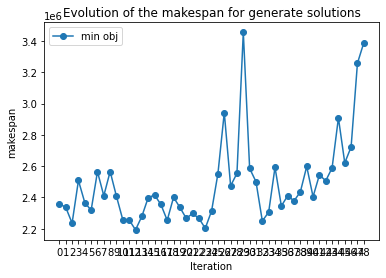

In [6]:
# Plot du minimum de l'objectif parmis les nouvelles solutions générées

import matplotlib.pyplot as plt
print(list_min_obj)
plt.plot([i for i in range(it)], list_min_obj, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

[2359966, 2336256, 2235904, 2235904, 2235904, 2235904, 2235904, 2235904, 2235904, 2235904, 2235904, 2235904, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400, 2192400]


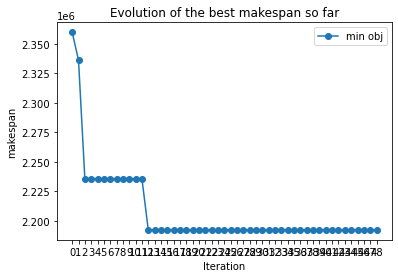

In [7]:
# Plot du minimum de l'objectif parmis les solutions générées so far

print(list_min_obj_global)
plt.plot([i for i in range(it)], list_min_obj_global, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

490


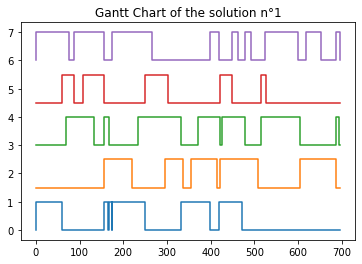

Makespan of the solution n°1 : 696
Regularity of the solution n°1 : 3150
Objective function of the solution n°1 : 2192400


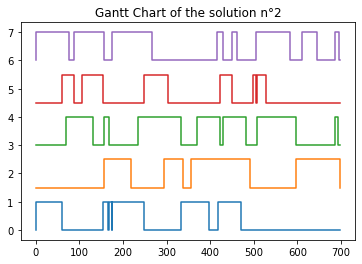

Makespan of the solution n°2 : 698
Regularity of the solution n°2 : 3156
Objective function of the solution n°2 : 2202888


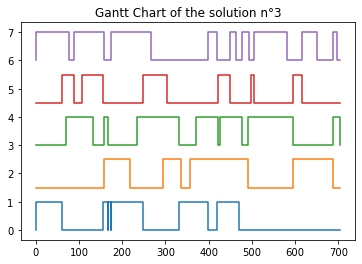

Makespan of the solution n°3 : 704
Regularity of the solution n°3 : 3176
Objective function of the solution n°3 : 2235904


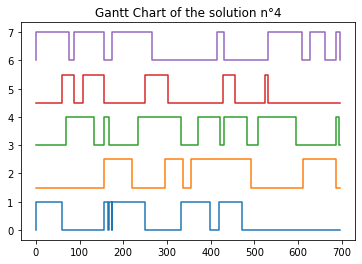

Makespan of the solution n°4 : 696
Regularity of the solution n°4 : 3232
Objective function of the solution n°4 : 2249472


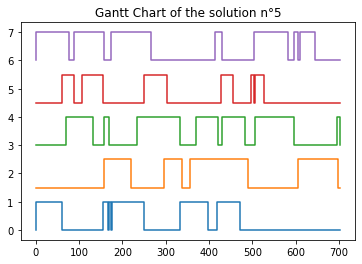

Makespan of the solution n°5 : 703
Regularity of the solution n°5 : 3206
Objective function of the solution n°5 : 2253818


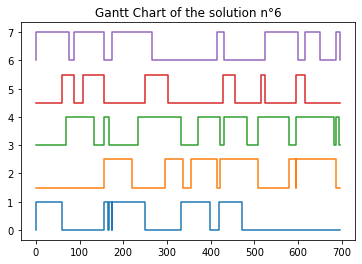

Makespan of the solution n°6 : 696
Regularity of the solution n°6 : 3242
Objective function of the solution n°6 : 2256432


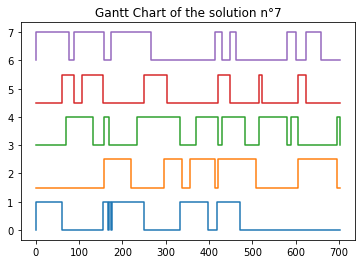

Makespan of the solution n°7 : 703
Regularity of the solution n°7 : 3210
Objective function of the solution n°7 : 2256630


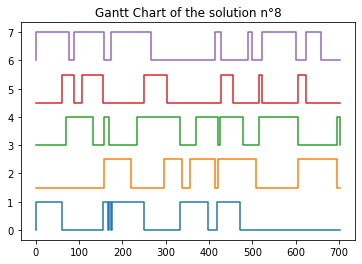

Makespan of the solution n°8 : 703
Regularity of the solution n°8 : 3224
Objective function of the solution n°8 : 2266472


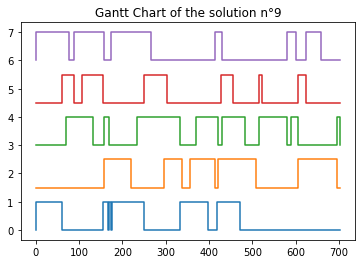

Makespan of the solution n°9 : 703
Regularity of the solution n°9 : 3224
Objective function of the solution n°9 : 2266472


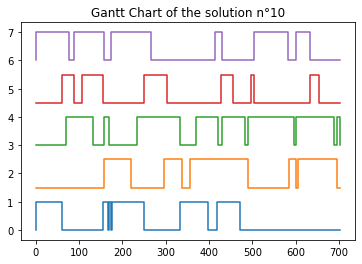

Makespan of the solution n°10 : 703
Regularity of the solution n°10 : 3242
Objective function of the solution n°10 : 2279126


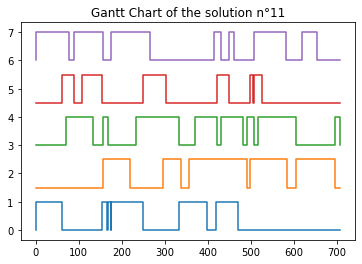

Makespan of the solution n°11 : 708
Regularity of the solution n°11 : 3228
Objective function of the solution n°11 : 2285424


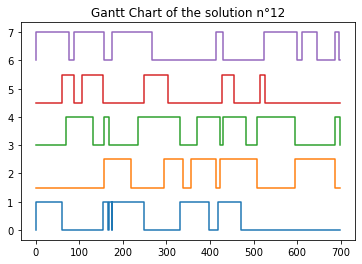

Makespan of the solution n°12 : 699
Regularity of the solution n°12 : 3286
Objective function of the solution n°12 : 2296914


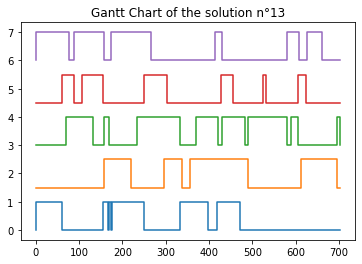

Makespan of the solution n°13 : 703
Regularity of the solution n°13 : 3268
Objective function of the solution n°13 : 2297404


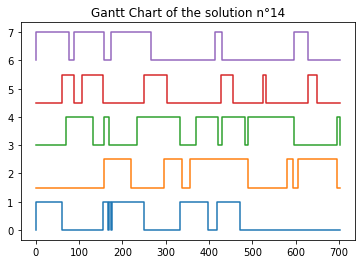

Makespan of the solution n°14 : 703
Regularity of the solution n°14 : 3280
Objective function of the solution n°14 : 2305840


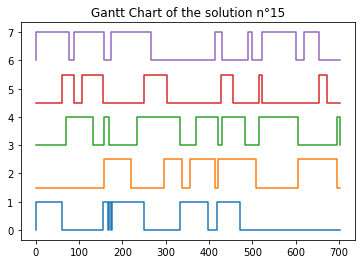

Makespan of the solution n°15 : 703
Regularity of the solution n°15 : 3280
Objective function of the solution n°15 : 2305840


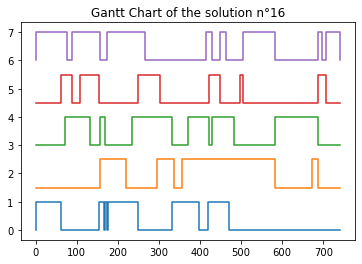

Makespan of the solution n°16 : 741
Regularity of the solution n°16 : 3120
Objective function of the solution n°16 : 2311920


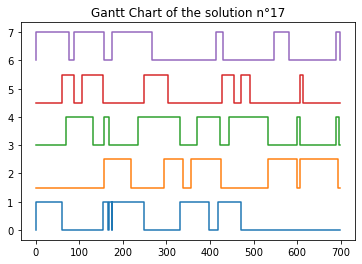

Makespan of the solution n°17 : 699
Regularity of the solution n°17 : 3310
Objective function of the solution n°17 : 2313690


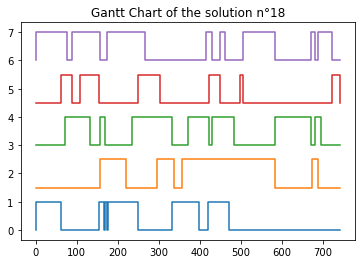

Makespan of the solution n°18 : 742
Regularity of the solution n°18 : 3124
Objective function of the solution n°18 : 2318008


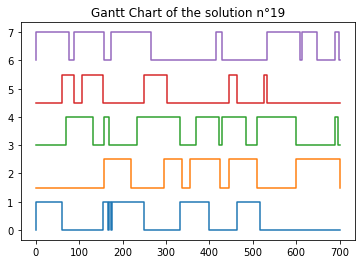

Makespan of the solution n°19 : 701
Regularity of the solution n°19 : 3328
Objective function of the solution n°19 : 2332928


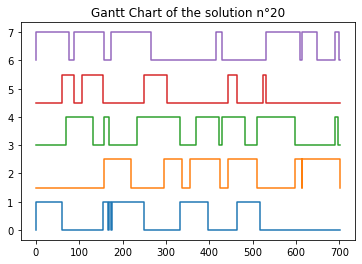

Makespan of the solution n°20 : 702
Regularity of the solution n°20 : 3328
Objective function of the solution n°20 : 2336256


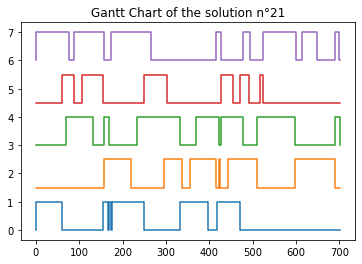

Makespan of the solution n°21 : 702
Regularity of the solution n°21 : 3328
Objective function of the solution n°21 : 2336256


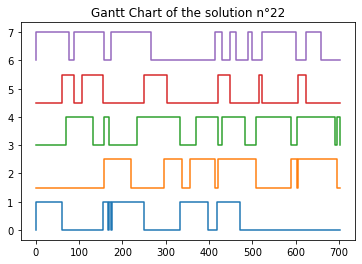

Makespan of the solution n°22 : 703
Regularity of the solution n°22 : 3336
Objective function of the solution n°22 : 2345208


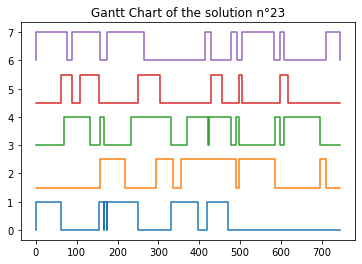

Makespan of the solution n°23 : 745
Regularity of the solution n°23 : 3150
Objective function of the solution n°23 : 2346750


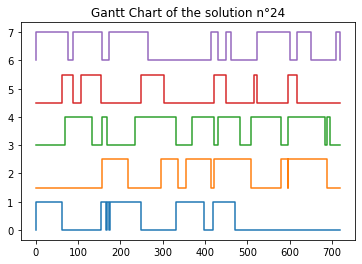

Makespan of the solution n°24 : 719
Regularity of the solution n°24 : 3274
Objective function of the solution n°24 : 2354006


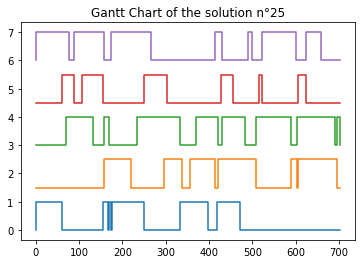

Makespan of the solution n°25 : 703
Regularity of the solution n°25 : 3350
Objective function of the solution n°25 : 2355050


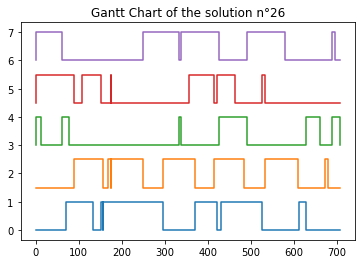

Makespan of the solution n°26 : 707
Regularity of the solution n°26 : 3338
Objective function of the solution n°26 : 2359966


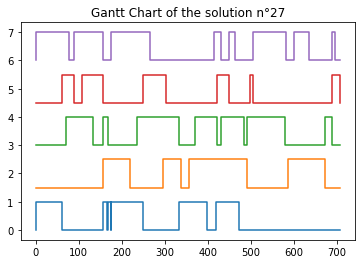

Makespan of the solution n°27 : 707
Regularity of the solution n°27 : 3340
Objective function of the solution n°27 : 2361380


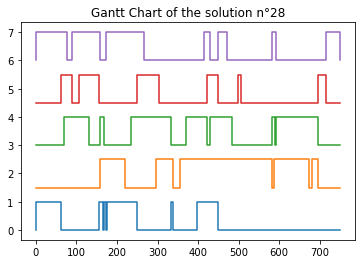

Makespan of the solution n°28 : 750
Regularity of the solution n°28 : 3156
Objective function of the solution n°28 : 2367000


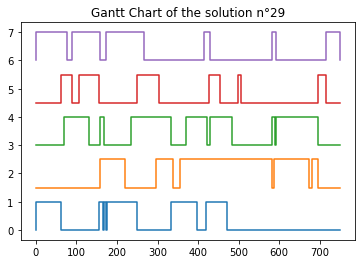

Makespan of the solution n°29 : 750
Regularity of the solution n°29 : 3170
Objective function of the solution n°29 : 2377500


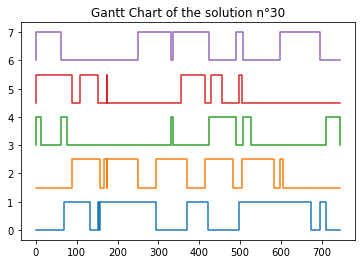

Makespan of the solution n°30 : 745
Regularity of the solution n°30 : 3214
Objective function of the solution n°30 : 2394430


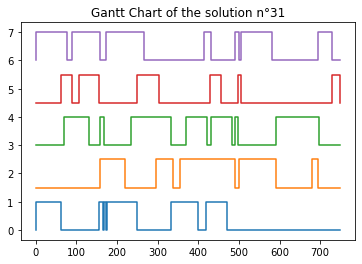

Makespan of the solution n°31 : 749
Regularity of the solution n°31 : 3202
Objective function of the solution n°31 : 2398298


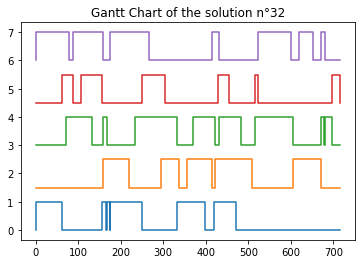

Makespan of the solution n°32 : 716
Regularity of the solution n°32 : 3352
Objective function of the solution n°32 : 2400032


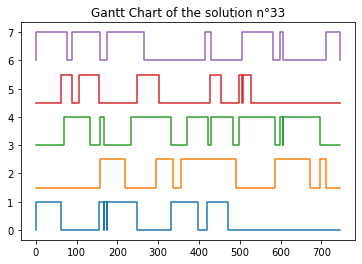

Makespan of the solution n°33 : 746
Regularity of the solution n°33 : 3218
Objective function of the solution n°33 : 2400628


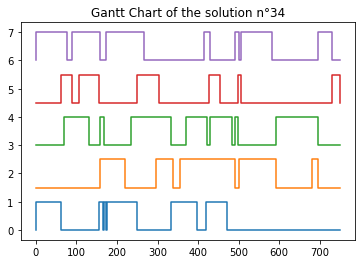

Makespan of the solution n°34 : 750
Regularity of the solution n°34 : 3206
Objective function of the solution n°34 : 2404500


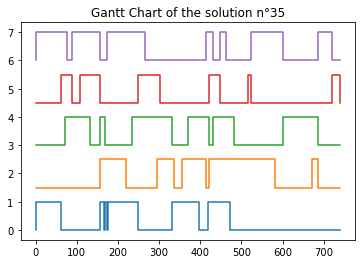

Makespan of the solution n°35 : 740
Regularity of the solution n°35 : 3252
Objective function of the solution n°35 : 2406480


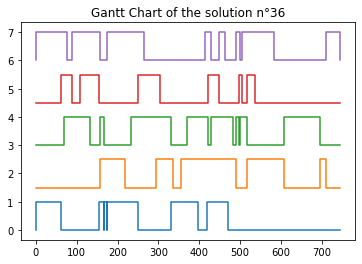

Makespan of the solution n°36 : 745
Regularity of the solution n°36 : 3236
Objective function of the solution n°36 : 2410820


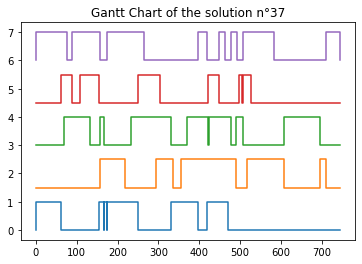

Makespan of the solution n°37 : 745
Regularity of the solution n°37 : 3236
Objective function of the solution n°37 : 2410820


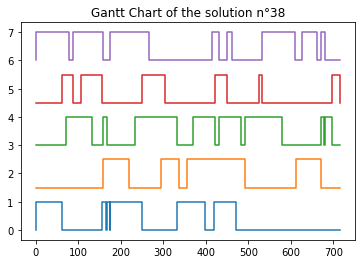

Makespan of the solution n°38 : 716
Regularity of the solution n°38 : 3374
Objective function of the solution n°38 : 2415784


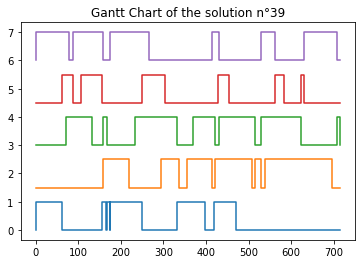

Makespan of the solution n°39 : 715
Regularity of the solution n°39 : 3400
Objective function of the solution n°39 : 2431000


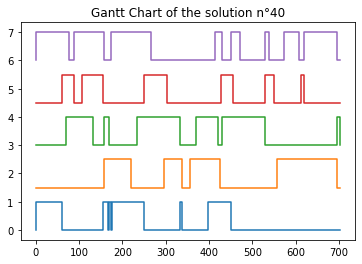

Makespan of the solution n°40 : 703
Regularity of the solution n°40 : 3462
Objective function of the solution n°40 : 2433786


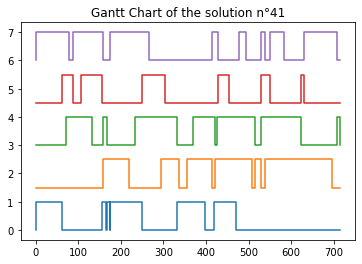

Makespan of the solution n°41 : 715
Regularity of the solution n°41 : 3404
Objective function of the solution n°41 : 2433860


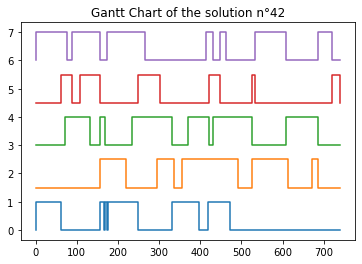

Makespan of the solution n°42 : 740
Regularity of the solution n°42 : 3292
Objective function of the solution n°42 : 2436080


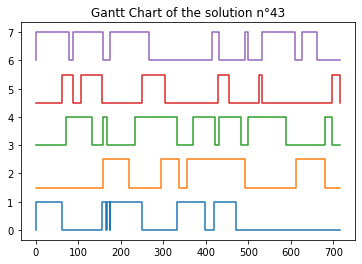

Makespan of the solution n°43 : 716
Regularity of the solution n°43 : 3424
Objective function of the solution n°43 : 2451584


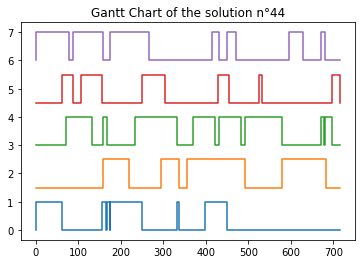

Makespan of the solution n°44 : 716
Regularity of the solution n°44 : 3448
Objective function of the solution n°44 : 2468768


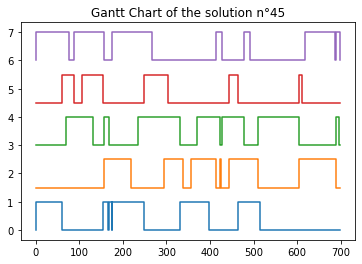

Makespan of the solution n°45 : 699
Regularity of the solution n°45 : 3534
Objective function of the solution n°45 : 2470266


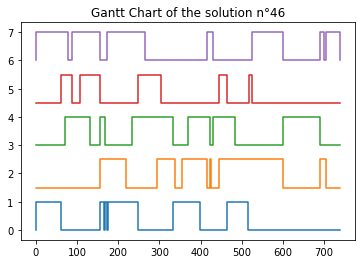

Makespan of the solution n°46 : 739
Regularity of the solution n°46 : 3348
Objective function of the solution n°46 : 2474172


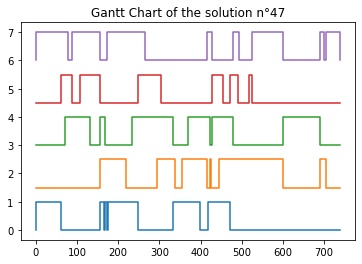

Makespan of the solution n°47 : 739
Regularity of the solution n°47 : 3348
Objective function of the solution n°47 : 2474172


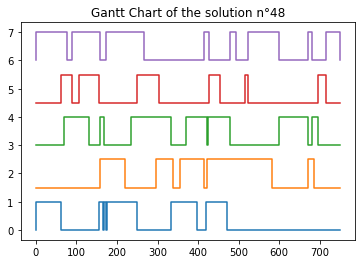

Makespan of the solution n°48 : 750
Regularity of the solution n°48 : 3306
Objective function of the solution n°48 : 2479500


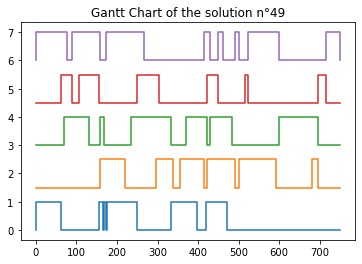

Makespan of the solution n°49 : 750
Regularity of the solution n°49 : 3328
Objective function of the solution n°49 : 2496000


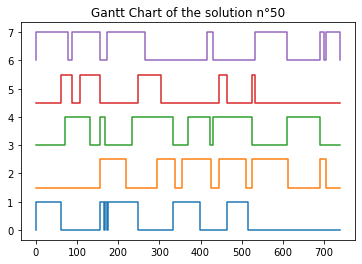

Makespan of the solution n°50 : 739
Regularity of the solution n°50 : 3384
Objective function of the solution n°50 : 2500776


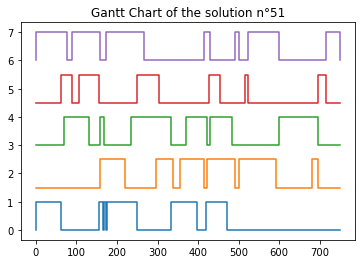

Makespan of the solution n°51 : 750
Regularity of the solution n°51 : 3342
Objective function of the solution n°51 : 2506500


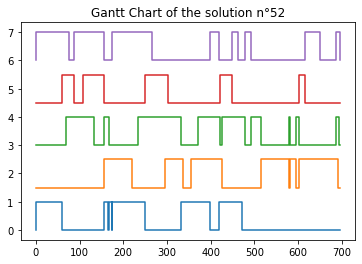

Makespan of the solution n°52 : 696
Regularity of the solution n°52 : 3604
Objective function of the solution n°52 : 2508384


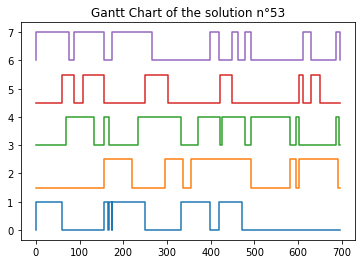

Makespan of the solution n°53 : 696
Regularity of the solution n°53 : 3604
Objective function of the solution n°53 : 2508384


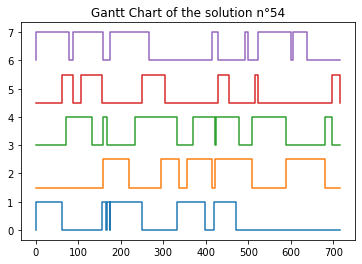

Makespan of the solution n°54 : 716
Regularity of the solution n°54 : 3514
Objective function of the solution n°54 : 2516024


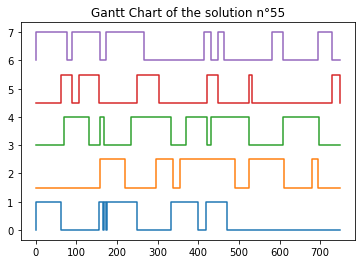

Makespan of the solution n°55 : 749
Regularity of the solution n°55 : 3364
Objective function of the solution n°55 : 2519636


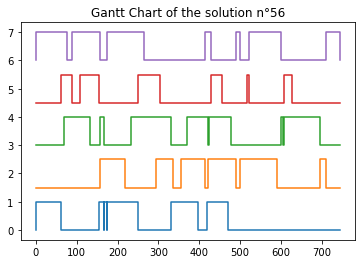

Makespan of the solution n°56 : 745
Regularity of the solution n°56 : 3386
Objective function of the solution n°56 : 2522570


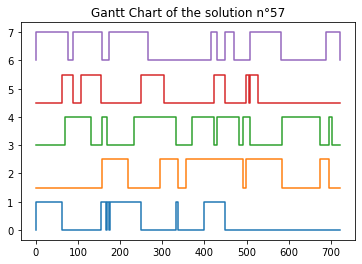

Makespan of the solution n°57 : 722
Regularity of the solution n°57 : 3500
Objective function of the solution n°57 : 2527000


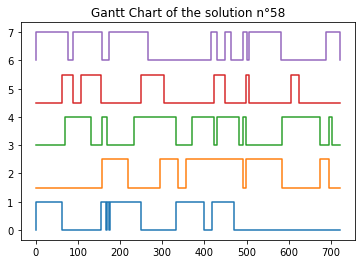

Makespan of the solution n°58 : 722
Regularity of the solution n°58 : 3500
Objective function of the solution n°58 : 2527000


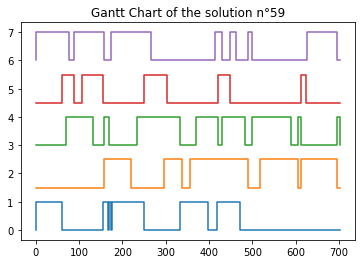

Makespan of the solution n°59 : 703
Regularity of the solution n°59 : 3602
Objective function of the solution n°59 : 2532206


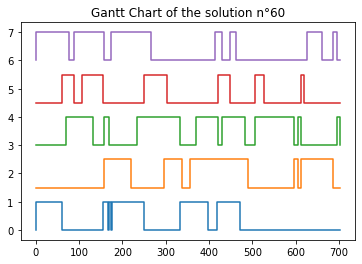

Makespan of the solution n°60 : 703
Regularity of the solution n°60 : 3602
Objective function of the solution n°60 : 2532206


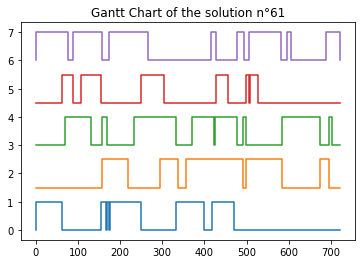

Makespan of the solution n°61 : 722
Regularity of the solution n°61 : 3514
Objective function of the solution n°61 : 2537108


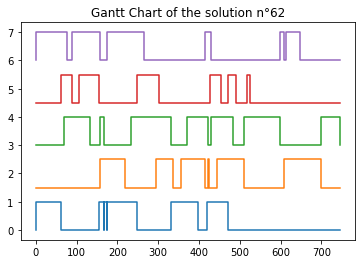

Makespan of the solution n°62 : 746
Regularity of the solution n°62 : 3402
Objective function of the solution n°62 : 2537892


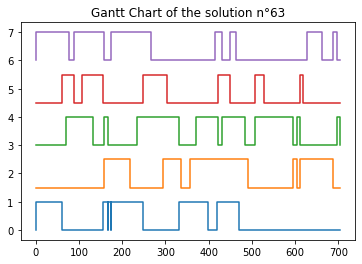

Makespan of the solution n°63 : 704
Regularity of the solution n°63 : 3606
Objective function of the solution n°63 : 2538624


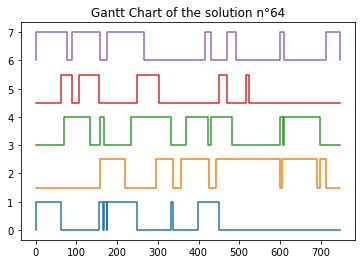

Makespan of the solution n°64 : 748
Regularity of the solution n°64 : 3396
Objective function of the solution n°64 : 2540208


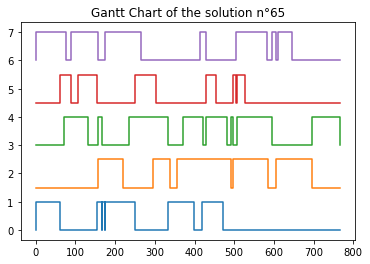

Makespan of the solution n°65 : 767
Regularity of the solution n°65 : 3312
Objective function of the solution n°65 : 2540304


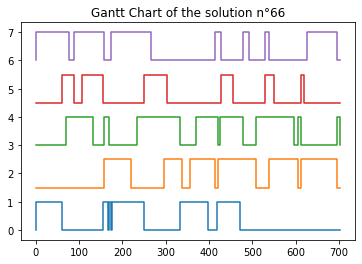

Makespan of the solution n°66 : 703
Regularity of the solution n°66 : 3616
Objective function of the solution n°66 : 2542048


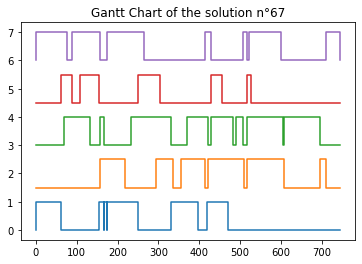

Makespan of the solution n°67 : 745
Regularity of the solution n°67 : 3414
Objective function of the solution n°67 : 2543430


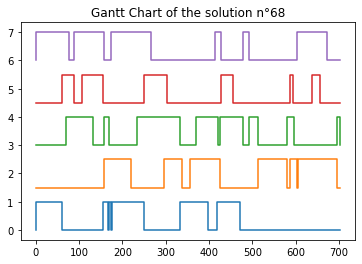

Makespan of the solution n°68 : 703
Regularity of the solution n°68 : 3622
Objective function of the solution n°68 : 2546266


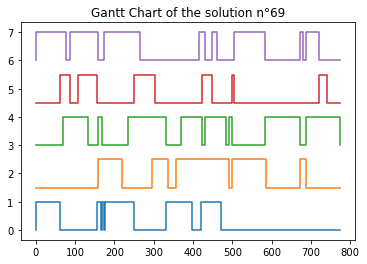

Makespan of the solution n°69 : 774
Regularity of the solution n°69 : 3294
Objective function of the solution n°69 : 2549556


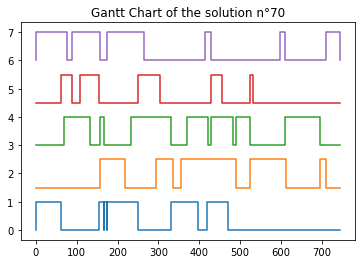

Makespan of the solution n°70 : 745
Regularity of the solution n°70 : 3426
Objective function of the solution n°70 : 2552370


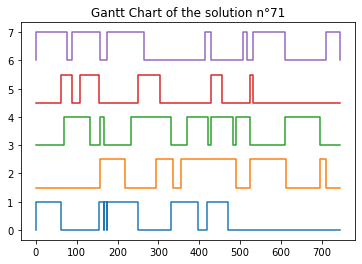

Makespan of the solution n°71 : 745
Regularity of the solution n°71 : 3426
Objective function of the solution n°71 : 2552370


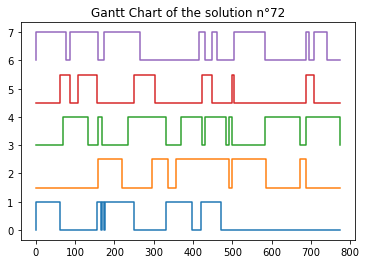

Makespan of the solution n°72 : 774
Regularity of the solution n°72 : 3298
Objective function of the solution n°72 : 2552652


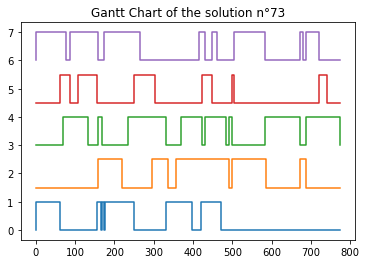

Makespan of the solution n°73 : 774
Regularity of the solution n°73 : 3298
Objective function of the solution n°73 : 2552652


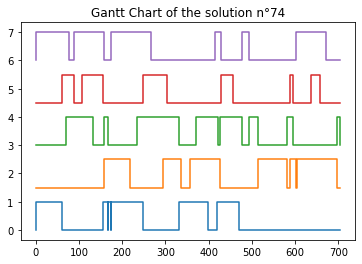

Makespan of the solution n°74 : 704
Regularity of the solution n°74 : 3626
Objective function of the solution n°74 : 2552704


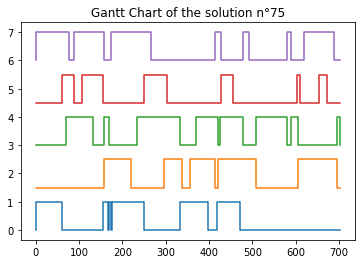

Makespan of the solution n°75 : 703
Regularity of the solution n°75 : 3632
Objective function of the solution n°75 : 2553296


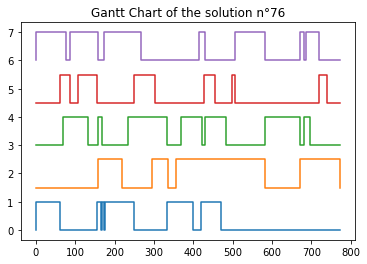

Makespan of the solution n°76 : 773
Regularity of the solution n°76 : 3304
Objective function of the solution n°76 : 2553992


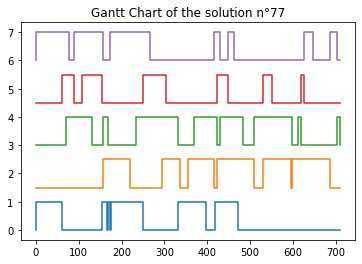

Makespan of the solution n°77 : 710
Regularity of the solution n°77 : 3598
Objective function of the solution n°77 : 2554580


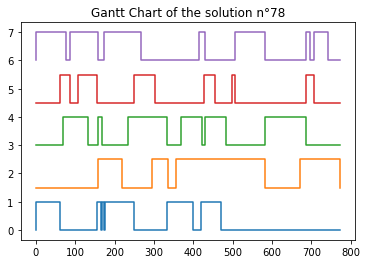

Makespan of the solution n°78 : 773
Regularity of the solution n°78 : 3308
Objective function of the solution n°78 : 2557084


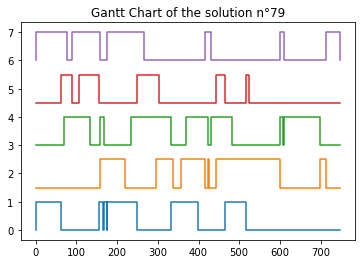

Makespan of the solution n°79 : 748
Regularity of the solution n°79 : 3420
Objective function of the solution n°79 : 2558160


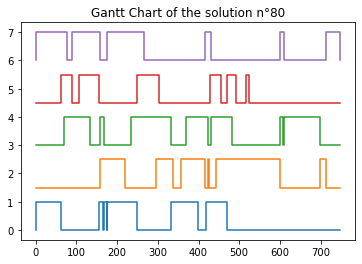

Makespan of the solution n°80 : 748
Regularity of the solution n°80 : 3420
Objective function of the solution n°80 : 2558160


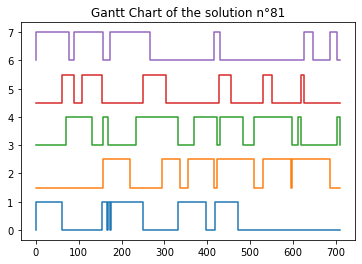

Makespan of the solution n°81 : 710
Regularity of the solution n°81 : 3612
Objective function of the solution n°81 : 2564520


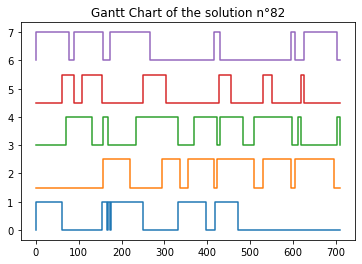

Makespan of the solution n°82 : 710
Regularity of the solution n°82 : 3612
Objective function of the solution n°82 : 2564520


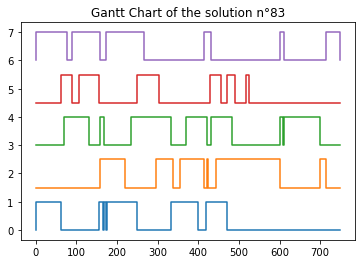

Makespan of the solution n°83 : 749
Regularity of the solution n°83 : 3424
Objective function of the solution n°83 : 2564576


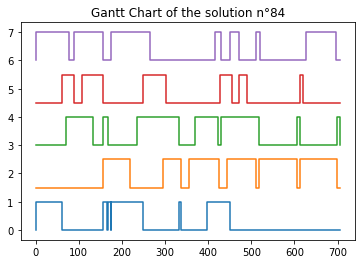

Makespan of the solution n°84 : 706
Regularity of the solution n°84 : 3634
Objective function of the solution n°84 : 2565604


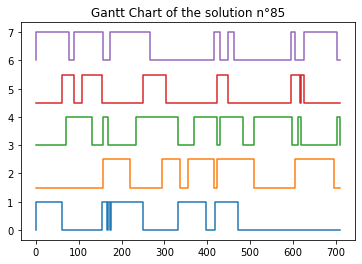

Makespan of the solution n°85 : 710
Regularity of the solution n°85 : 3614
Objective function of the solution n°85 : 2565940


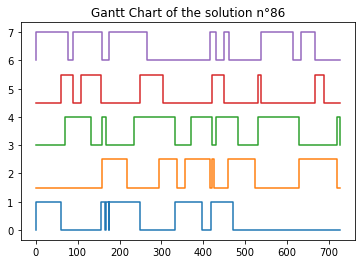

Makespan of the solution n°86 : 727
Regularity of the solution n°86 : 3530
Objective function of the solution n°86 : 2566310


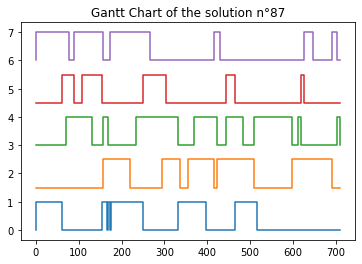

Makespan of the solution n°87 : 710
Regularity of the solution n°87 : 3618
Objective function of the solution n°87 : 2568780


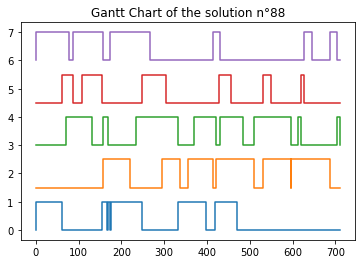

Makespan of the solution n°88 : 711
Regularity of the solution n°88 : 3616
Objective function of the solution n°88 : 2570976


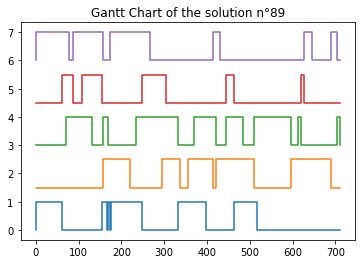

Makespan of the solution n°89 : 711
Regularity of the solution n°89 : 3622
Objective function of the solution n°89 : 2575242


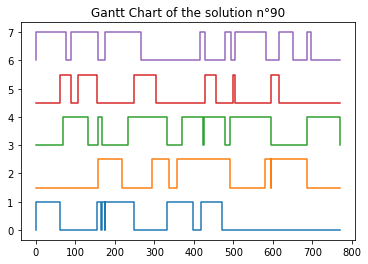

Makespan of the solution n°90 : 770
Regularity of the solution n°90 : 3352
Objective function of the solution n°90 : 2581040


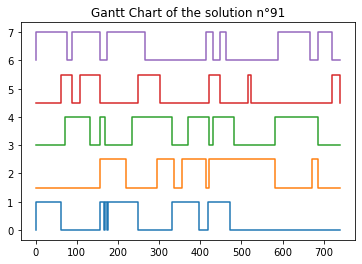

Makespan of the solution n°91 : 740
Regularity of the solution n°91 : 3488
Objective function of the solution n°91 : 2581120


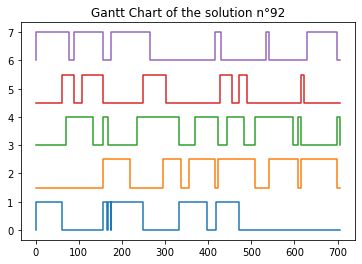

Makespan of the solution n°92 : 706
Regularity of the solution n°92 : 3658
Objective function of the solution n°92 : 2582548


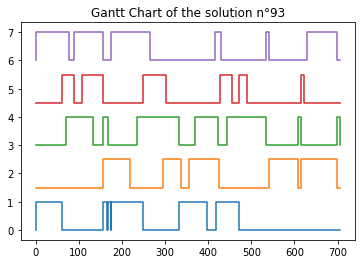

Makespan of the solution n°93 : 706
Regularity of the solution n°93 : 3658
Objective function of the solution n°93 : 2582548


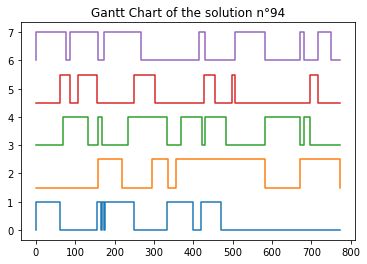

Makespan of the solution n°94 : 773
Regularity of the solution n°94 : 3344
Objective function of the solution n°94 : 2584912


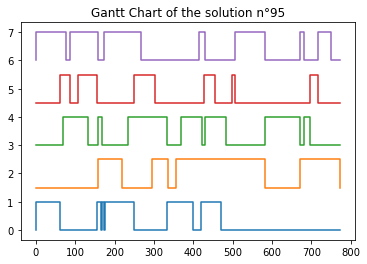

Makespan of the solution n°95 : 773
Regularity of the solution n°95 : 3348
Objective function of the solution n°95 : 2588004


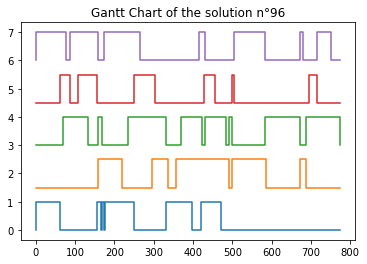

Makespan of the solution n°96 : 774
Regularity of the solution n°96 : 3348
Objective function of the solution n°96 : 2591352


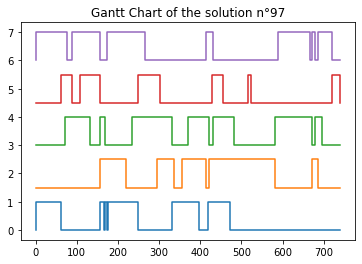

Makespan of the solution n°97 : 740
Regularity of the solution n°97 : 3502
Objective function of the solution n°97 : 2591480


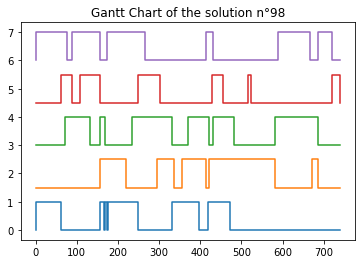

Makespan of the solution n°98 : 740
Regularity of the solution n°98 : 3502
Objective function of the solution n°98 : 2591480


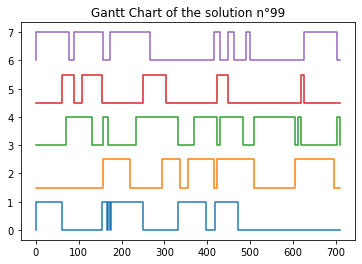

Makespan of the solution n°99 : 710
Regularity of the solution n°99 : 3650
Objective function of the solution n°99 : 2591500


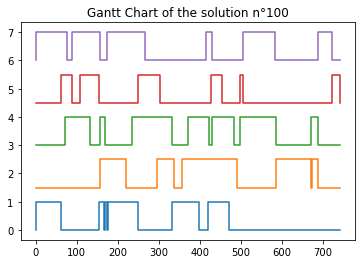

Makespan of the solution n°100 : 742
Regularity of the solution n°100 : 3494
Objective function of the solution n°100 : 2592548


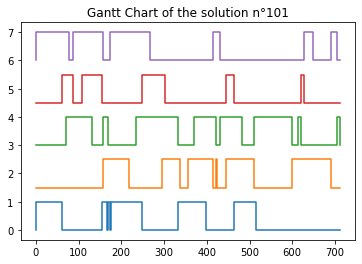

Makespan of the solution n°101 : 712
Regularity of the solution n°101 : 3642
Objective function of the solution n°101 : 2593104


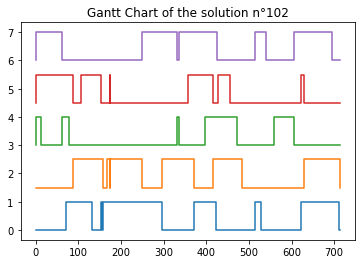

Makespan of the solution n°102 : 714
Regularity of the solution n°102 : 3634
Objective function of the solution n°102 : 2594676


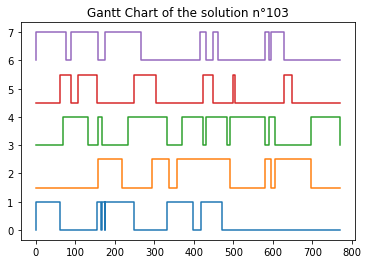

Makespan of the solution n°103 : 770
Regularity of the solution n°103 : 3370
Objective function of the solution n°103 : 2594900


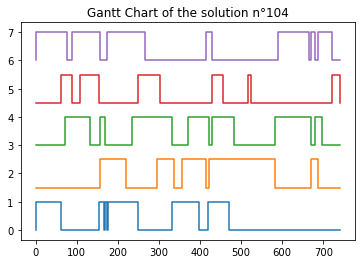

Makespan of the solution n°104 : 741
Regularity of the solution n°104 : 3506
Objective function of the solution n°104 : 2597946


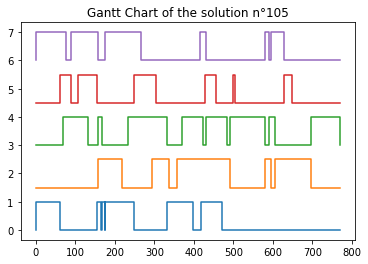

Makespan of the solution n°105 : 770
Regularity of the solution n°105 : 3384
Objective function of the solution n°105 : 2605680


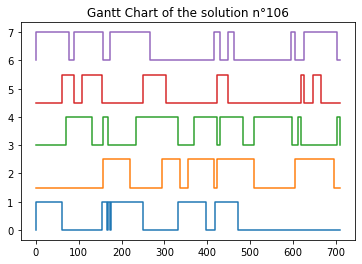

Makespan of the solution n°106 : 710
Regularity of the solution n°106 : 3678
Objective function of the solution n°106 : 2611380


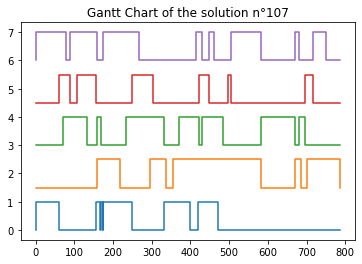

Makespan of the solution n°107 : 787
Regularity of the solution n°107 : 3330
Objective function of the solution n°107 : 2620710


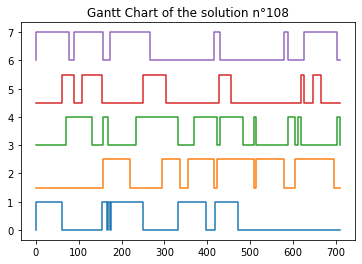

Makespan of the solution n°108 : 710
Regularity of the solution n°108 : 3692
Objective function of the solution n°108 : 2621320


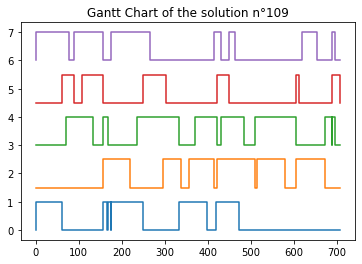

Makespan of the solution n°109 : 707
Regularity of the solution n°109 : 3722
Objective function of the solution n°109 : 2631454


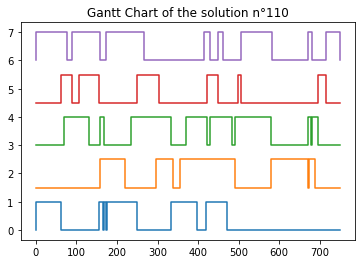

Makespan of the solution n°110 : 750
Regularity of the solution n°110 : 3512
Objective function of the solution n°110 : 2634000


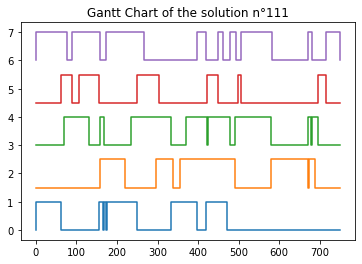

Makespan of the solution n°111 : 750
Regularity of the solution n°111 : 3512
Objective function of the solution n°111 : 2634000


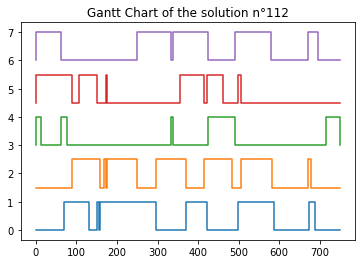

Makespan of the solution n°112 : 750
Regularity of the solution n°112 : 3512
Objective function of the solution n°112 : 2634000


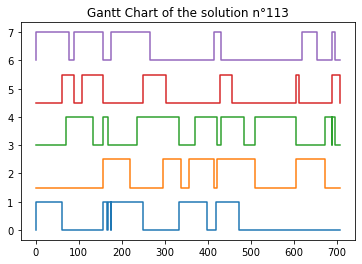

Makespan of the solution n°113 : 707
Regularity of the solution n°113 : 3736
Objective function of the solution n°113 : 2641352


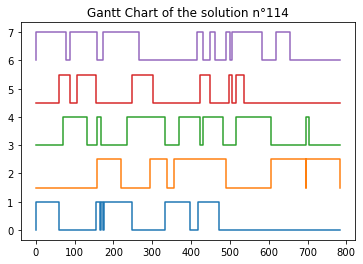

Makespan of the solution n°114 : 784
Regularity of the solution n°114 : 3370
Objective function of the solution n°114 : 2642080


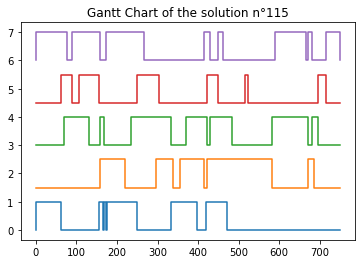

Makespan of the solution n°115 : 750
Regularity of the solution n°115 : 3528
Objective function of the solution n°115 : 2646000


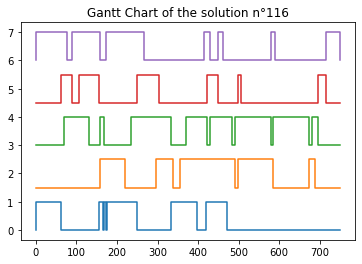

Makespan of the solution n°116 : 750
Regularity of the solution n°116 : 3548
Objective function of the solution n°116 : 2661000


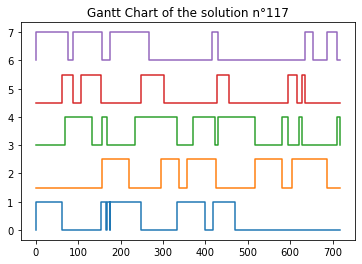

Makespan of the solution n°117 : 718
Regularity of the solution n°117 : 3708
Objective function of the solution n°117 : 2662344


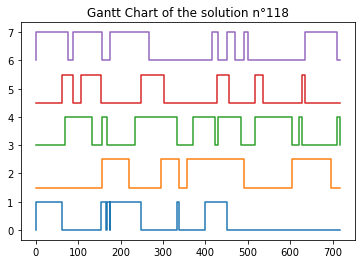

Makespan of the solution n°118 : 718
Regularity of the solution n°118 : 3708
Objective function of the solution n°118 : 2662344


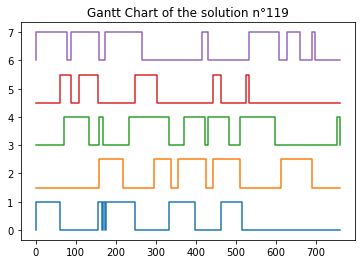

Makespan of the solution n°119 : 761
Regularity of the solution n°119 : 3506
Objective function of the solution n°119 : 2668066


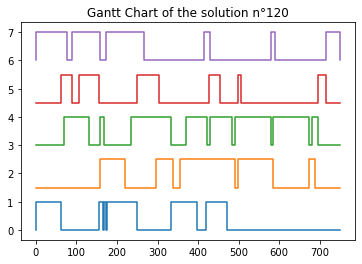

Makespan of the solution n°120 : 750
Regularity of the solution n°120 : 3562
Objective function of the solution n°120 : 2671500


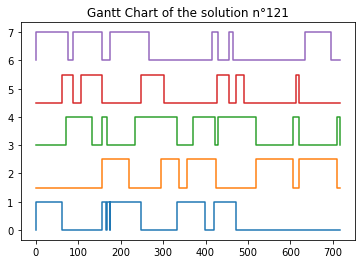

Makespan of the solution n°121 : 717
Regularity of the solution n°121 : 3728
Objective function of the solution n°121 : 2672976


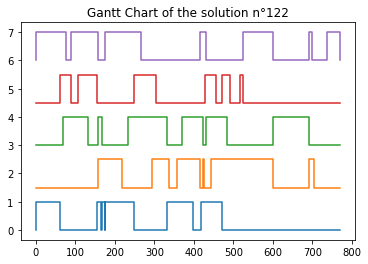

Makespan of the solution n°122 : 770
Regularity of the solution n°122 : 3472
Objective function of the solution n°122 : 2673440


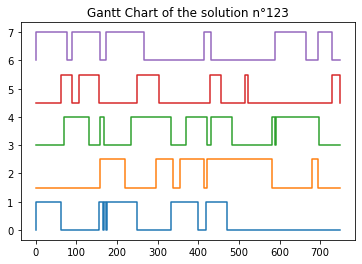

Makespan of the solution n°123 : 749
Regularity of the solution n°123 : 3574
Objective function of the solution n°123 : 2676926


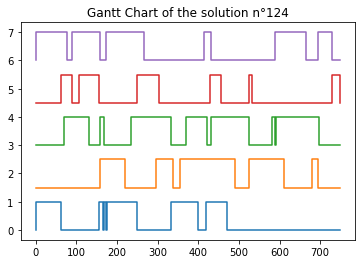

Makespan of the solution n°124 : 749
Regularity of the solution n°124 : 3578
Objective function of the solution n°124 : 2679922


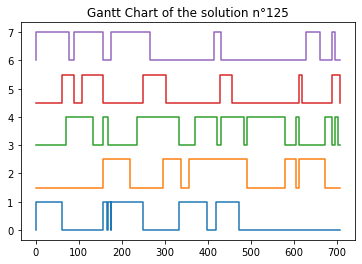

Makespan of the solution n°125 : 707
Regularity of the solution n°125 : 3800
Objective function of the solution n°125 : 2686600


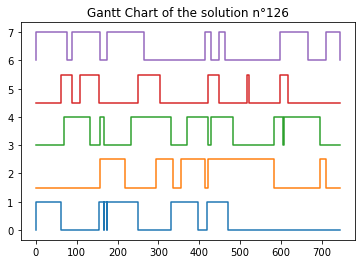

Makespan of the solution n°126 : 745
Regularity of the solution n°126 : 3608
Objective function of the solution n°126 : 2687960


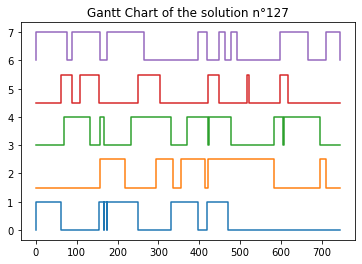

Makespan of the solution n°127 : 745
Regularity of the solution n°127 : 3608
Objective function of the solution n°127 : 2687960


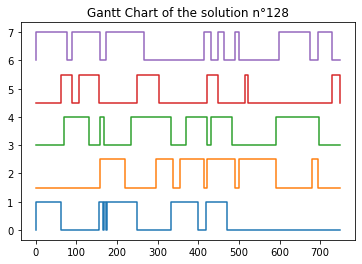

Makespan of the solution n°128 : 749
Regularity of the solution n°128 : 3596
Objective function of the solution n°128 : 2693404


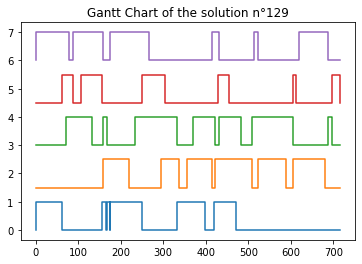

Makespan of the solution n°129 : 716
Regularity of the solution n°129 : 3772
Objective function of the solution n°129 : 2700752


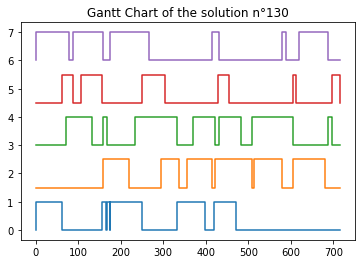

Makespan of the solution n°130 : 716
Regularity of the solution n°130 : 3772
Objective function of the solution n°130 : 2700752


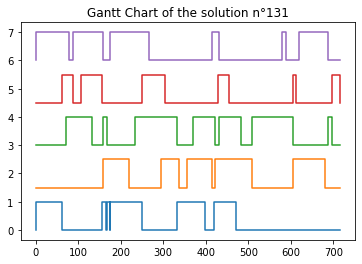

Makespan of the solution n°131 : 716
Regularity of the solution n°131 : 3772
Objective function of the solution n°131 : 2700752


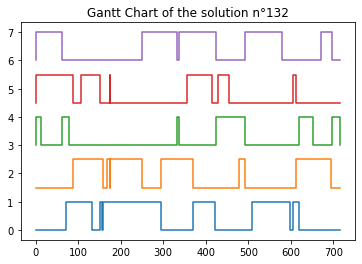

Makespan of the solution n°132 : 716
Regularity of the solution n°132 : 3772
Objective function of the solution n°132 : 2700752


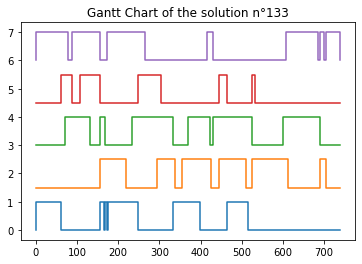

Makespan of the solution n°133 : 739
Regularity of the solution n°133 : 3660
Objective function of the solution n°133 : 2704740


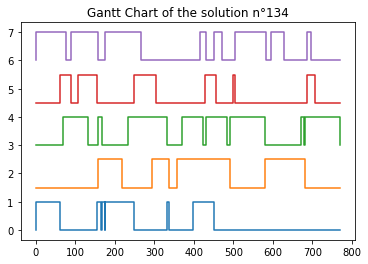

Makespan of the solution n°134 : 770
Regularity of the solution n°134 : 3516
Objective function of the solution n°134 : 2707320


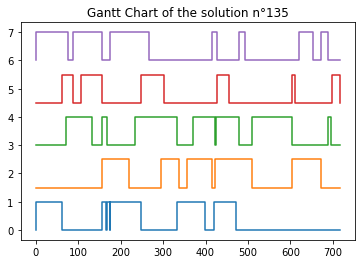

Makespan of the solution n°135 : 717
Regularity of the solution n°135 : 3776
Objective function of the solution n°135 : 2707392


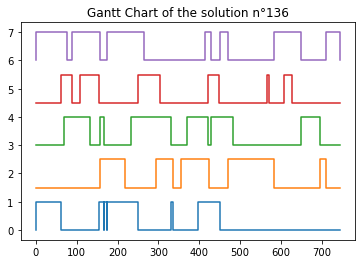

Makespan of the solution n°136 : 745
Regularity of the solution n°136 : 3646
Objective function of the solution n°136 : 2716270


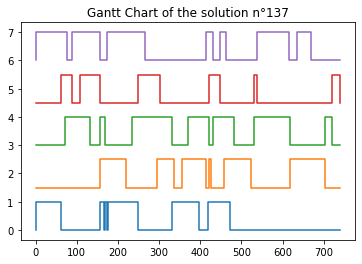

Makespan of the solution n°137 : 740
Regularity of the solution n°137 : 3674
Objective function of the solution n°137 : 2718760


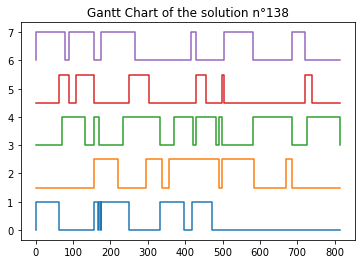

Makespan of the solution n°138 : 815
Regularity of the solution n°138 : 3340
Objective function of the solution n°138 : 2722100


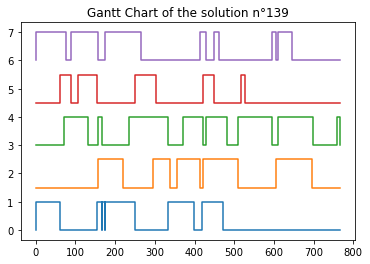

Makespan of the solution n°139 : 767
Regularity of the solution n°139 : 3564
Objective function of the solution n°139 : 2733588


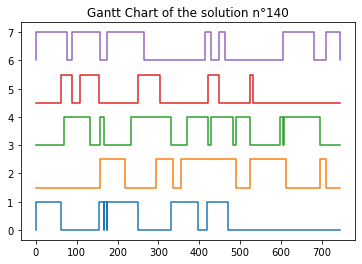

Makespan of the solution n°140 : 745
Regularity of the solution n°140 : 3676
Objective function of the solution n°140 : 2738620


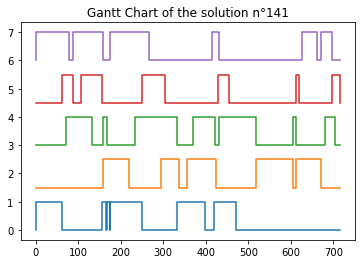

Makespan of the solution n°141 : 716
Regularity of the solution n°141 : 3836
Objective function of the solution n°141 : 2746576


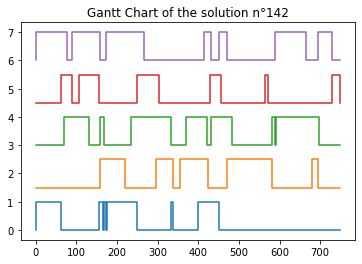

Makespan of the solution n°142 : 749
Regularity of the solution n°142 : 3684
Objective function of the solution n°142 : 2759316


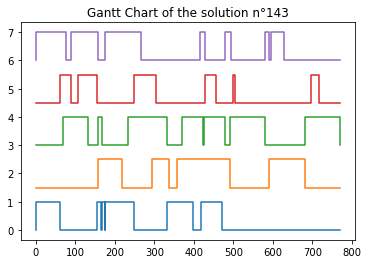

Makespan of the solution n°143 : 770
Regularity of the solution n°143 : 3588
Objective function of the solution n°143 : 2762760


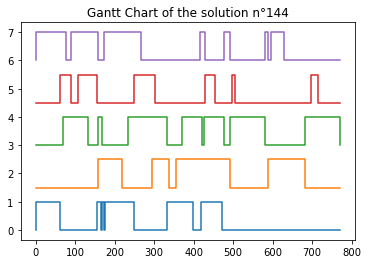

Makespan of the solution n°144 : 771
Regularity of the solution n°144 : 3588
Objective function of the solution n°144 : 2766348


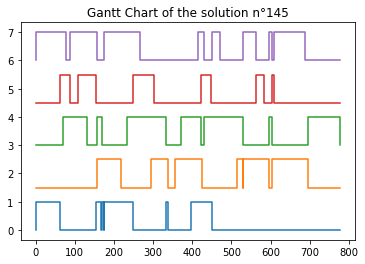

Makespan of the solution n°145 : 778
Regularity of the solution n°145 : 3558
Objective function of the solution n°145 : 2768124


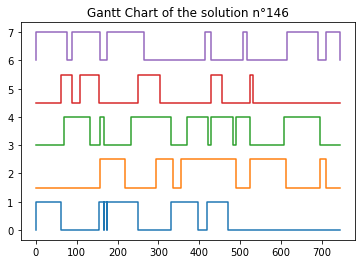

Makespan of the solution n°146 : 745
Regularity of the solution n°146 : 3726
Objective function of the solution n°146 : 2775870


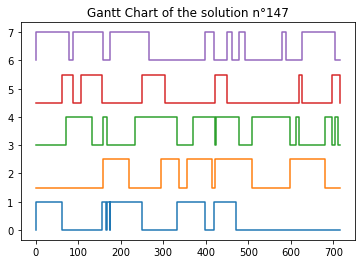

Makespan of the solution n°147 : 716
Regularity of the solution n°147 : 3878
Objective function of the solution n°147 : 2776648


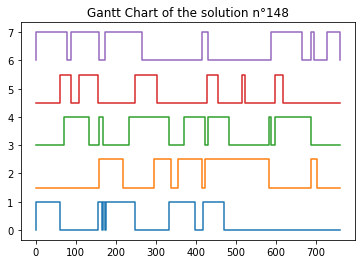

Makespan of the solution n°148 : 761
Regularity of the solution n°148 : 3650
Objective function of the solution n°148 : 2777650


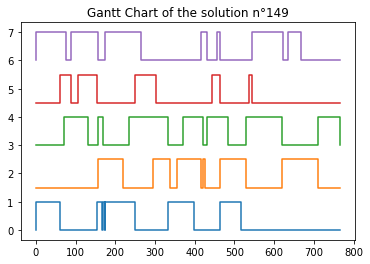

Makespan of the solution n°149 : 766
Regularity of the solution n°149 : 3628
Objective function of the solution n°149 : 2779048


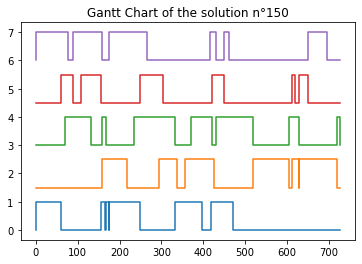

Makespan of the solution n°150 : 727
Regularity of the solution n°150 : 3834
Objective function of the solution n°150 : 2787318


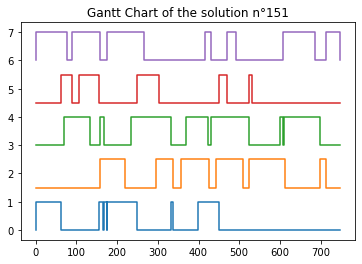

Makespan of the solution n°151 : 748
Regularity of the solution n°151 : 3732
Objective function of the solution n°151 : 2791536


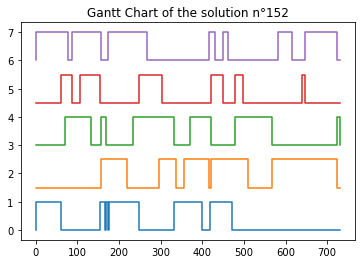

Makespan of the solution n°152 : 731
Regularity of the solution n°152 : 3820
Objective function of the solution n°152 : 2792420


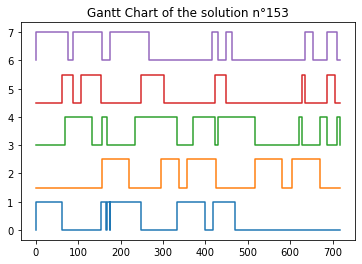

Makespan of the solution n°153 : 718
Regularity of the solution n°153 : 3906
Objective function of the solution n°153 : 2804508


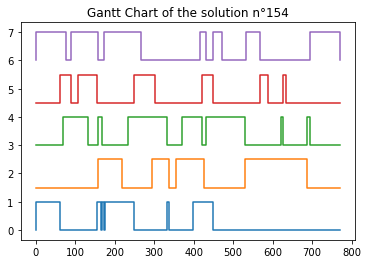

Makespan of the solution n°154 : 771
Regularity of the solution n°154 : 3638
Objective function of the solution n°154 : 2804898


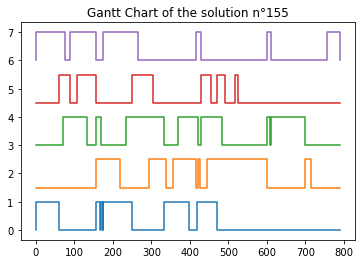

Makespan of the solution n°155 : 790
Regularity of the solution n°155 : 3588
Objective function of the solution n°155 : 2834520


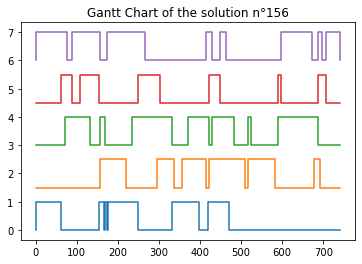

Makespan of the solution n°156 : 741
Regularity of the solution n°156 : 3836
Objective function of the solution n°156 : 2842476


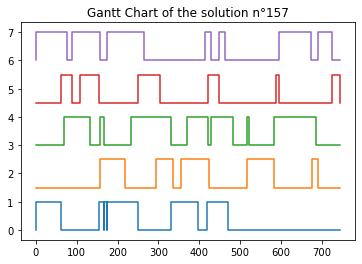

Makespan of the solution n°157 : 745
Regularity of the solution n°157 : 3816
Objective function of the solution n°157 : 2842920


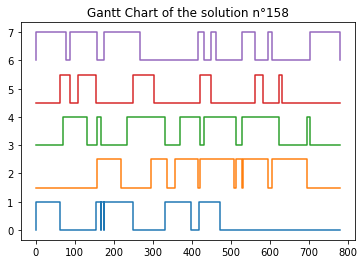

Makespan of the solution n°158 : 780
Regularity of the solution n°158 : 3646
Objective function of the solution n°158 : 2843880


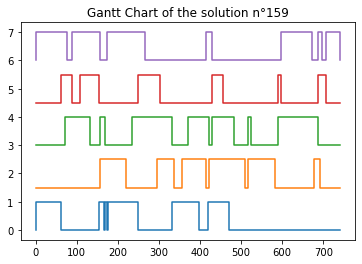

Makespan of the solution n°159 : 741
Regularity of the solution n°159 : 3850
Objective function of the solution n°159 : 2852850


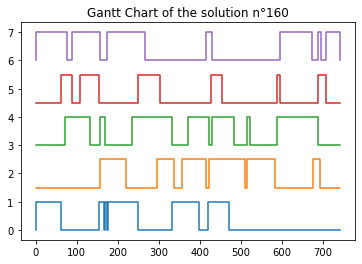

Makespan of the solution n°160 : 742
Regularity of the solution n°160 : 3854
Objective function of the solution n°160 : 2859668


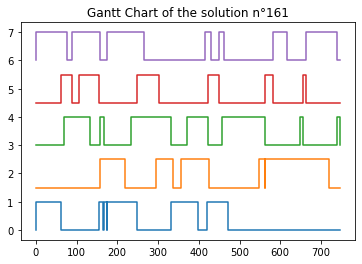

Makespan of the solution n°161 : 747
Regularity of the solution n°161 : 3834
Objective function of the solution n°161 : 2863998


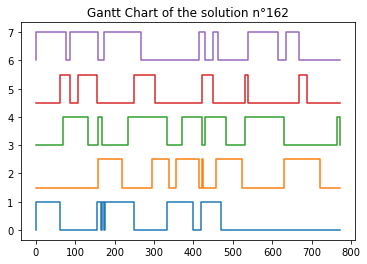

Makespan of the solution n°162 : 772
Regularity of the solution n°162 : 3710
Objective function of the solution n°162 : 2864120


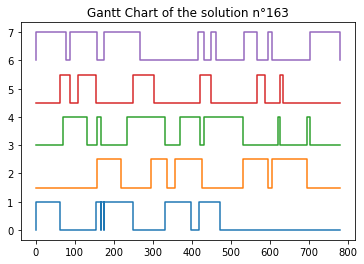

Makespan of the solution n°163 : 780
Regularity of the solution n°163 : 3674
Objective function of the solution n°163 : 2865720


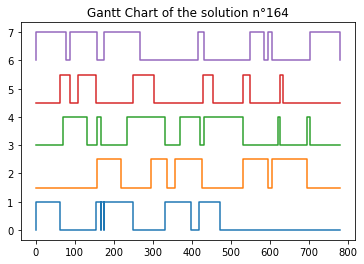

Makespan of the solution n°164 : 780
Regularity of the solution n°164 : 3676
Objective function of the solution n°164 : 2867280


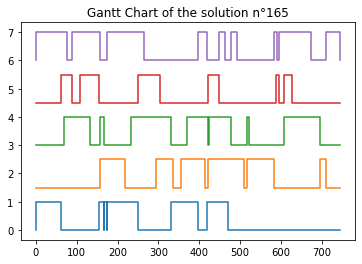

Makespan of the solution n°165 : 745
Regularity of the solution n°165 : 3852
Objective function of the solution n°165 : 2869740


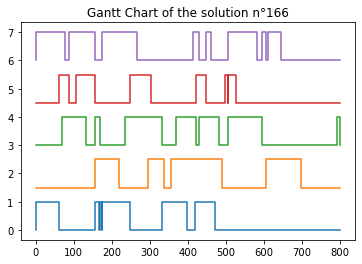

Makespan of the solution n°166 : 801
Regularity of the solution n°166 : 3584
Objective function of the solution n°166 : 2870784


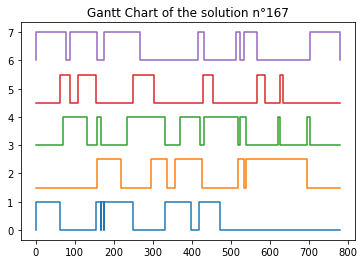

Makespan of the solution n°167 : 780
Regularity of the solution n°167 : 3688
Objective function of the solution n°167 : 2876640


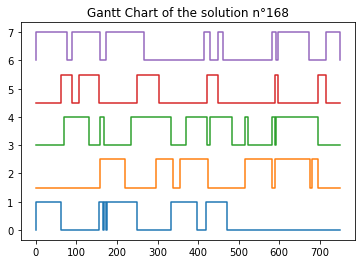

Makespan of the solution n°168 : 750
Regularity of the solution n°168 : 3836
Objective function of the solution n°168 : 2877000


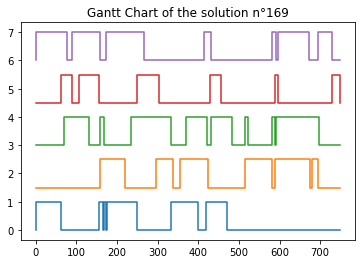

Makespan of the solution n°169 : 749
Regularity of the solution n°169 : 3846
Objective function of the solution n°169 : 2880654


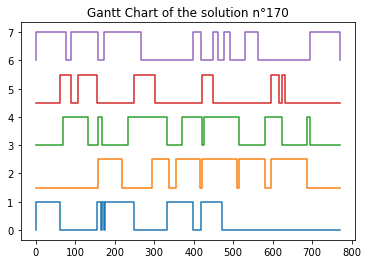

Makespan of the solution n°170 : 771
Regularity of the solution n°170 : 3742
Objective function of the solution n°170 : 2885082


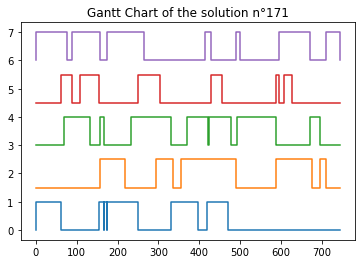

Makespan of the solution n°171 : 745
Regularity of the solution n°171 : 3878
Objective function of the solution n°171 : 2889110


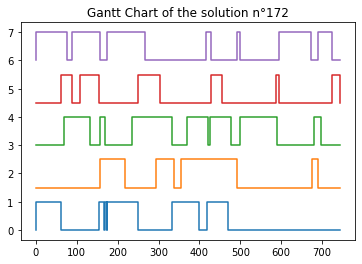

Makespan of the solution n°172 : 744
Regularity of the solution n°172 : 3906
Objective function of the solution n°172 : 2906064


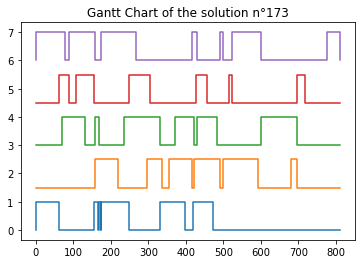

Makespan of the solution n°173 : 811
Regularity of the solution n°173 : 3586
Objective function of the solution n°173 : 2908246


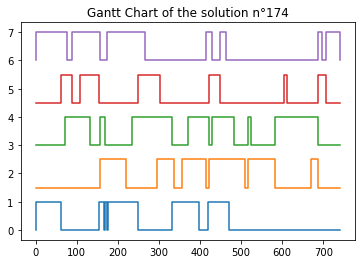

Makespan of the solution n°174 : 741
Regularity of the solution n°174 : 3932
Objective function of the solution n°174 : 2913612


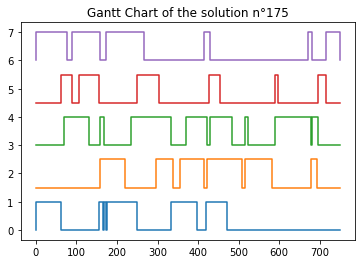

Makespan of the solution n°175 : 750
Regularity of the solution n°175 : 3886
Objective function of the solution n°175 : 2914500


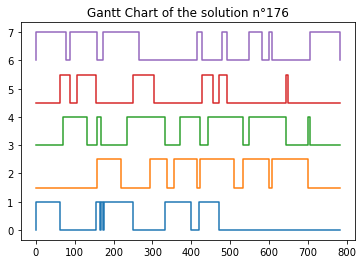

Makespan of the solution n°176 : 783
Regularity of the solution n°176 : 3750
Objective function of the solution n°176 : 2936250


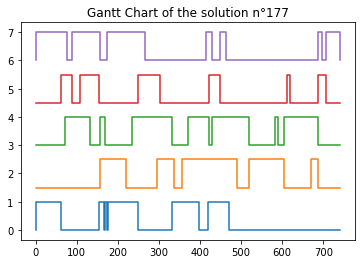

Makespan of the solution n°177 : 741
Regularity of the solution n°177 : 3964
Objective function of the solution n°177 : 2937324


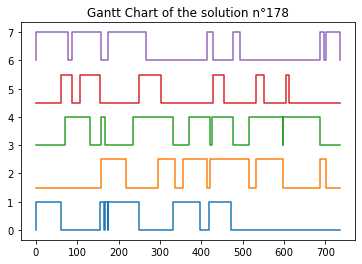

Makespan of the solution n°178 : 736
Regularity of the solution n°178 : 3994
Objective function of the solution n°178 : 2939584


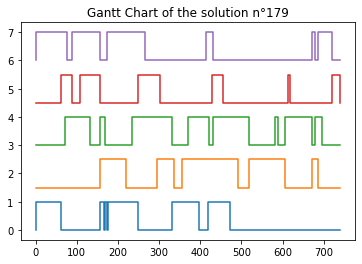

Makespan of the solution n°179 : 740
Regularity of the solution n°179 : 3974
Objective function of the solution n°179 : 2940760


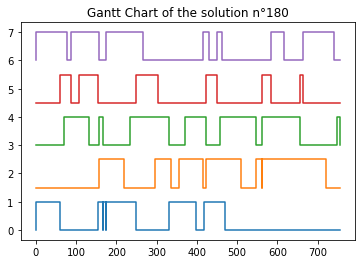

Makespan of the solution n°180 : 756
Regularity of the solution n°180 : 3892
Objective function of the solution n°180 : 2942352


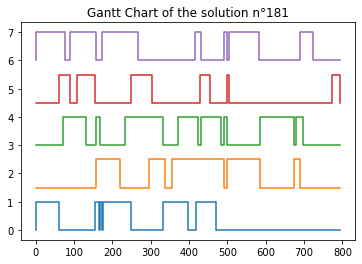

Makespan of the solution n°181 : 794
Regularity of the solution n°181 : 3738
Objective function of the solution n°181 : 2967972


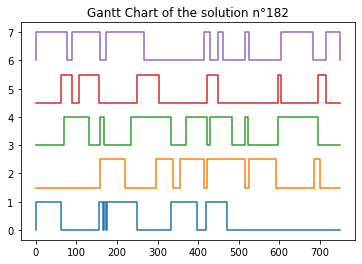

Makespan of the solution n°182 : 750
Regularity of the solution n°182 : 3980
Objective function of the solution n°182 : 2985000


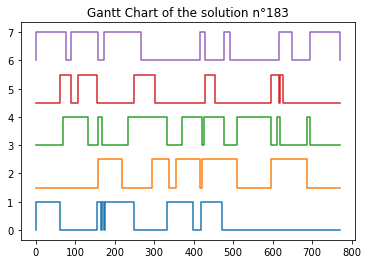

Makespan of the solution n°183 : 771
Regularity of the solution n°183 : 3872
Objective function of the solution n°183 : 2985312


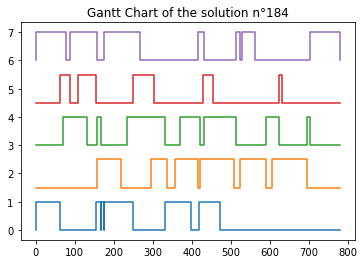

Makespan of the solution n°184 : 780
Regularity of the solution n°184 : 3828
Objective function of the solution n°184 : 2985840


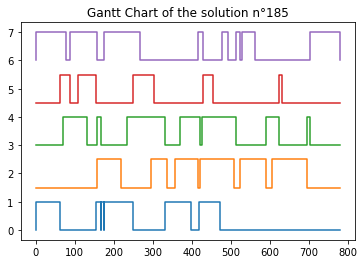

Makespan of the solution n°185 : 780
Regularity of the solution n°185 : 3828
Objective function of the solution n°185 : 2985840


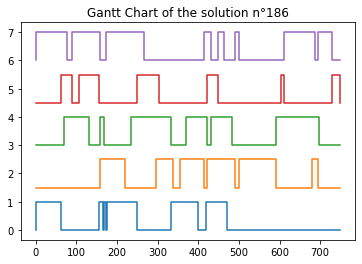

Makespan of the solution n°186 : 749
Regularity of the solution n°186 : 4000
Objective function of the solution n°186 : 2996000


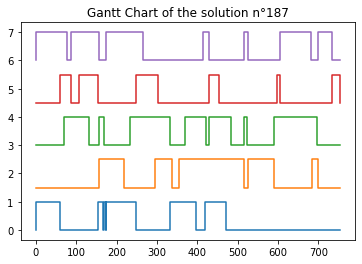

Makespan of the solution n°187 : 754
Regularity of the solution n°187 : 3974
Objective function of the solution n°187 : 2996396


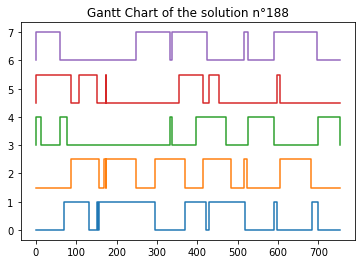

Makespan of the solution n°188 : 754
Regularity of the solution n°188 : 3974
Objective function of the solution n°188 : 2996396


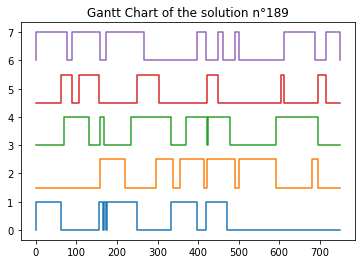

Makespan of the solution n°189 : 750
Regularity of the solution n°189 : 4004
Objective function of the solution n°189 : 3003000


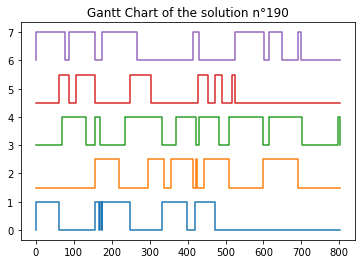

Makespan of the solution n°190 : 802
Regularity of the solution n°190 : 3748
Objective function of the solution n°190 : 3005896


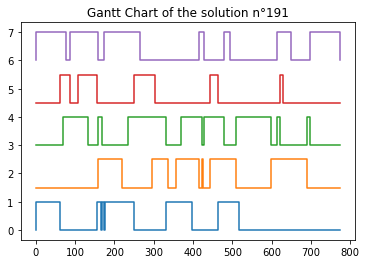

Makespan of the solution n°191 : 774
Regularity of the solution n°191 : 3890
Objective function of the solution n°191 : 3010860


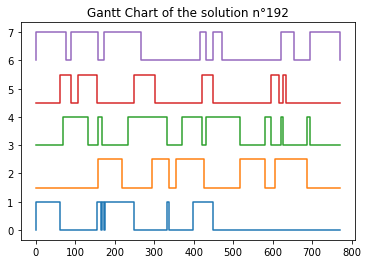

Makespan of the solution n°192 : 771
Regularity of the solution n°192 : 3906
Objective function of the solution n°192 : 3011526


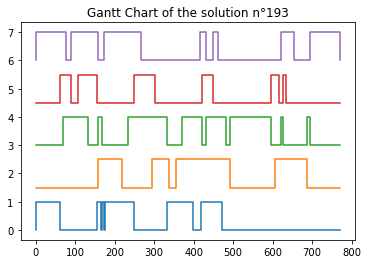

Makespan of the solution n°193 : 771
Regularity of the solution n°193 : 3906
Objective function of the solution n°193 : 3011526


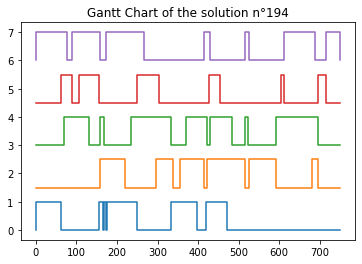

Makespan of the solution n°194 : 750
Regularity of the solution n°194 : 4018
Objective function of the solution n°194 : 3013500


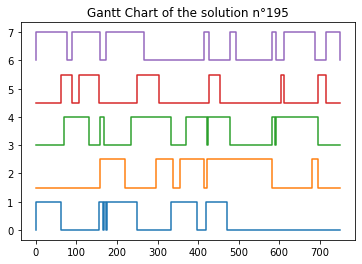

Makespan of the solution n°195 : 750
Regularity of the solution n°195 : 4018
Objective function of the solution n°195 : 3013500


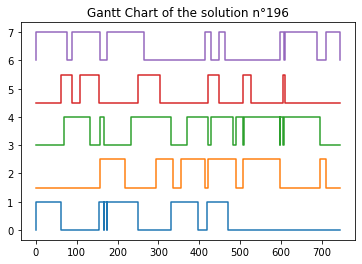

Makespan of the solution n°196 : 745
Regularity of the solution n°196 : 4048
Objective function of the solution n°196 : 3015760


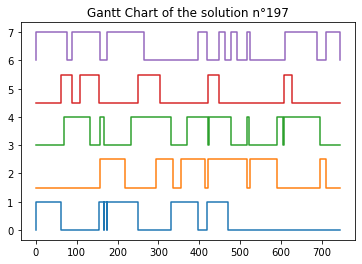

Makespan of the solution n°197 : 745
Regularity of the solution n°197 : 4048
Objective function of the solution n°197 : 3015760


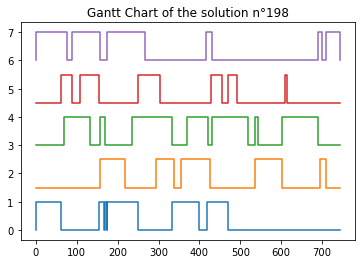

Makespan of the solution n°198 : 744
Regularity of the solution n°198 : 4060
Objective function of the solution n°198 : 3020640


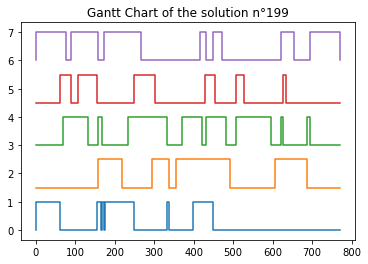

Makespan of the solution n°199 : 771
Regularity of the solution n°199 : 3920
Objective function of the solution n°199 : 3022320


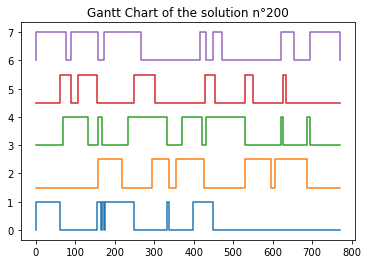

Makespan of the solution n°200 : 771
Regularity of the solution n°200 : 3920
Objective function of the solution n°200 : 3022320


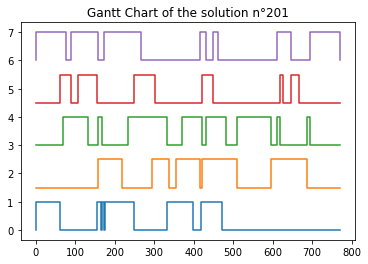

Makespan of the solution n°201 : 771
Regularity of the solution n°201 : 3922
Objective function of the solution n°201 : 3023862


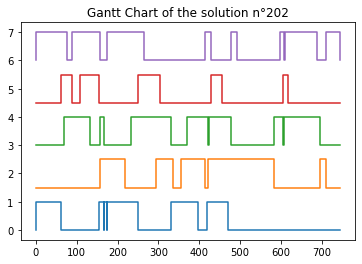

Makespan of the solution n°202 : 745
Regularity of the solution n°202 : 4062
Objective function of the solution n°202 : 3026190


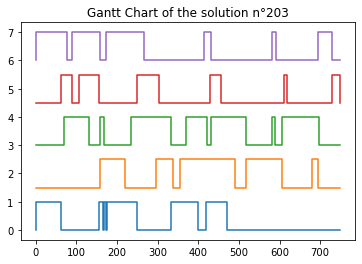

Makespan of the solution n°203 : 749
Regularity of the solution n°203 : 4046
Objective function of the solution n°203 : 3030454


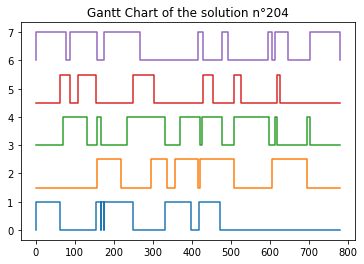

Makespan of the solution n°204 : 780
Regularity of the solution n°204 : 3892
Objective function of the solution n°204 : 3035760


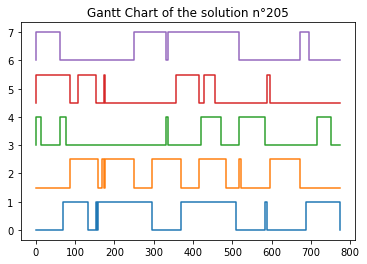

Makespan of the solution n°205 : 774
Regularity of the solution n°205 : 4048
Objective function of the solution n°205 : 3036000


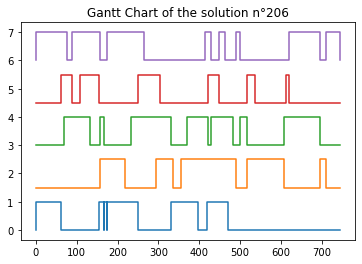

Makespan of the solution n°206 : 745
Regularity of the solution n°206 : 4080
Objective function of the solution n°206 : 3039600


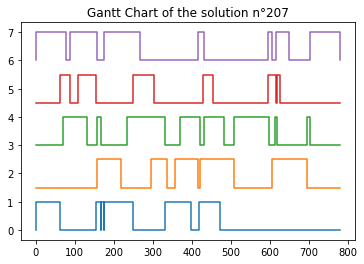

Makespan of the solution n°207 : 780
Regularity of the solution n°207 : 3908
Objective function of the solution n°207 : 3048240


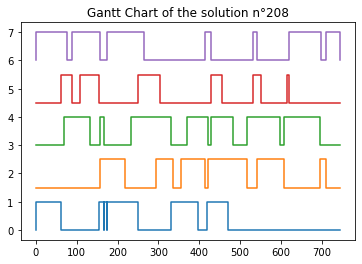

Makespan of the solution n°208 : 745
Regularity of the solution n°208 : 4102
Objective function of the solution n°208 : 3055990


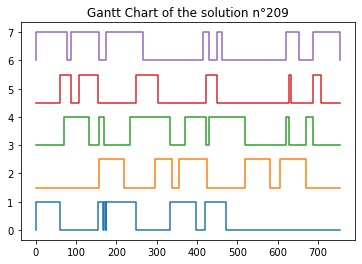

Makespan of the solution n°209 : 755
Regularity of the solution n°209 : 4054
Objective function of the solution n°209 : 3060770


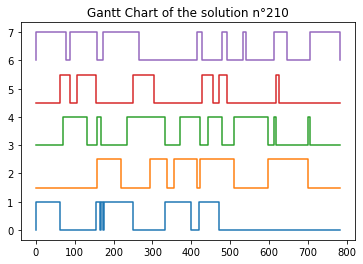

Makespan of the solution n°210 : 783
Regularity of the solution n°210 : 3910
Objective function of the solution n°210 : 3061530


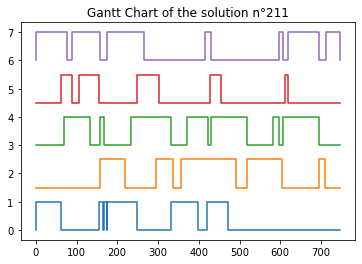

Makespan of the solution n°211 : 747
Regularity of the solution n°211 : 4102
Objective function of the solution n°211 : 3064194


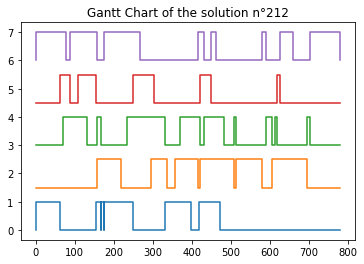

Makespan of the solution n°212 : 780
Regularity of the solution n°212 : 3930
Objective function of the solution n°212 : 3065400


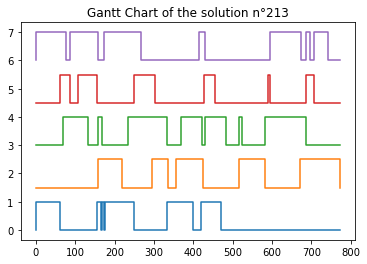

Makespan of the solution n°213 : 773
Regularity of the solution n°213 : 3976
Objective function of the solution n°213 : 3073448


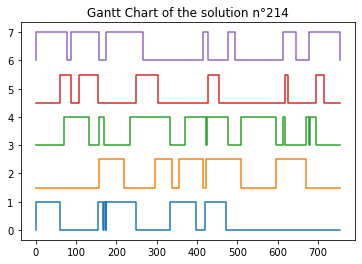

Makespan of the solution n°214 : 755
Regularity of the solution n°214 : 4072
Objective function of the solution n°214 : 3074360


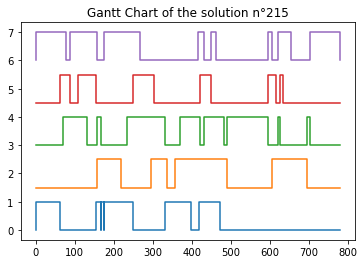

Makespan of the solution n°215 : 780
Regularity of the solution n°215 : 3942
Objective function of the solution n°215 : 3074760


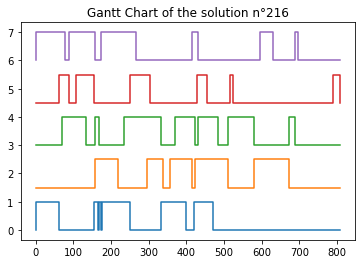

Makespan of the solution n°216 : 808
Regularity of the solution n°216 : 3810
Objective function of the solution n°216 : 3078480


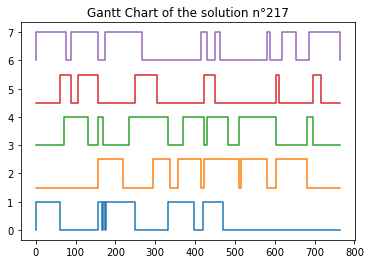

Makespan of the solution n°217 : 764
Regularity of the solution n°217 : 4034
Objective function of the solution n°217 : 3081976


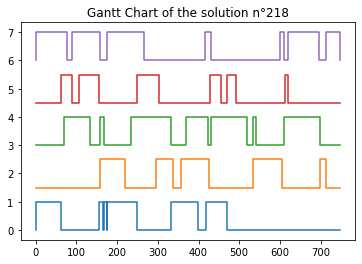

Makespan of the solution n°218 : 748
Regularity of the solution n°218 : 4124
Objective function of the solution n°218 : 3084752


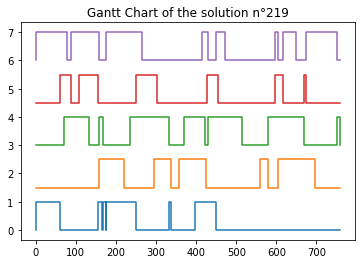

Makespan of the solution n°219 : 759
Regularity of the solution n°219 : 4068
Objective function of the solution n°219 : 3087612


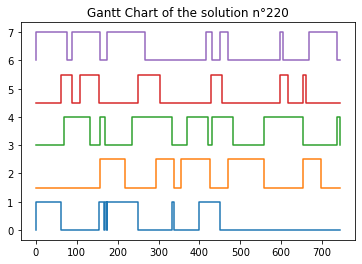

Makespan of the solution n°220 : 744
Regularity of the solution n°220 : 4156
Objective function of the solution n°220 : 3092064


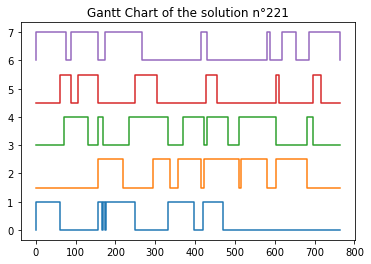

Makespan of the solution n°221 : 764
Regularity of the solution n°221 : 4048
Objective function of the solution n°221 : 3092672


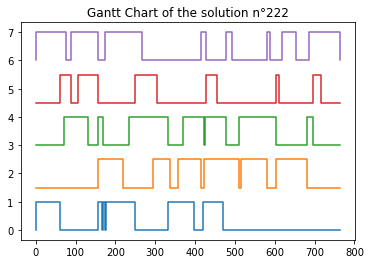

Makespan of the solution n°222 : 764
Regularity of the solution n°222 : 4048
Objective function of the solution n°222 : 3092672


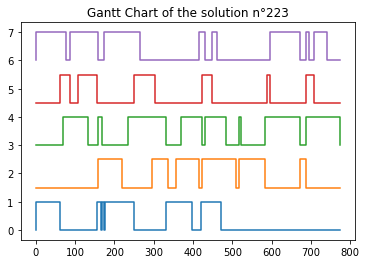

Makespan of the solution n°223 : 774
Regularity of the solution n°223 : 3998
Objective function of the solution n°223 : 3094452


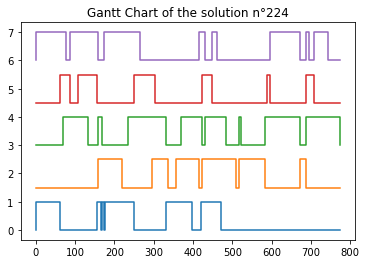

Makespan of the solution n°224 : 774
Regularity of the solution n°224 : 4002
Objective function of the solution n°224 : 3097548


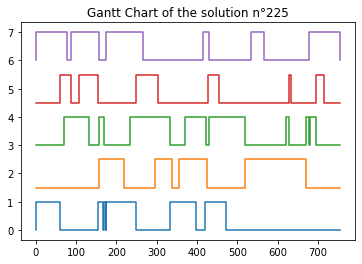

Makespan of the solution n°225 : 755
Regularity of the solution n°225 : 4104
Objective function of the solution n°225 : 3098520


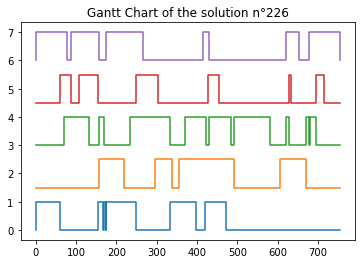

Makespan of the solution n°226 : 755
Regularity of the solution n°226 : 4104
Objective function of the solution n°226 : 3098520


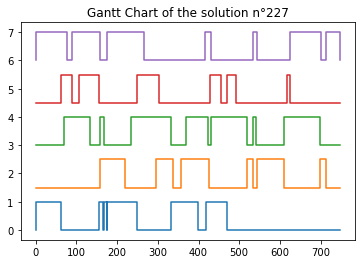

Makespan of the solution n°227 : 748
Regularity of the solution n°227 : 4144
Objective function of the solution n°227 : 3099712


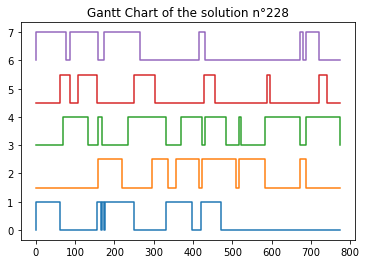

Makespan of the solution n°228 : 774
Regularity of the solution n°228 : 4008
Objective function of the solution n°228 : 3102192


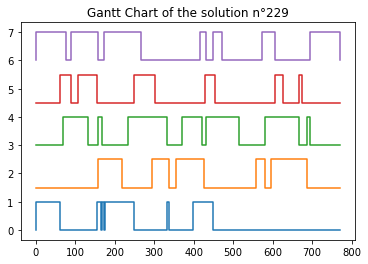

Makespan of the solution n°229 : 771
Regularity of the solution n°229 : 4024
Objective function of the solution n°229 : 3102504


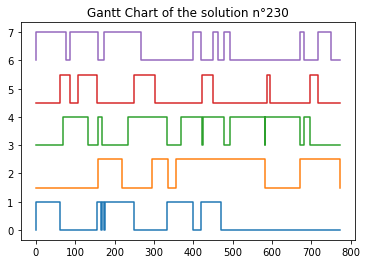

Makespan of the solution n°230 : 773
Regularity of the solution n°230 : 4022
Objective function of the solution n°230 : 3109006


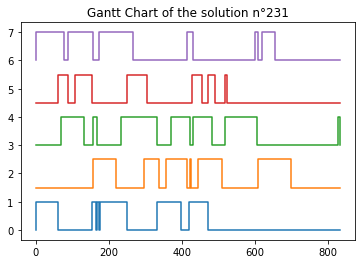

Makespan of the solution n°231 : 833
Regularity of the solution n°231 : 3734
Objective function of the solution n°231 : 3110422


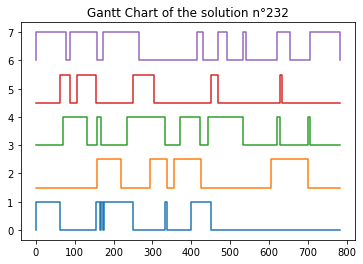

Makespan of the solution n°232 : 783
Regularity of the solution n°232 : 3974
Objective function of the solution n°232 : 3111642


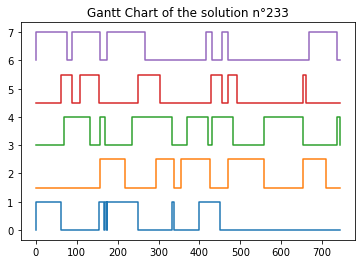

Makespan of the solution n°233 : 744
Regularity of the solution n°233 : 4184
Objective function of the solution n°233 : 3112896


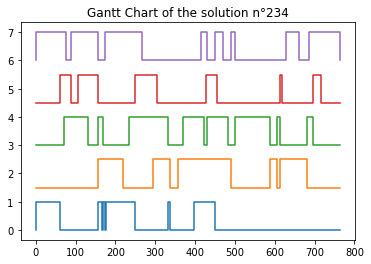

Makespan of the solution n°234 : 764
Regularity of the solution n°234 : 4080
Objective function of the solution n°234 : 3117120


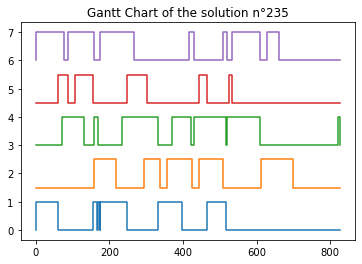

Makespan of the solution n°235 : 827
Regularity of the solution n°235 : 3770
Objective function of the solution n°235 : 3117790


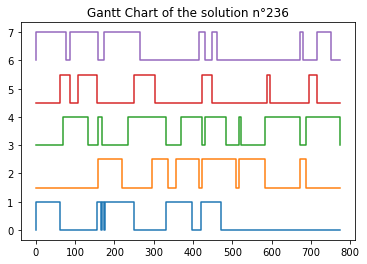

Makespan of the solution n°236 : 774
Regularity of the solution n°236 : 4034
Objective function of the solution n°236 : 3122316


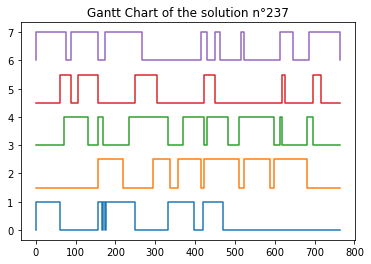

Makespan of the solution n°237 : 764
Regularity of the solution n°237 : 4094
Objective function of the solution n°237 : 3127816


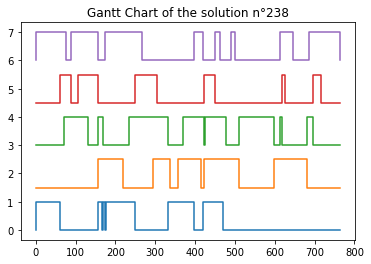

Makespan of the solution n°238 : 764
Regularity of the solution n°238 : 4094
Objective function of the solution n°238 : 3127816


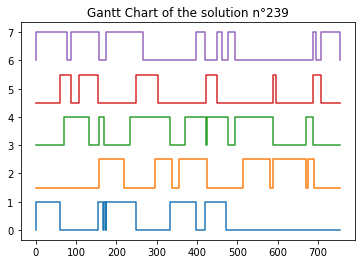

Makespan of the solution n°239 : 755
Regularity of the solution n°239 : 4152
Objective function of the solution n°239 : 3134760


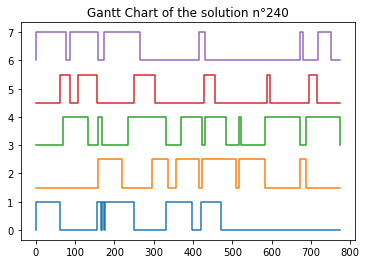

Makespan of the solution n°240 : 774
Regularity of the solution n°240 : 4052
Objective function of the solution n°240 : 3136248


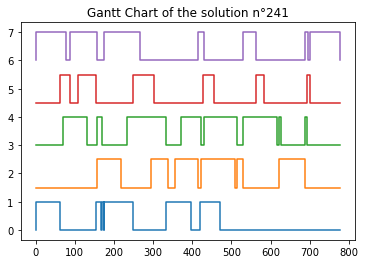

Makespan of the solution n°241 : 778
Regularity of the solution n°241 : 4046
Objective function of the solution n°241 : 3147788


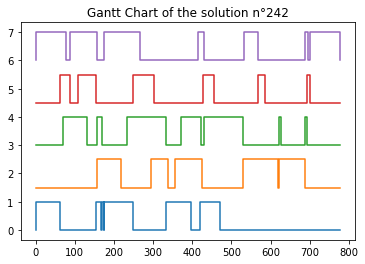

Makespan of the solution n°242 : 778
Regularity of the solution n°242 : 4050
Objective function of the solution n°242 : 3150900


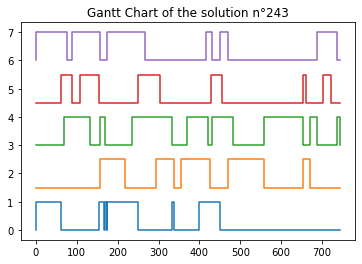

Makespan of the solution n°243 : 744
Regularity of the solution n°243 : 4236
Objective function of the solution n°243 : 3151584


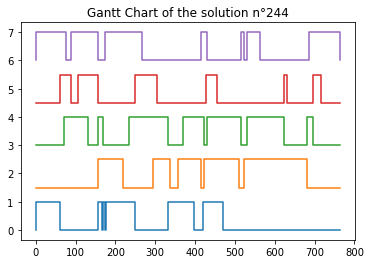

Makespan of the solution n°244 : 764
Regularity of the solution n°244 : 4128
Objective function of the solution n°244 : 3153792


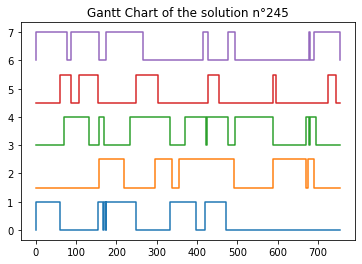

Makespan of the solution n°245 : 755
Regularity of the solution n°245 : 4178
Objective function of the solution n°245 : 3154390


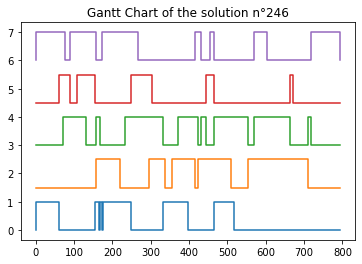

Makespan of the solution n°246 : 794
Regularity of the solution n°246 : 4014
Objective function of the solution n°246 : 3187116


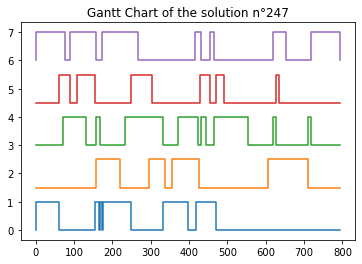

Makespan of the solution n°247 : 794
Regularity of the solution n°247 : 4040
Objective function of the solution n°247 : 3207760


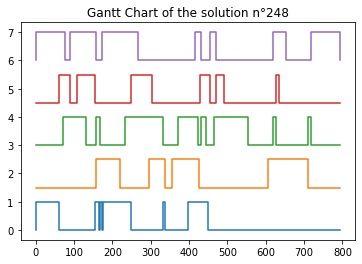

Makespan of the solution n°248 : 794
Regularity of the solution n°248 : 4040
Objective function of the solution n°248 : 3207760


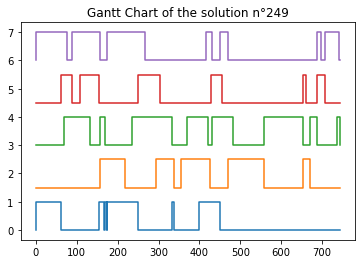

Makespan of the solution n°249 : 744
Regularity of the solution n°249 : 4312
Objective function of the solution n°249 : 3208128


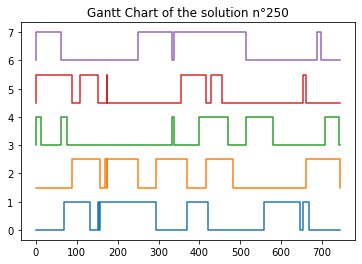

Makespan of the solution n°250 : 744
Regularity of the solution n°250 : 4312
Objective function of the solution n°250 : 3208128


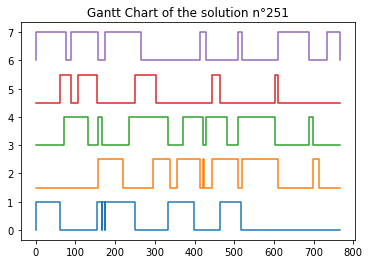

Makespan of the solution n°251 : 767
Regularity of the solution n°251 : 4196
Objective function of the solution n°251 : 3218332


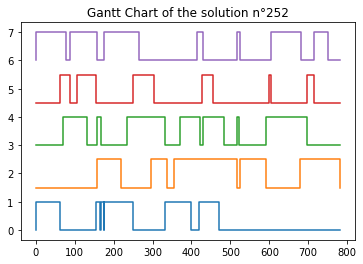

Makespan of the solution n°252 : 782
Regularity of the solution n°252 : 4120
Objective function of the solution n°252 : 3221840


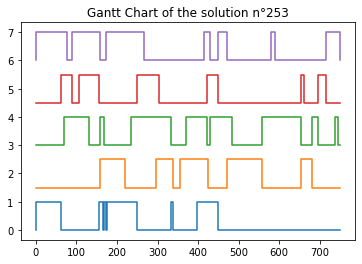

Makespan of the solution n°253 : 750
Regularity of the solution n°253 : 4334
Objective function of the solution n°253 : 3250500


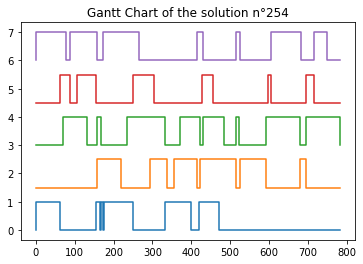

Makespan of the solution n°254 : 783
Regularity of the solution n°254 : 4156
Objective function of the solution n°254 : 3254148


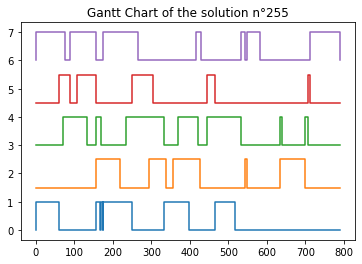

Makespan of the solution n°255 : 790
Regularity of the solution n°255 : 4120
Objective function of the solution n°255 : 3254800


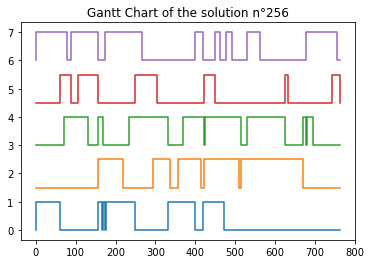

Makespan of the solution n°256 : 763
Regularity of the solution n°256 : 4266
Objective function of the solution n°256 : 3254958


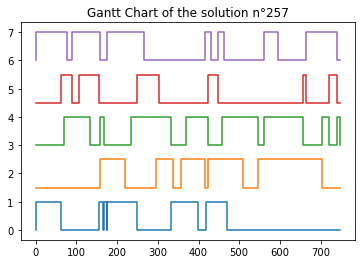

Makespan of the solution n°257 : 748
Regularity of the solution n°257 : 4352
Objective function of the solution n°257 : 3255296


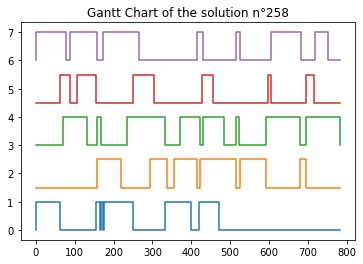

Makespan of the solution n°258 : 783
Regularity of the solution n°258 : 4160
Objective function of the solution n°258 : 3257280


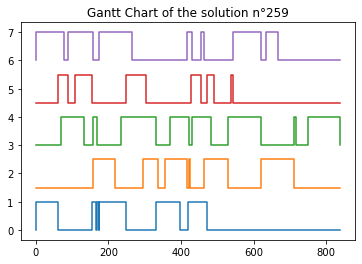

Makespan of the solution n°259 : 838
Regularity of the solution n°259 : 3888
Objective function of the solution n°259 : 3258144


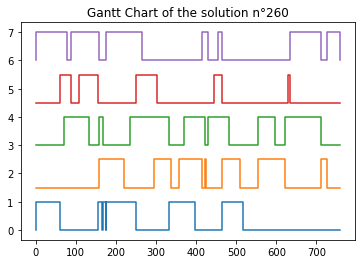

Makespan of the solution n°260 : 759
Regularity of the solution n°260 : 4298
Objective function of the solution n°260 : 3262182


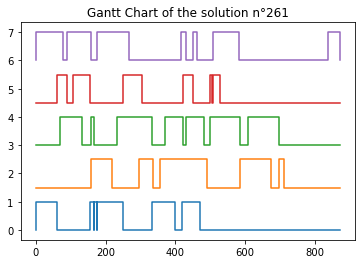

Makespan of the solution n°261 : 872
Regularity of the solution n°261 : 3744
Objective function of the solution n°261 : 3264768


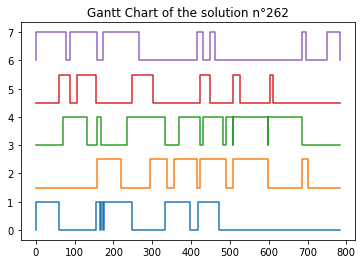

Makespan of the solution n°262 : 784
Regularity of the solution n°262 : 4168
Objective function of the solution n°262 : 3267712


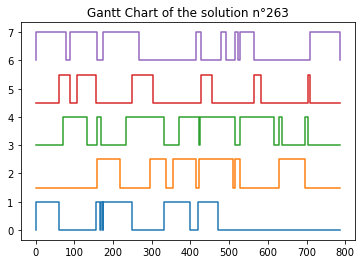

Makespan of the solution n°263 : 787
Regularity of the solution n°263 : 4154
Objective function of the solution n°263 : 3269198


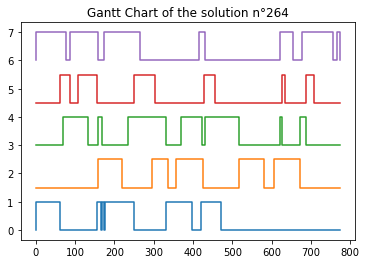

Makespan of the solution n°264 : 774
Regularity of the solution n°264 : 4224
Objective function of the solution n°264 : 3269376


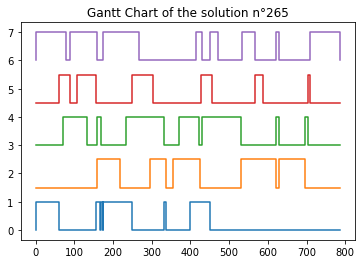

Makespan of the solution n°265 : 787
Regularity of the solution n°265 : 4158
Objective function of the solution n°265 : 3272346


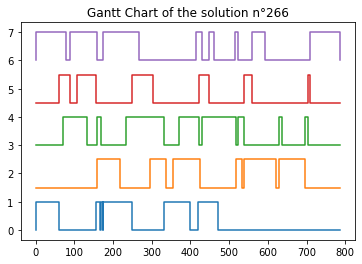

Makespan of the solution n°266 : 787
Regularity of the solution n°266 : 4168
Objective function of the solution n°266 : 3280216


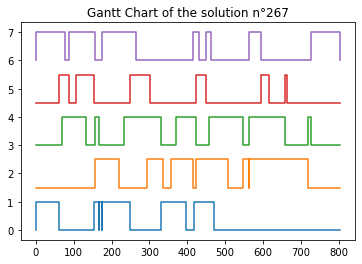

Makespan of the solution n°267 : 804
Regularity of the solution n°267 : 4080
Objective function of the solution n°267 : 3280320


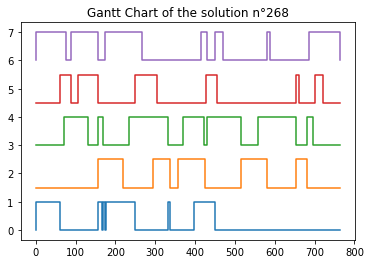

Makespan of the solution n°268 : 764
Regularity of the solution n°268 : 4316
Objective function of the solution n°268 : 3297424


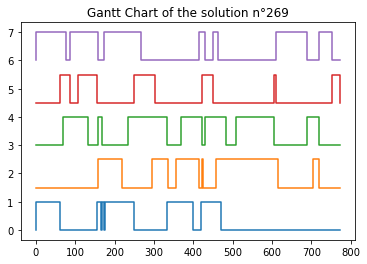

Makespan of the solution n°269 : 773
Regularity of the solution n°269 : 4268
Objective function of the solution n°269 : 3299164


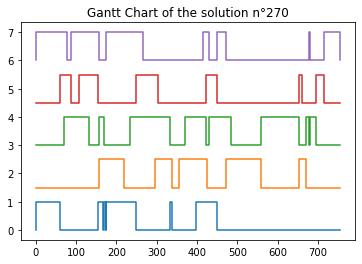

Makespan of the solution n°270 : 755
Regularity of the solution n°270 : 4378
Objective function of the solution n°270 : 3305390


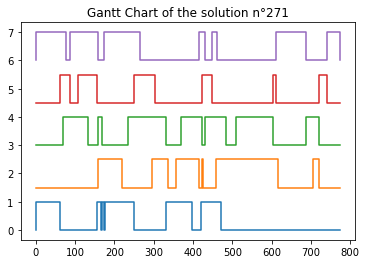

Makespan of the solution n°271 : 774
Regularity of the solution n°271 : 4272
Objective function of the solution n°271 : 3306528


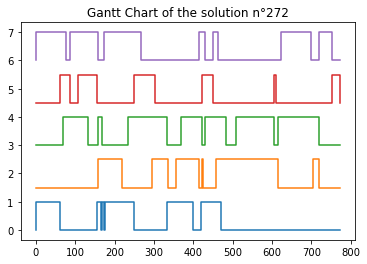

Makespan of the solution n°272 : 773
Regularity of the solution n°272 : 4284
Objective function of the solution n°272 : 3311532


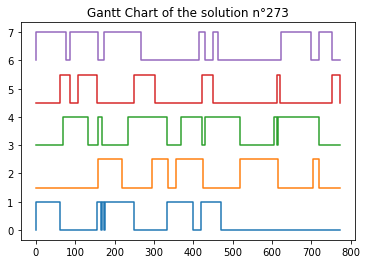

Makespan of the solution n°273 : 773
Regularity of the solution n°273 : 4284
Objective function of the solution n°273 : 3311532


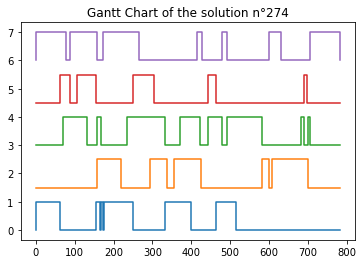

Makespan of the solution n°274 : 783
Regularity of the solution n°274 : 4248
Objective function of the solution n°274 : 3326184


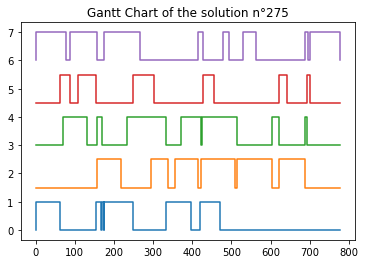

Makespan of the solution n°275 : 778
Regularity of the solution n°275 : 4278
Objective function of the solution n°275 : 3328284


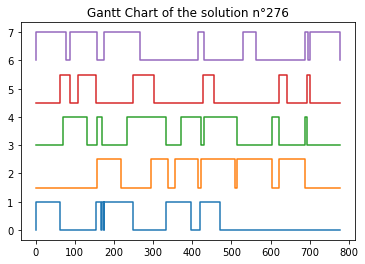

Makespan of the solution n°276 : 778
Regularity of the solution n°276 : 4278
Objective function of the solution n°276 : 3328284


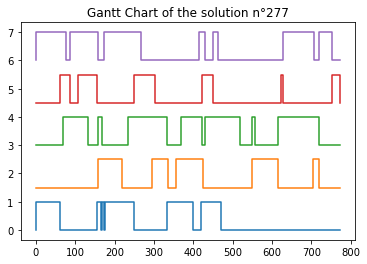

Makespan of the solution n°277 : 773
Regularity of the solution n°277 : 4312
Objective function of the solution n°277 : 3333176


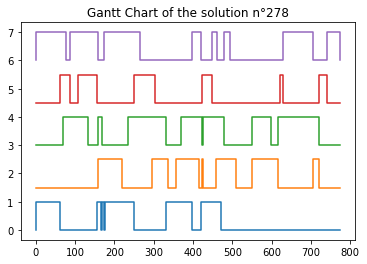

Makespan of the solution n°278 : 774
Regularity of the solution n°278 : 4316
Objective function of the solution n°278 : 3340584


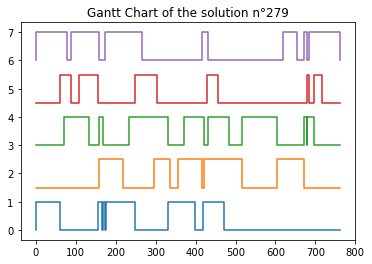

Makespan of the solution n°279 : 762
Regularity of the solution n°279 : 4388
Objective function of the solution n°279 : 3343656


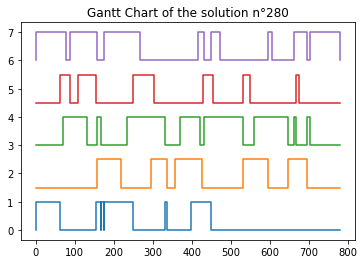

Makespan of the solution n°280 : 780
Regularity of the solution n°280 : 4332
Objective function of the solution n°280 : 3378960


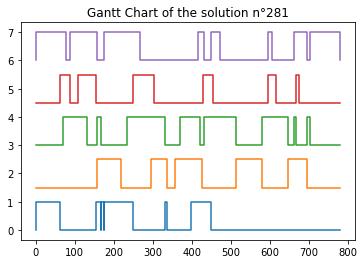

Makespan of the solution n°281 : 780
Regularity of the solution n°281 : 4332
Objective function of the solution n°281 : 3378960


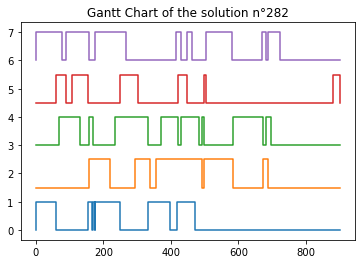

Makespan of the solution n°282 : 901
Regularity of the solution n°282 : 3760
Objective function of the solution n°282 : 3387760


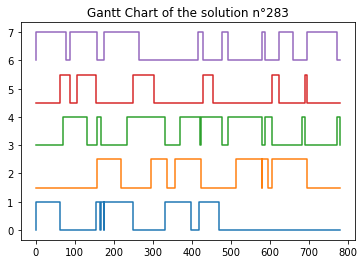

Makespan of the solution n°283 : 781
Regularity of the solution n°283 : 4350
Objective function of the solution n°283 : 3397350


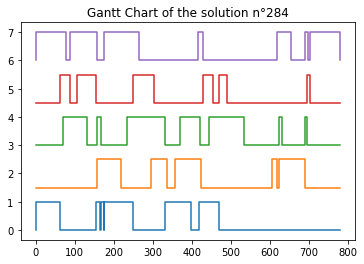

Makespan of the solution n°284 : 781
Regularity of the solution n°284 : 4360
Objective function of the solution n°284 : 3405160


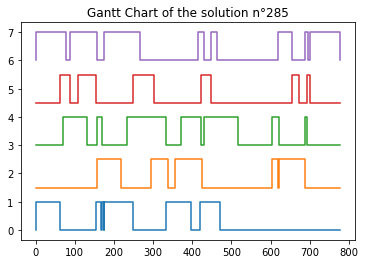

Makespan of the solution n°285 : 778
Regularity of the solution n°285 : 4384
Objective function of the solution n°285 : 3410752


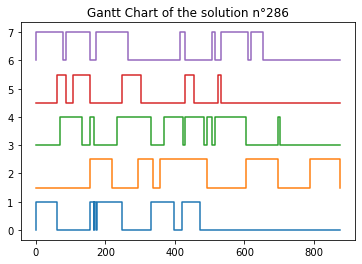

Makespan of the solution n°286 : 875
Regularity of the solution n°286 : 3900
Objective function of the solution n°286 : 3412500


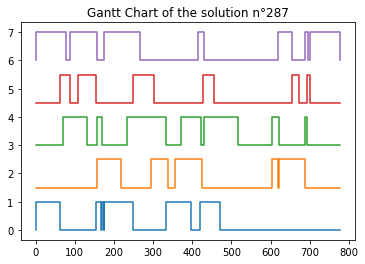

Makespan of the solution n°287 : 778
Regularity of the solution n°287 : 4398
Objective function of the solution n°287 : 3421644


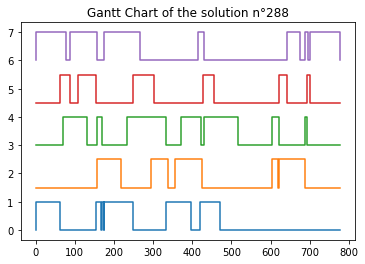

Makespan of the solution n°288 : 778
Regularity of the solution n°288 : 4402
Objective function of the solution n°288 : 3424756


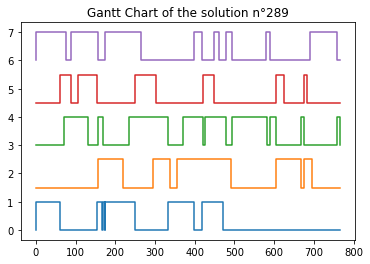

Makespan of the solution n°289 : 766
Regularity of the solution n°289 : 4476
Objective function of the solution n°289 : 3428616


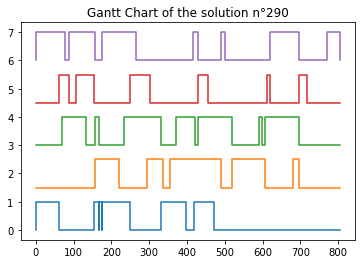

Makespan of the solution n°290 : 805
Regularity of the solution n°290 : 4270
Objective function of the solution n°290 : 3437350


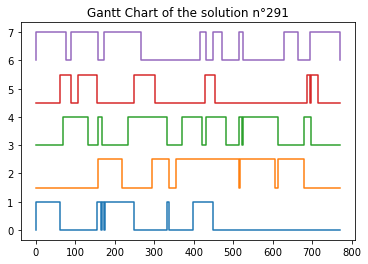

Makespan of the solution n°291 : 771
Regularity of the solution n°291 : 4460
Objective function of the solution n°291 : 3438660


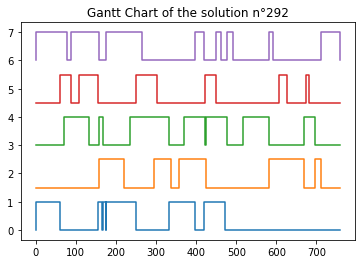

Makespan of the solution n°292 : 759
Regularity of the solution n°292 : 4532
Objective function of the solution n°292 : 3439788


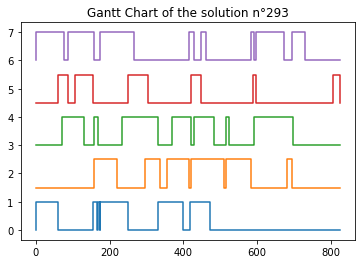

Makespan of the solution n°293 : 825
Regularity of the solution n°293 : 4172
Objective function of the solution n°293 : 3441900


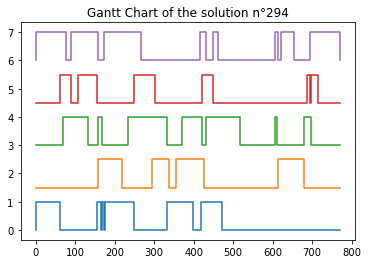

Makespan of the solution n°294 : 771
Regularity of the solution n°294 : 4468
Objective function of the solution n°294 : 3444828


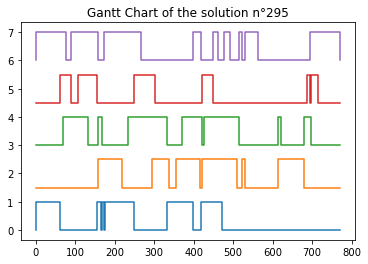

Makespan of the solution n°295 : 771
Regularity of the solution n°295 : 4480
Objective function of the solution n°295 : 3454080


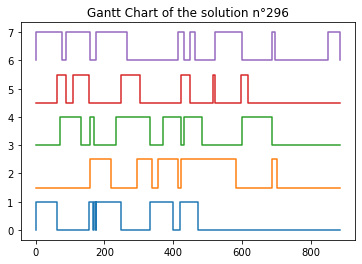

Makespan of the solution n°296 : 886
Regularity of the solution n°296 : 3900
Objective function of the solution n°296 : 3455400


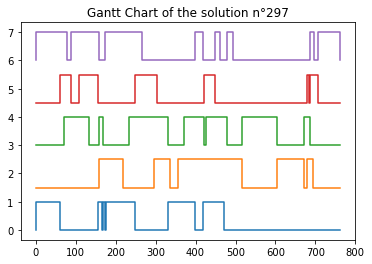

Makespan of the solution n°297 : 762
Regularity of the solution n°297 : 4540
Objective function of the solution n°297 : 3459480


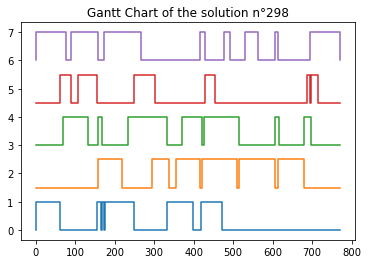

Makespan of the solution n°298 : 771
Regularity of the solution n°298 : 4494
Objective function of the solution n°298 : 3464874


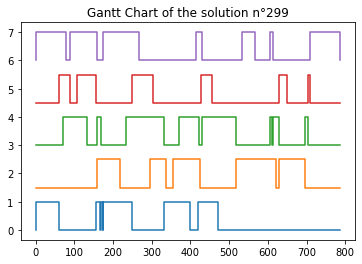

Makespan of the solution n°299 : 787
Regularity of the solution n°299 : 4410
Objective function of the solution n°299 : 3470670


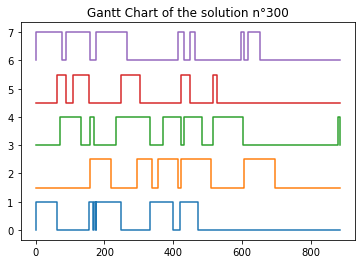

Makespan of the solution n°300 : 886
Regularity of the solution n°300 : 3918
Objective function of the solution n°300 : 3471348


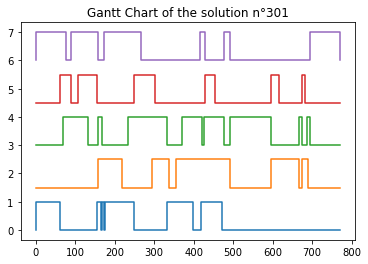

Makespan of the solution n°301 : 771
Regularity of the solution n°301 : 4510
Objective function of the solution n°301 : 3477210


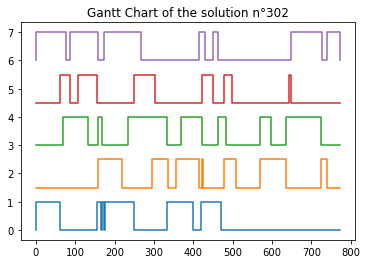

Makespan of the solution n°302 : 773
Regularity of the solution n°302 : 4506
Objective function of the solution n°302 : 3483138


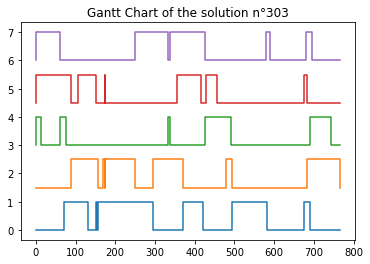

Makespan of the solution n°303 : 766
Regularity of the solution n°303 : 4570
Objective function of the solution n°303 : 3500620


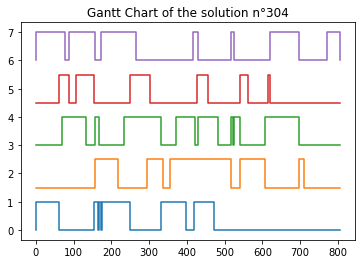

Makespan of the solution n°304 : 806
Regularity of the solution n°304 : 4346
Objective function of the solution n°304 : 3502876


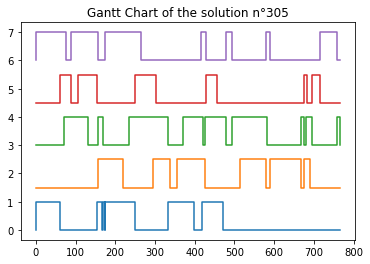

Makespan of the solution n°305 : 766
Regularity of the solution n°305 : 4594
Objective function of the solution n°305 : 3519004


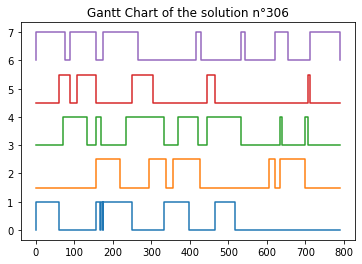

Makespan of the solution n°306 : 790
Regularity of the solution n°306 : 4468
Objective function of the solution n°306 : 3529720


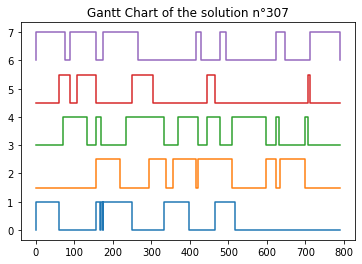

Makespan of the solution n°307 : 790
Regularity of the solution n°307 : 4468
Objective function of the solution n°307 : 3529720


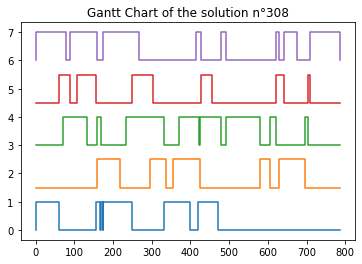

Makespan of the solution n°308 : 787
Regularity of the solution n°308 : 4490
Objective function of the solution n°308 : 3533630


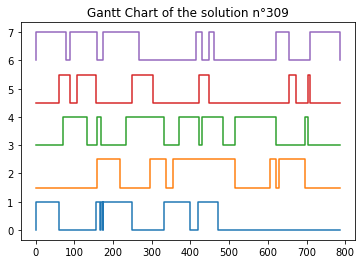

Makespan of the solution n°309 : 787
Regularity of the solution n°309 : 4492
Objective function of the solution n°309 : 3535204


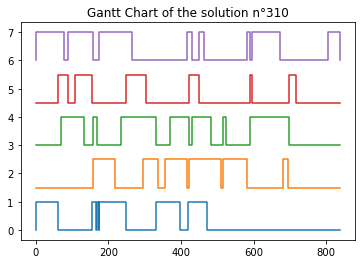

Makespan of the solution n°310 : 838
Regularity of the solution n°310 : 4224
Objective function of the solution n°310 : 3539712


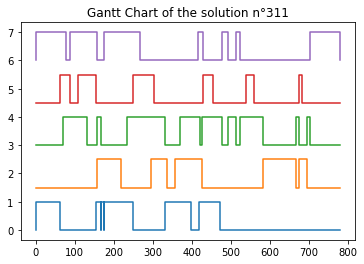

Makespan of the solution n°311 : 780
Regularity of the solution n°311 : 4546
Objective function of the solution n°311 : 3545880


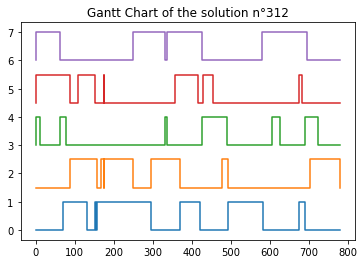

Makespan of the solution n°312 : 780
Regularity of the solution n°312 : 4546
Objective function of the solution n°312 : 3545880


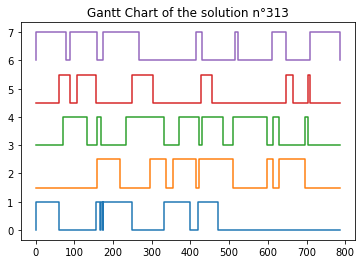

Makespan of the solution n°313 : 787
Regularity of the solution n°313 : 4506
Objective function of the solution n°313 : 3546222


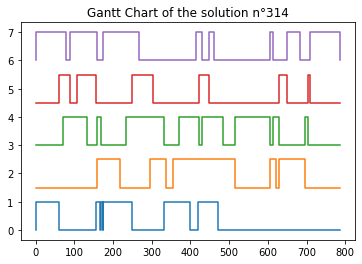

Makespan of the solution n°314 : 787
Regularity of the solution n°314 : 4532
Objective function of the solution n°314 : 3566684


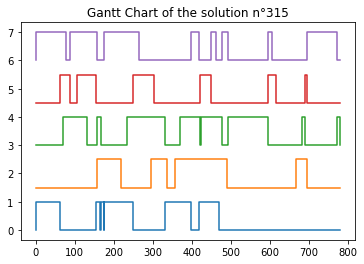

Makespan of the solution n°315 : 781
Regularity of the solution n°315 : 4568
Objective function of the solution n°315 : 3567608


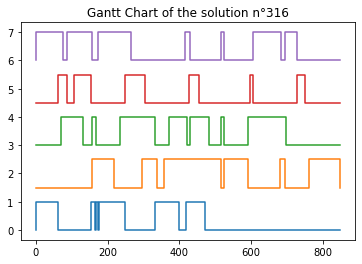

Makespan of the solution n°316 : 848
Regularity of the solution n°316 : 4214
Objective function of the solution n°316 : 3573472


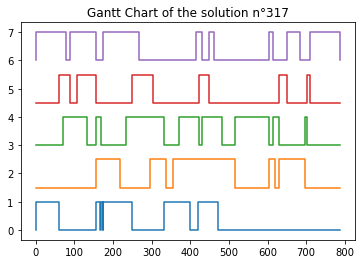

Makespan of the solution n°317 : 788
Regularity of the solution n°317 : 4536
Objective function of the solution n°317 : 3574368


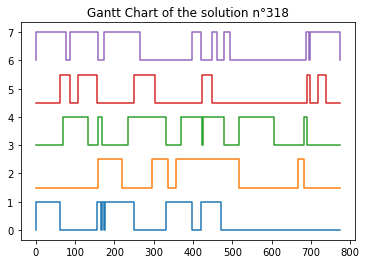

Makespan of the solution n°318 : 774
Regularity of the solution n°318 : 4620
Objective function of the solution n°318 : 3575880


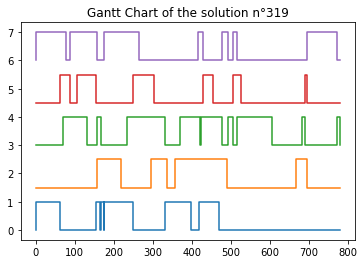

Makespan of the solution n°319 : 781
Regularity of the solution n°319 : 4582
Objective function of the solution n°319 : 3578542


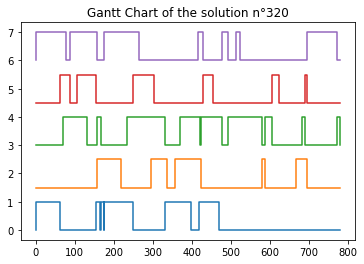

Makespan of the solution n°320 : 781
Regularity of the solution n°320 : 4582
Objective function of the solution n°320 : 3578542


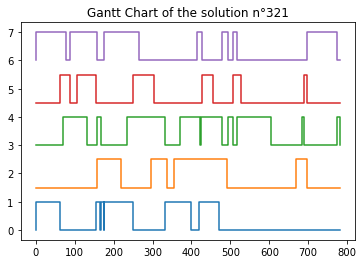

Makespan of the solution n°321 : 782
Regularity of the solution n°321 : 4586
Objective function of the solution n°321 : 3586252


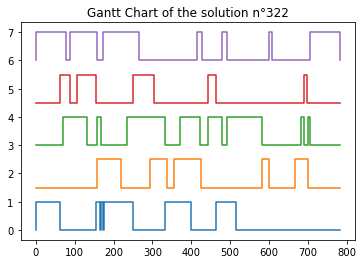

Makespan of the solution n°322 : 783
Regularity of the solution n°322 : 4596
Objective function of the solution n°322 : 3598668


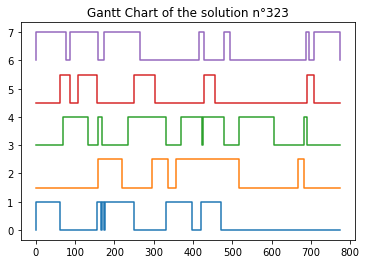

Makespan of the solution n°323 : 774
Regularity of the solution n°323 : 4650
Objective function of the solution n°323 : 3599100


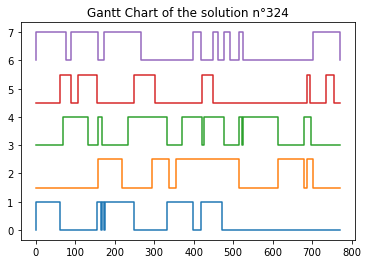

Makespan of the solution n°324 : 771
Regularity of the solution n°324 : 4672
Objective function of the solution n°324 : 3602112


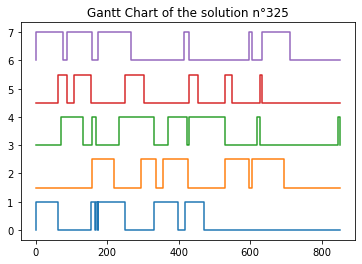

Makespan of the solution n°325 : 852
Regularity of the solution n°325 : 4244
Objective function of the solution n°325 : 3615888


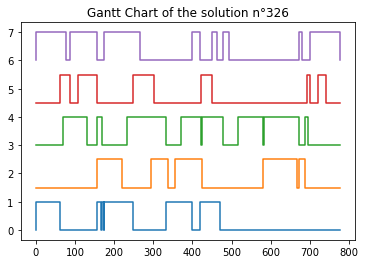

Makespan of the solution n°326 : 777
Regularity of the solution n°326 : 4656
Objective function of the solution n°326 : 3617712


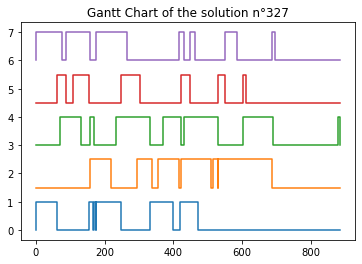

Makespan of the solution n°327 : 885
Regularity of the solution n°327 : 4088
Objective function of the solution n°327 : 3617880


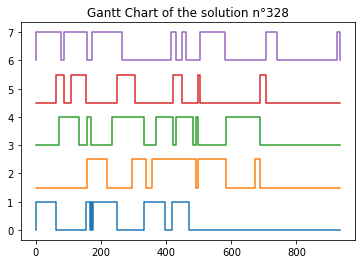

Makespan of the solution n°328 : 934
Regularity of the solution n°328 : 3876
Objective function of the solution n°328 : 3620184


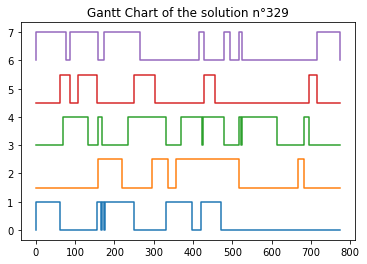

Makespan of the solution n°329 : 774
Regularity of the solution n°329 : 4686
Objective function of the solution n°329 : 3626964


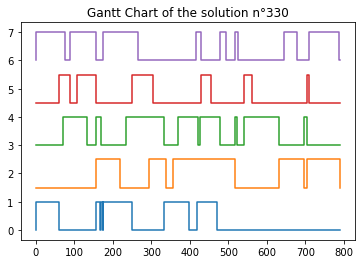

Makespan of the solution n°330 : 790
Regularity of the solution n°330 : 4606
Objective function of the solution n°330 : 3638740


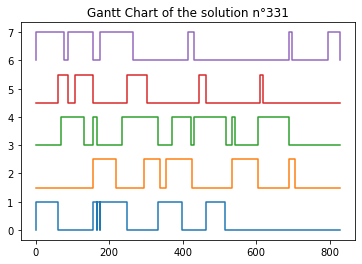

Makespan of the solution n°331 : 829
Regularity of the solution n°331 : 4412
Objective function of the solution n°331 : 3657548


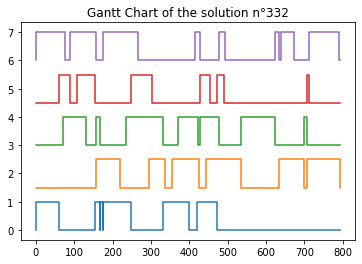

Makespan of the solution n°332 : 793
Regularity of the solution n°332 : 4622
Objective function of the solution n°332 : 3665246


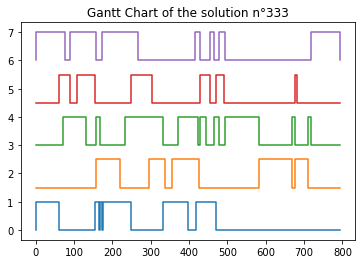

Makespan of the solution n°333 : 794
Regularity of the solution n°333 : 4630
Objective function of the solution n°333 : 3676220


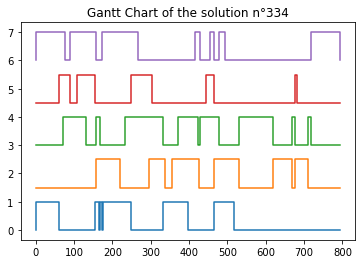

Makespan of the solution n°334 : 794
Regularity of the solution n°334 : 4630
Objective function of the solution n°334 : 3676220


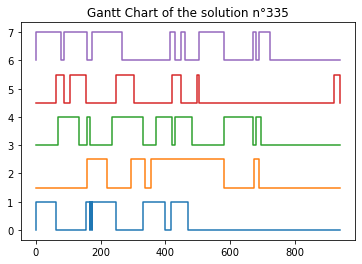

Makespan of the solution n°335 : 940
Regularity of the solution n°335 : 3916
Objective function of the solution n°335 : 3681040


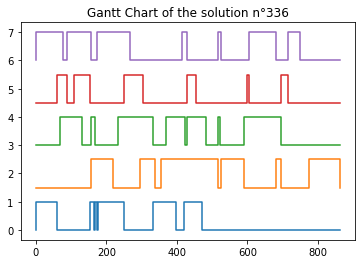

Makespan of the solution n°336 : 863
Regularity of the solution n°336 : 4278
Objective function of the solution n°336 : 3691914


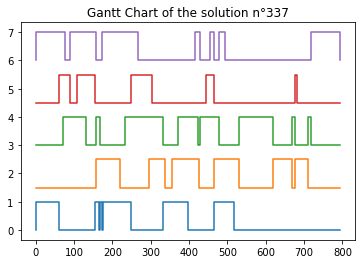

Makespan of the solution n°337 : 794
Regularity of the solution n°337 : 4650
Objective function of the solution n°337 : 3692100


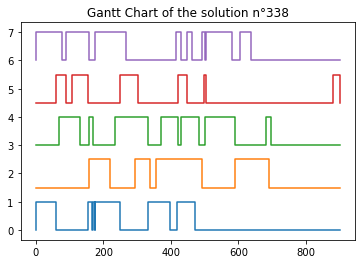

Makespan of the solution n°338 : 901
Regularity of the solution n°338 : 4152
Objective function of the solution n°338 : 3740952


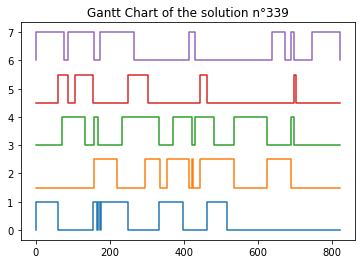

Makespan of the solution n°339 : 823
Regularity of the solution n°339 : 4546
Objective function of the solution n°339 : 3741358


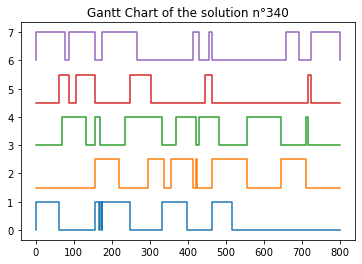

Makespan of the solution n°340 : 801
Regularity of the solution n°340 : 4680
Objective function of the solution n°340 : 3748680


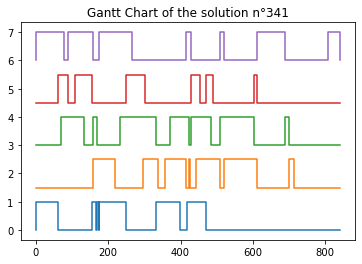

Makespan of the solution n°341 : 841
Regularity of the solution n°341 : 4492
Objective function of the solution n°341 : 3777772


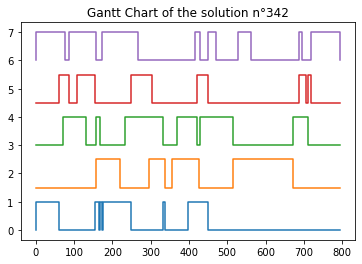

Makespan of the solution n°342 : 795
Regularity of the solution n°342 : 4752
Objective function of the solution n°342 : 3777840


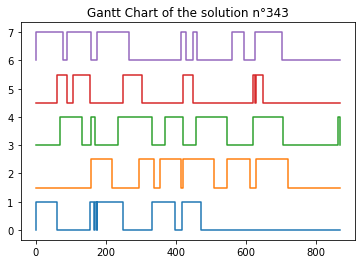

Makespan of the solution n°343 : 870
Regularity of the solution n°343 : 4380
Objective function of the solution n°343 : 3810600


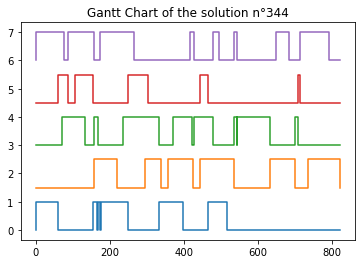

Makespan of the solution n°344 : 821
Regularity of the solution n°344 : 4660
Objective function of the solution n°344 : 3825860


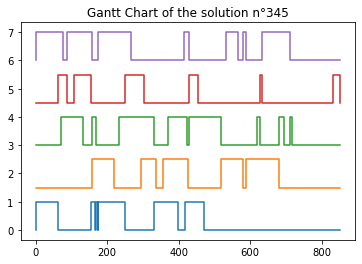

Makespan of the solution n°345 : 852
Regularity of the solution n°345 : 4500
Objective function of the solution n°345 : 3834000


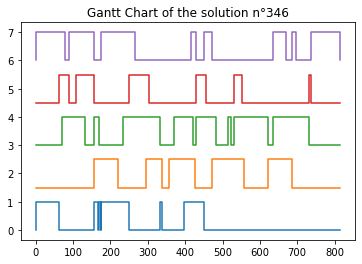

Makespan of the solution n°346 : 815
Regularity of the solution n°346 : 4710
Objective function of the solution n°346 : 3838650


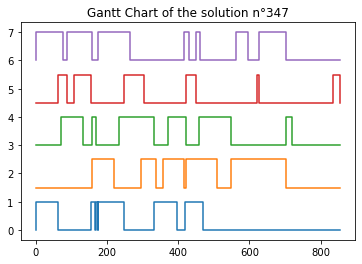

Makespan of the solution n°347 : 855
Regularity of the solution n°347 : 4568
Objective function of the solution n°347 : 3905640


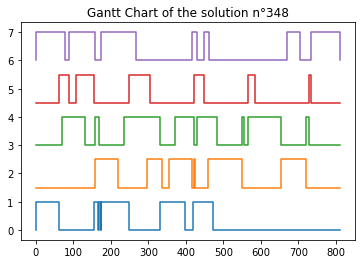

Makespan of the solution n°348 : 811
Regularity of the solution n°348 : 4826
Objective function of the solution n°348 : 3913886


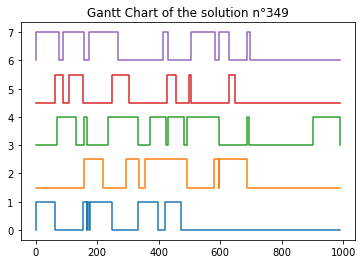

Makespan of the solution n°349 : 990
Regularity of the solution n°349 : 4062
Objective function of the solution n°349 : 4021380


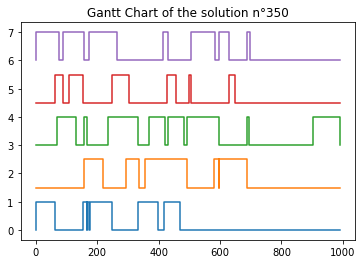

Makespan of the solution n°350 : 991
Regularity of the solution n°350 : 4066
Objective function of the solution n°350 : 4029406


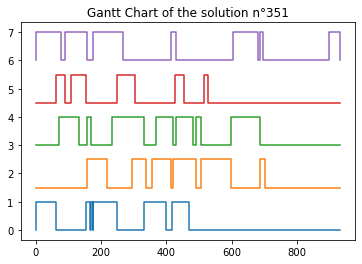

Makespan of the solution n°351 : 933
Regularity of the solution n°351 : 4402
Objective function of the solution n°351 : 4107066


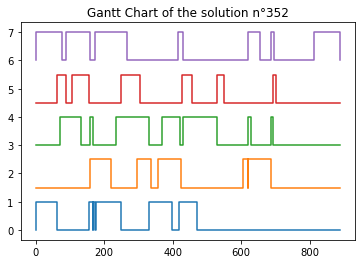

Makespan of the solution n°352 : 889
Regularity of the solution n°352 : 4762
Objective function of the solution n°352 : 4233418


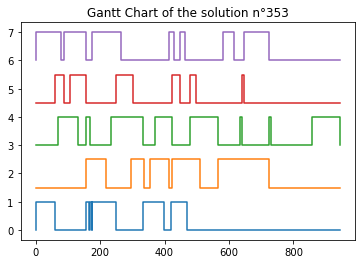

Makespan of the solution n°353 : 945
Regularity of the solution n°353 : 4522
Objective function of the solution n°353 : 4273290


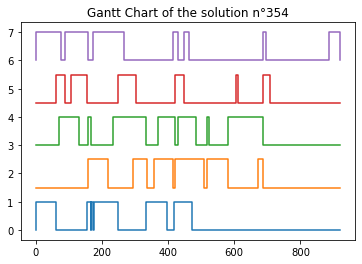

Makespan of the solution n°354 : 920
Regularity of the solution n°354 : 4648
Objective function of the solution n°354 : 4276160


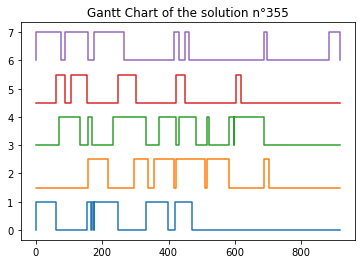

Makespan of the solution n°355 : 917
Regularity of the solution n°355 : 4700
Objective function of the solution n°355 : 4309900


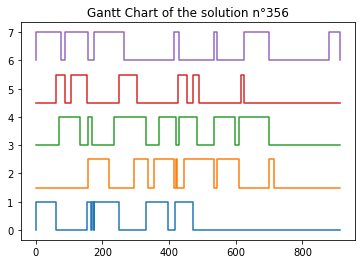

Makespan of the solution n°356 : 913
Regularity of the solution n°356 : 4804
Objective function of the solution n°356 : 4386052


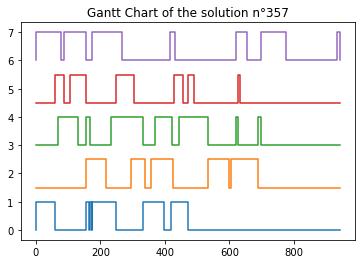

Makespan of the solution n°357 : 943
Regularity of the solution n°357 : 4718
Objective function of the solution n°357 : 4449074


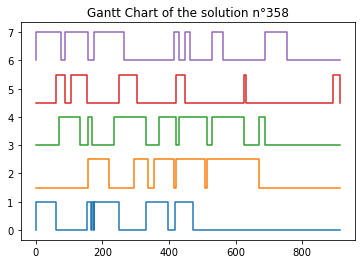

Makespan of the solution n°358 : 914
Regularity of the solution n°358 : 4870
Objective function of the solution n°358 : 4451180


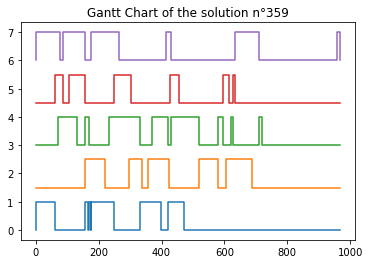

Makespan of the solution n°359 : 968
Regularity of the solution n°359 : 4600
Objective function of the solution n°359 : 4452800


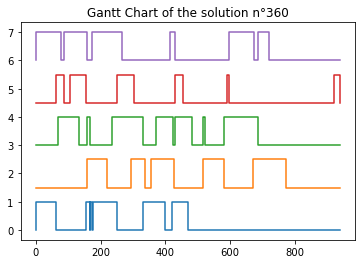

Makespan of the solution n°360 : 939
Regularity of the solution n°360 : 4768
Objective function of the solution n°360 : 4477152


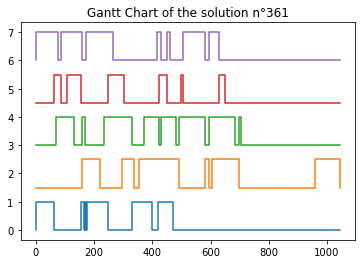

Makespan of the solution n°361 : 1045
Regularity of the solution n°361 : 4304
Objective function of the solution n°361 : 4497680


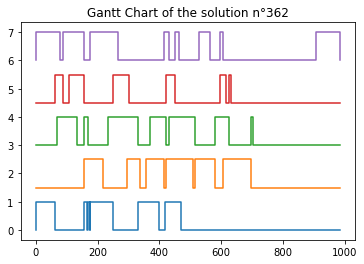

Makespan of the solution n°362 : 985
Regularity of the solution n°362 : 4598
Objective function of the solution n°362 : 4529030


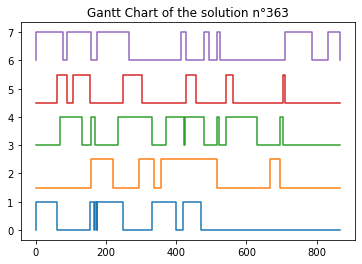

Makespan of the solution n°363 : 867
Regularity of the solution n°363 : 5258
Objective function of the solution n°363 : 4558686


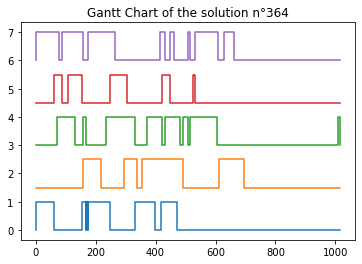

Makespan of the solution n°364 : 1016
Regularity of the solution n°364 : 4506
Objective function of the solution n°364 : 4578096


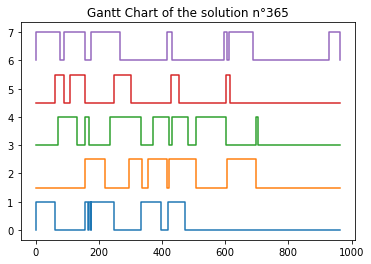

Makespan of the solution n°365 : 964
Regularity of the solution n°365 : 4796
Objective function of the solution n°365 : 4623344


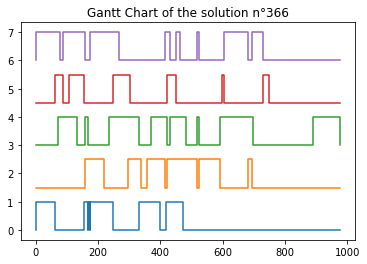

Makespan of the solution n°366 : 977
Regularity of the solution n°366 : 4748
Objective function of the solution n°366 : 4638796


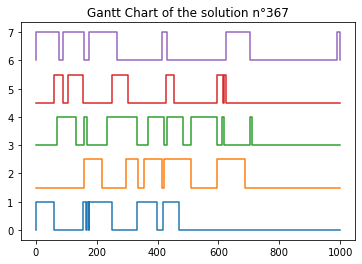

Makespan of the solution n°367 : 1000
Regularity of the solution n°367 : 4648
Objective function of the solution n°367 : 4648000


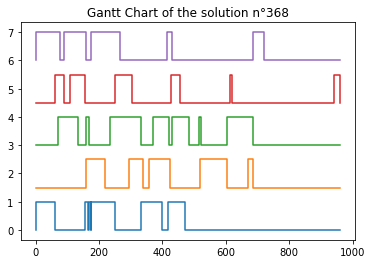

Makespan of the solution n°368 : 961
Regularity of the solution n°368 : 4858
Objective function of the solution n°368 : 4668538


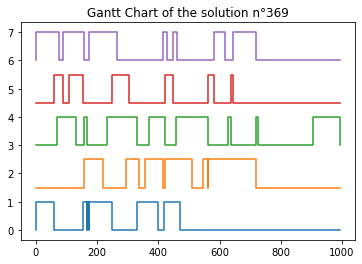

Makespan of the solution n°369 : 994
Regularity of the solution n°369 : 4708
Objective function of the solution n°369 : 4679752


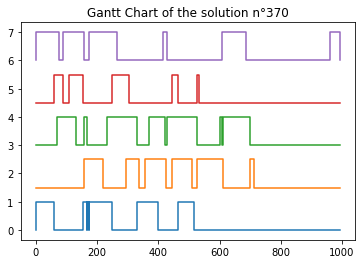

Makespan of the solution n°370 : 994
Regularity of the solution n°370 : 4716
Objective function of the solution n°370 : 4687704


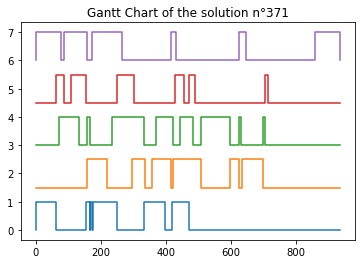

Makespan of the solution n°371 : 936
Regularity of the solution n°371 : 5052
Objective function of the solution n°371 : 4728672


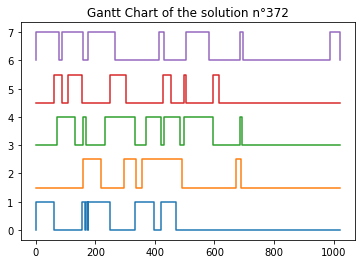

Makespan of the solution n°372 : 1022
Regularity of the solution n°372 : 4678
Objective function of the solution n°372 : 4780916


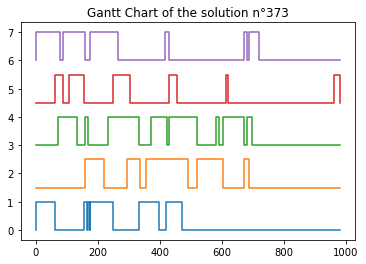

Makespan of the solution n°373 : 981
Regularity of the solution n°373 : 4938
Objective function of the solution n°373 : 4844178


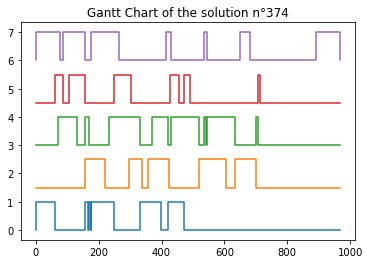

Makespan of the solution n°374 : 968
Regularity of the solution n°374 : 5200
Objective function of the solution n°374 : 5033600


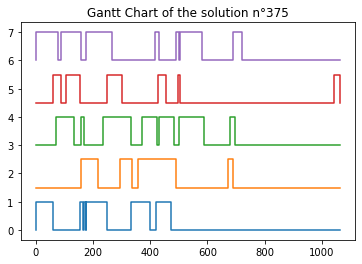

Makespan of the solution n°375 : 1064
Regularity of the solution n°375 : 4818
Objective function of the solution n°375 : 5126352


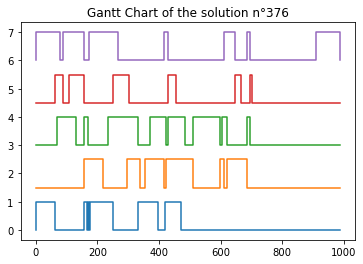

Makespan of the solution n°376 : 988
Regularity of the solution n°376 : 5238
Objective function of the solution n°376 : 5175144


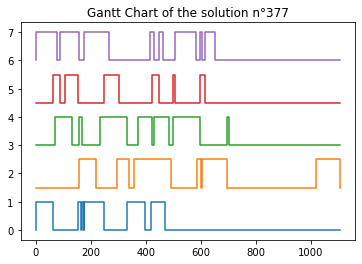

Makespan of the solution n°377 : 1106
Regularity of the solution n°377 : 4718
Objective function of the solution n°377 : 5218108


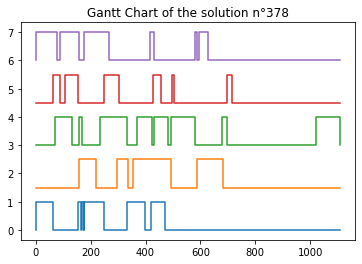

Makespan of the solution n°378 : 1109
Regularity of the solution n°378 : 4778
Objective function of the solution n°378 : 5298802


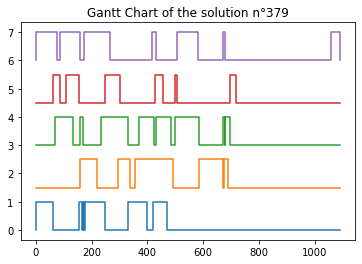

Makespan of the solution n°379 : 1091
Regularity of the solution n°379 : 4890
Objective function of the solution n°379 : 5334990


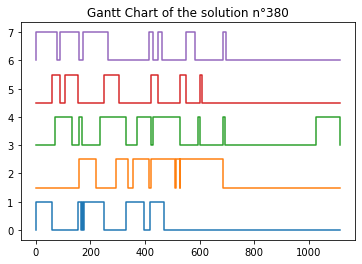

Makespan of the solution n°380 : 1115
Regularity of the solution n°380 : 4854
Objective function of the solution n°380 : 5412210


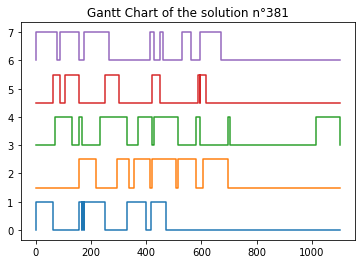

Makespan of the solution n°381 : 1103
Regularity of the solution n°381 : 4920
Objective function of the solution n°381 : 5426760


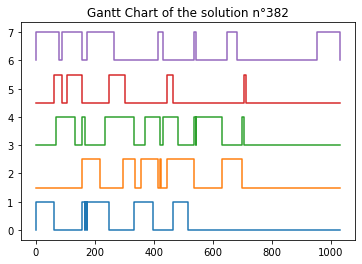

Makespan of the solution n°382 : 1032
Regularity of the solution n°382 : 5472
Objective function of the solution n°382 : 5647104


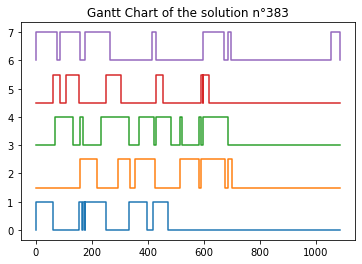

Makespan of the solution n°383 : 1087
Regularity of the solution n°383 : 5198
Objective function of the solution n°383 : 5650226


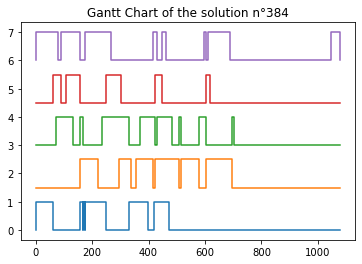

Makespan of the solution n°384 : 1079
Regularity of the solution n°384 : 5242
Objective function of the solution n°384 : 5656118


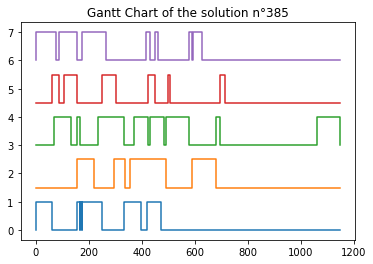

Makespan of the solution n°385 : 1149
Regularity of the solution n°385 : 4924
Objective function of the solution n°385 : 5657676


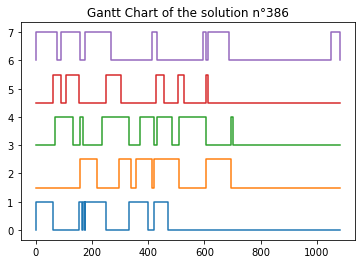

Makespan of the solution n°386 : 1083
Regularity of the solution n°386 : 5272
Objective function of the solution n°386 : 5709576


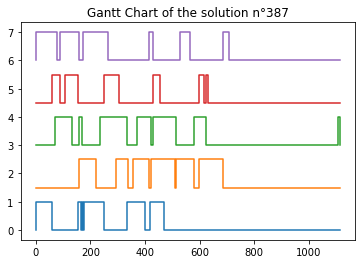

Makespan of the solution n°387 : 1114
Regularity of the solution n°387 : 5128
Objective function of the solution n°387 : 5712592


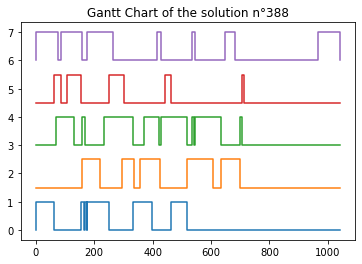

Makespan of the solution n°388 : 1042
Regularity of the solution n°388 : 5496
Objective function of the solution n°388 : 5726832


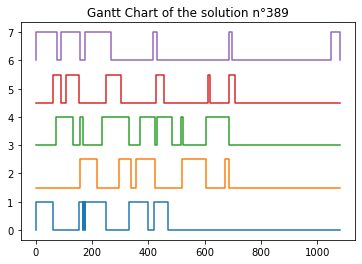

Makespan of the solution n°389 : 1081
Regularity of the solution n°389 : 5338
Objective function of the solution n°389 : 5770378


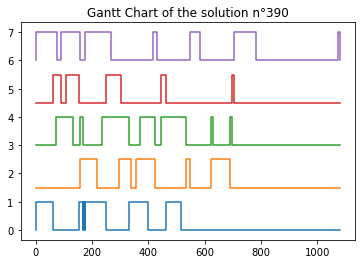

Makespan of the solution n°390 : 1081
Regularity of the solution n°390 : 5350
Objective function of the solution n°390 : 5783350


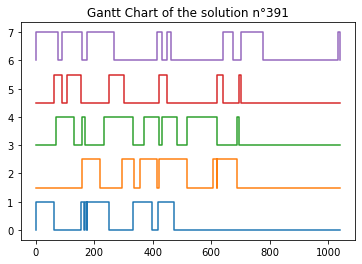

Makespan of the solution n°391 : 1041
Regularity of the solution n°391 : 5572
Objective function of the solution n°391 : 5800452


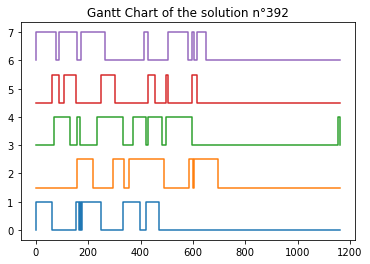

Makespan of the solution n°392 : 1162
Regularity of the solution n°392 : 5062
Objective function of the solution n°392 : 5882044


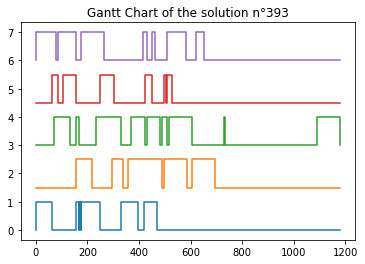

Makespan of the solution n°393 : 1180
Regularity of the solution n°393 : 5078
Objective function of the solution n°393 : 5992040


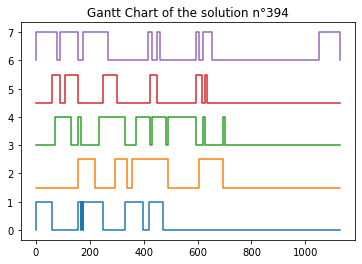

Makespan of the solution n°394 : 1129
Regularity of the solution n°394 : 5338
Objective function of the solution n°394 : 6026602


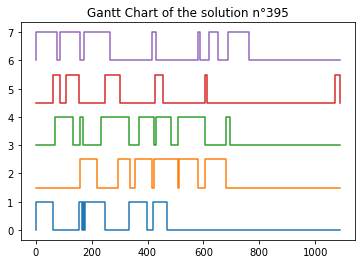

Makespan of the solution n°395 : 1089
Regularity of the solution n°395 : 5540
Objective function of the solution n°395 : 6033060


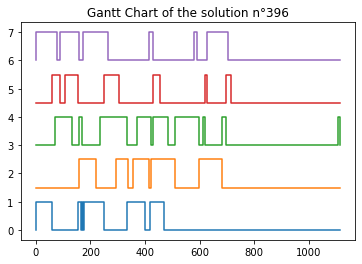

Makespan of the solution n°396 : 1114
Regularity of the solution n°396 : 5508
Objective function of the solution n°396 : 6135912


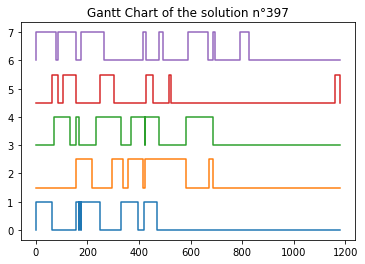

Makespan of the solution n°397 : 1180
Regularity of the solution n°397 : 5262
Objective function of the solution n°397 : 6209160


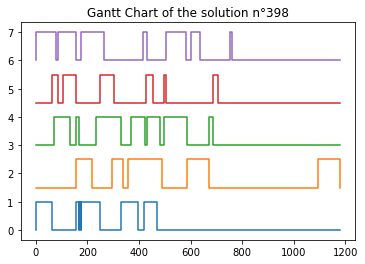

Makespan of the solution n°398 : 1180
Regularity of the solution n°398 : 5286
Objective function of the solution n°398 : 6237480


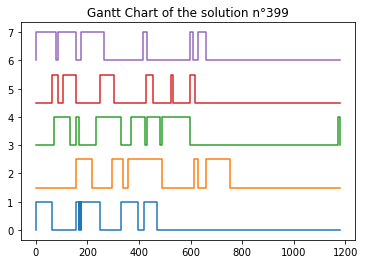

Makespan of the solution n°399 : 1180
Regularity of the solution n°399 : 5288
Objective function of the solution n°399 : 6239840


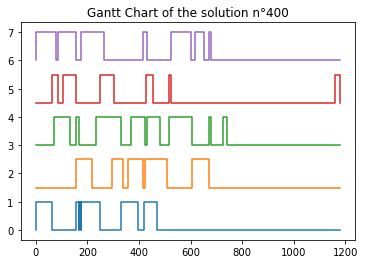

Makespan of the solution n°400 : 1180
Regularity of the solution n°400 : 5302
Objective function of the solution n°400 : 6256360


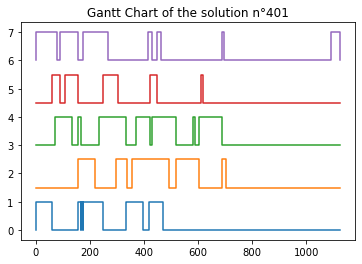

Makespan of the solution n°401 : 1125
Regularity of the solution n°401 : 5564
Objective function of the solution n°401 : 6259500


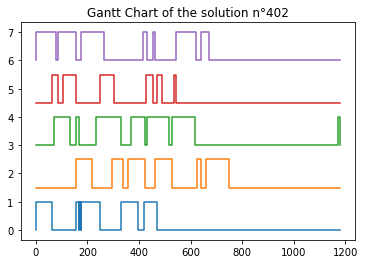

Makespan of the solution n°402 : 1180
Regularity of the solution n°402 : 5378
Objective function of the solution n°402 : 6346040


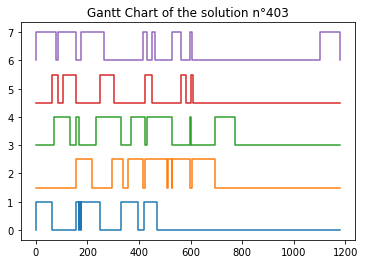

Makespan of the solution n°403 : 1180
Regularity of the solution n°403 : 5418
Objective function of the solution n°403 : 6393240


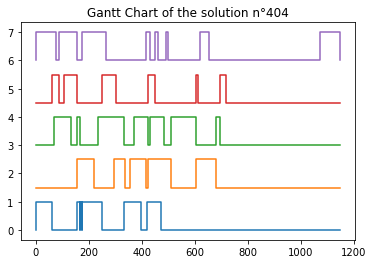

Makespan of the solution n°404 : 1148
Regularity of the solution n°404 : 5570
Objective function of the solution n°404 : 6394360


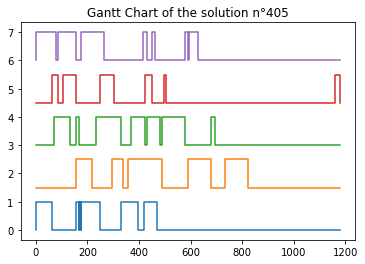

Makespan of the solution n°405 : 1180
Regularity of the solution n°405 : 5482
Objective function of the solution n°405 : 6468760


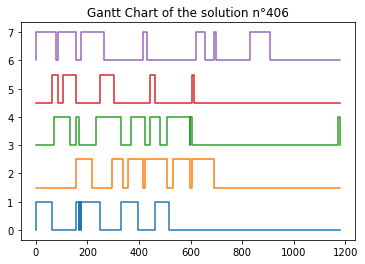

Makespan of the solution n°406 : 1180
Regularity of the solution n°406 : 5482
Objective function of the solution n°406 : 6468760


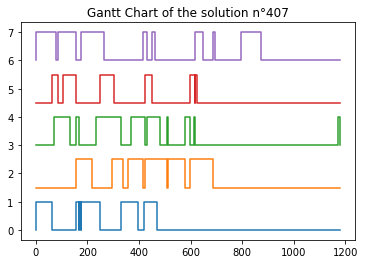

Makespan of the solution n°407 : 1180
Regularity of the solution n°407 : 5494
Objective function of the solution n°407 : 6482920


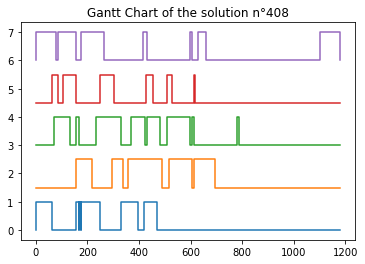

Makespan of the solution n°408 : 1180
Regularity of the solution n°408 : 5524
Objective function of the solution n°408 : 6518320


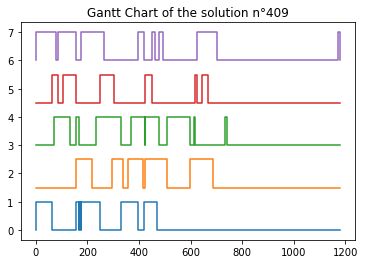

Makespan of the solution n°409 : 1180
Regularity of the solution n°409 : 5538
Objective function of the solution n°409 : 6534840


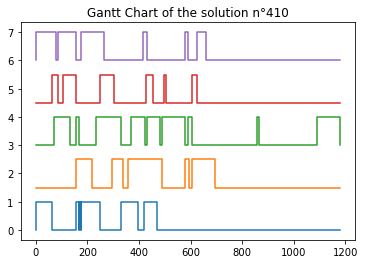

Makespan of the solution n°410 : 1180
Regularity of the solution n°410 : 5550
Objective function of the solution n°410 : 6549000


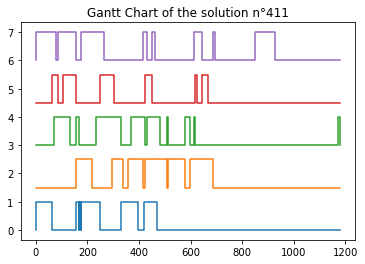

Makespan of the solution n°411 : 1180
Regularity of the solution n°411 : 5558
Objective function of the solution n°411 : 6558440


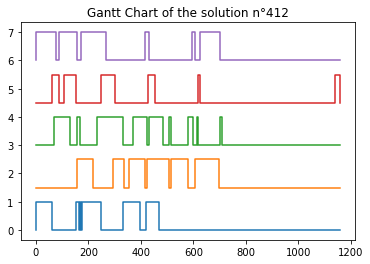

Makespan of the solution n°412 : 1159
Regularity of the solution n°412 : 5664
Objective function of the solution n°412 : 6564576


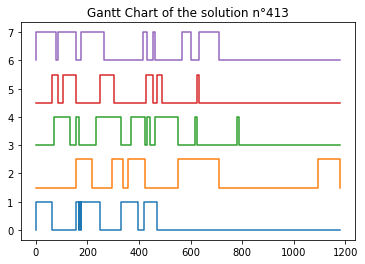

Makespan of the solution n°413 : 1180
Regularity of the solution n°413 : 5574
Objective function of the solution n°413 : 6577320


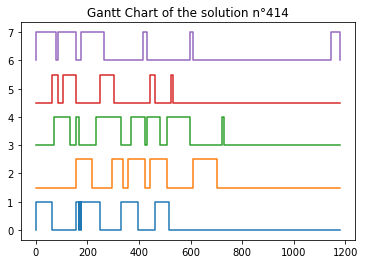

Makespan of the solution n°414 : 1180
Regularity of the solution n°414 : 5584
Objective function of the solution n°414 : 6589120


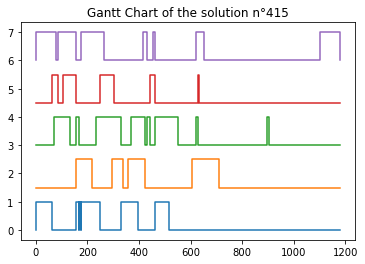

Makespan of the solution n°415 : 1180
Regularity of the solution n°415 : 5584
Objective function of the solution n°415 : 6589120


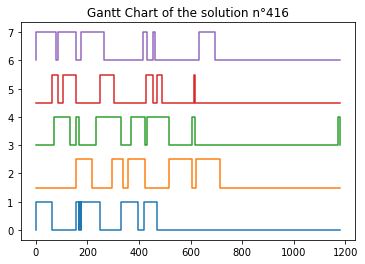

Makespan of the solution n°416 : 1180
Regularity of the solution n°416 : 5588
Objective function of the solution n°416 : 6593840


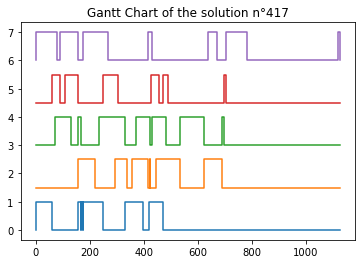

Makespan of the solution n°417 : 1128
Regularity of the solution n°417 : 5898
Objective function of the solution n°417 : 6652944


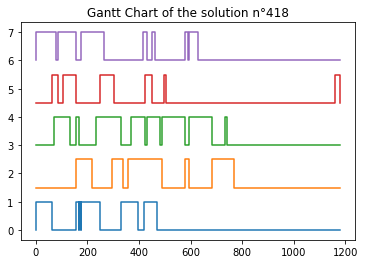

Makespan of the solution n°418 : 1180
Regularity of the solution n°418 : 5642
Objective function of the solution n°418 : 6657560


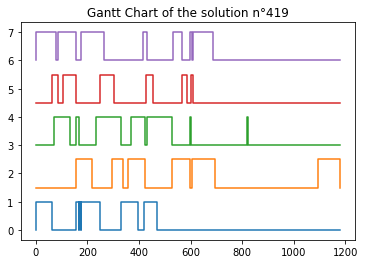

Makespan of the solution n°419 : 1180
Regularity of the solution n°419 : 5648
Objective function of the solution n°419 : 6664640


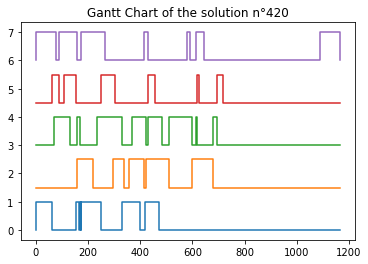

Makespan of the solution n°420 : 1166
Regularity of the solution n°420 : 5716
Objective function of the solution n°420 : 6664856


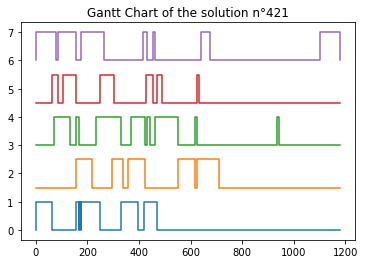

Makespan of the solution n°421 : 1180
Regularity of the solution n°421 : 5664
Objective function of the solution n°421 : 6683520


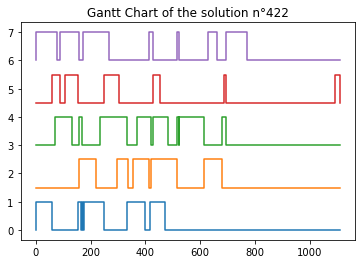

Makespan of the solution n°422 : 1112
Regularity of the solution n°422 : 6044
Objective function of the solution n°422 : 6720928


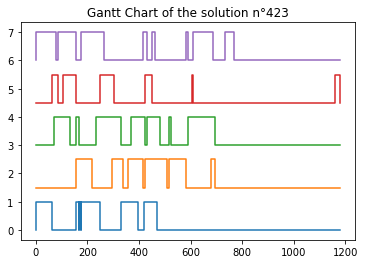

Makespan of the solution n°423 : 1180
Regularity of the solution n°423 : 5724
Objective function of the solution n°423 : 6754320


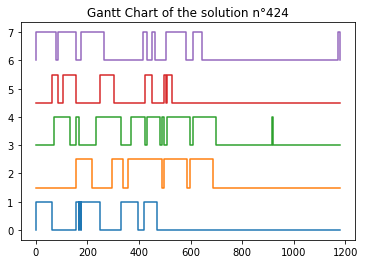

Makespan of the solution n°424 : 1180
Regularity of the solution n°424 : 5804
Objective function of the solution n°424 : 6848720


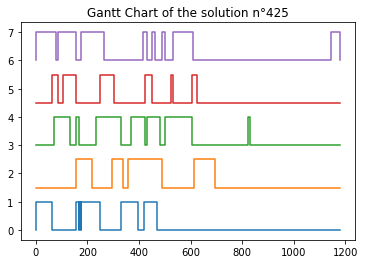

Makespan of the solution n°425 : 1180
Regularity of the solution n°425 : 5834
Objective function of the solution n°425 : 6884120


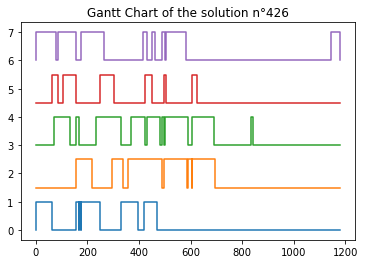

Makespan of the solution n°426 : 1180
Regularity of the solution n°426 : 5884
Objective function of the solution n°426 : 6943120


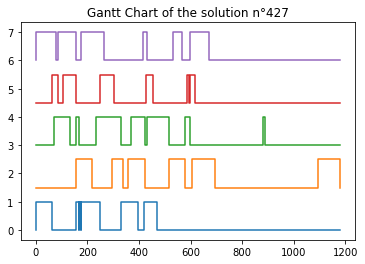

Makespan of the solution n°427 : 1180
Regularity of the solution n°427 : 5974
Objective function of the solution n°427 : 7049320


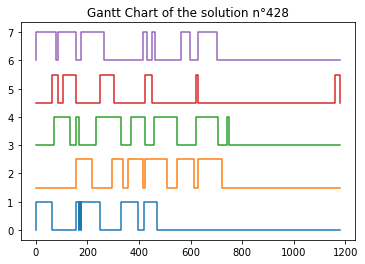

Makespan of the solution n°428 : 1180
Regularity of the solution n°428 : 6024
Objective function of the solution n°428 : 7108320


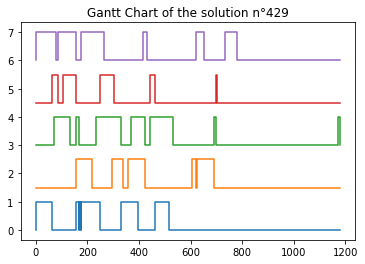

Makespan of the solution n°429 : 1180
Regularity of the solution n°429 : 6046
Objective function of the solution n°429 : 7134280


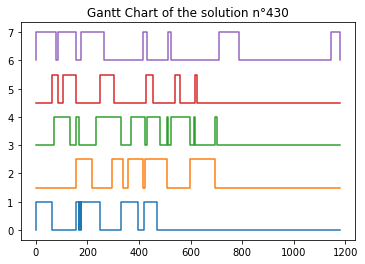

Makespan of the solution n°430 : 1180
Regularity of the solution n°430 : 6060
Objective function of the solution n°430 : 7150800


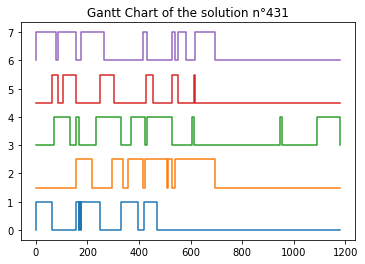

Makespan of the solution n°431 : 1180
Regularity of the solution n°431 : 6208
Objective function of the solution n°431 : 7325440


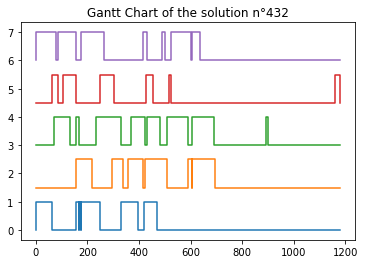

Makespan of the solution n°432 : 1180
Regularity of the solution n°432 : 6218
Objective function of the solution n°432 : 7337240


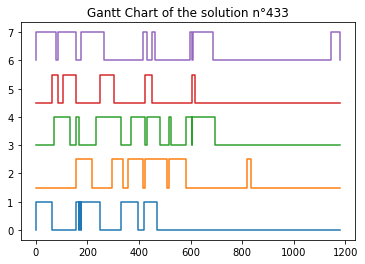

Makespan of the solution n°433 : 1180
Regularity of the solution n°433 : 6276
Objective function of the solution n°433 : 7405680


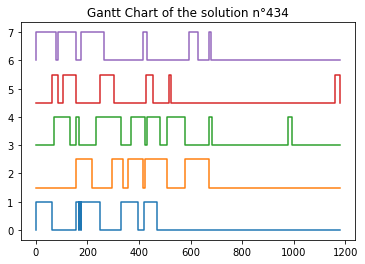

Makespan of the solution n°434 : 1180
Regularity of the solution n°434 : 6298
Objective function of the solution n°434 : 7431640


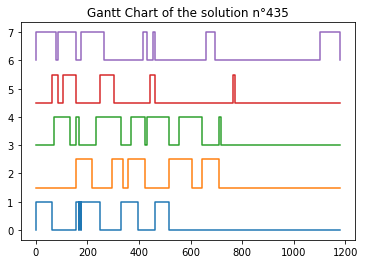

Makespan of the solution n°435 : 1180
Regularity of the solution n°435 : 6372
Objective function of the solution n°435 : 7518960


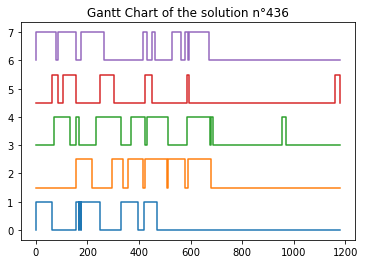

Makespan of the solution n°436 : 1180
Regularity of the solution n°436 : 6470
Objective function of the solution n°436 : 7634600


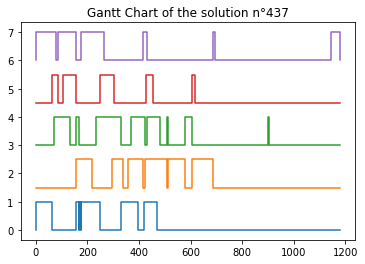

Makespan of the solution n°437 : 1180
Regularity of the solution n°437 : 6472
Objective function of the solution n°437 : 7636960


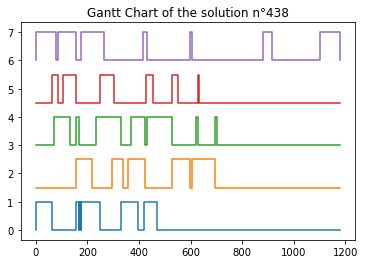

Makespan of the solution n°438 : 1180
Regularity of the solution n°438 : 6604
Objective function of the solution n°438 : 7792720


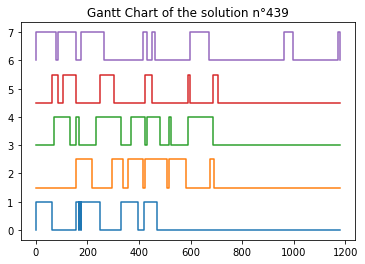

Makespan of the solution n°439 : 1180
Regularity of the solution n°439 : 6604
Objective function of the solution n°439 : 7792720


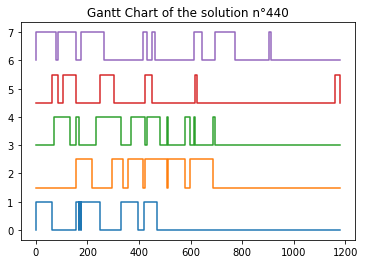

Makespan of the solution n°440 : 1180
Regularity of the solution n°440 : 6650
Objective function of the solution n°440 : 7847000


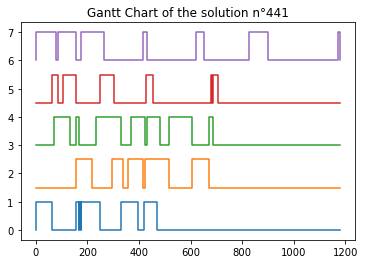

Makespan of the solution n°441 : 1180
Regularity of the solution n°441 : 6652
Objective function of the solution n°441 : 7849360


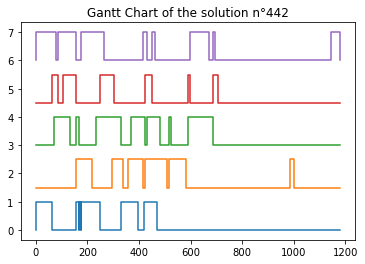

Makespan of the solution n°442 : 1180
Regularity of the solution n°442 : 6658
Objective function of the solution n°442 : 7856440


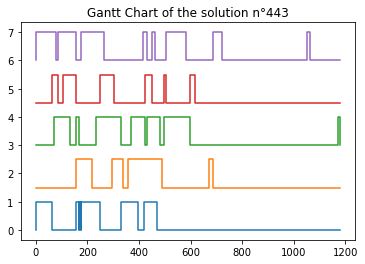

Makespan of the solution n°443 : 1180
Regularity of the solution n°443 : 6676
Objective function of the solution n°443 : 7877680


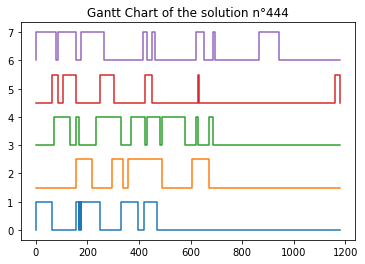

Makespan of the solution n°444 : 1180
Regularity of the solution n°444 : 6698
Objective function of the solution n°444 : 7903640


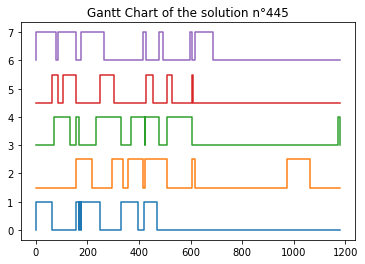

Makespan of the solution n°445 : 1180
Regularity of the solution n°445 : 6740
Objective function of the solution n°445 : 7953200


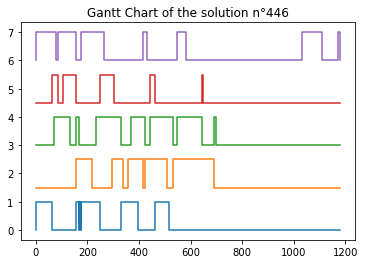

Makespan of the solution n°446 : 1180
Regularity of the solution n°446 : 6778
Objective function of the solution n°446 : 7998040


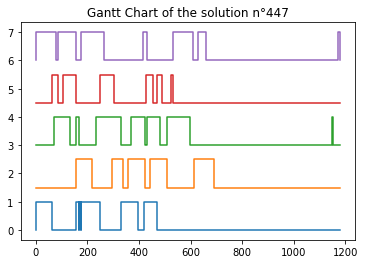

Makespan of the solution n°447 : 1180
Regularity of the solution n°447 : 6806
Objective function of the solution n°447 : 8031080


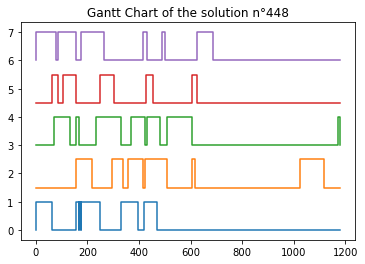

Makespan of the solution n°448 : 1180
Regularity of the solution n°448 : 6972
Objective function of the solution n°448 : 8226960


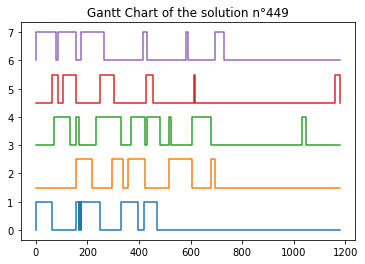

Makespan of the solution n°449 : 1180
Regularity of the solution n°449 : 6986
Objective function of the solution n°449 : 8243480


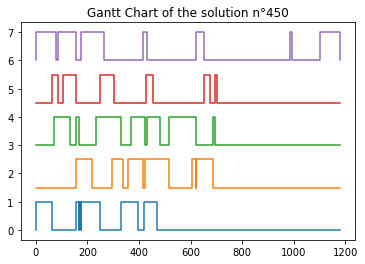

Makespan of the solution n°450 : 1180
Regularity of the solution n°450 : 6998
Objective function of the solution n°450 : 8257640


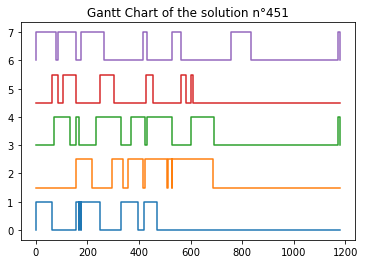

Makespan of the solution n°451 : 1180
Regularity of the solution n°451 : 7018
Objective function of the solution n°451 : 8281240


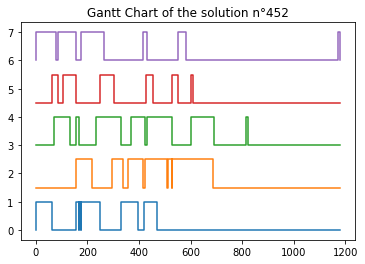

Makespan of the solution n°452 : 1180
Regularity of the solution n°452 : 7022
Objective function of the solution n°452 : 8285960


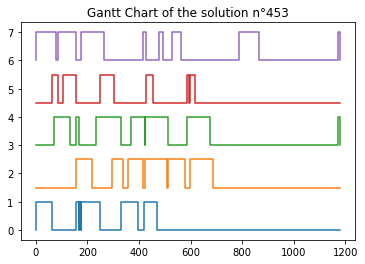

Makespan of the solution n°453 : 1180
Regularity of the solution n°453 : 7036
Objective function of the solution n°453 : 8302480


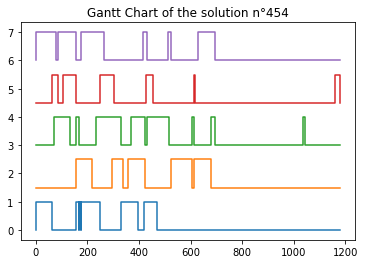

Makespan of the solution n°454 : 1180
Regularity of the solution n°454 : 7048
Objective function of the solution n°454 : 8316640


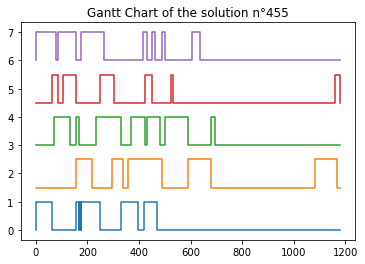

Makespan of the solution n°455 : 1180
Regularity of the solution n°455 : 7102
Objective function of the solution n°455 : 8380360


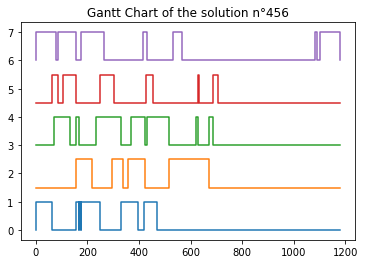

Makespan of the solution n°456 : 1180
Regularity of the solution n°456 : 7152
Objective function of the solution n°456 : 8439360


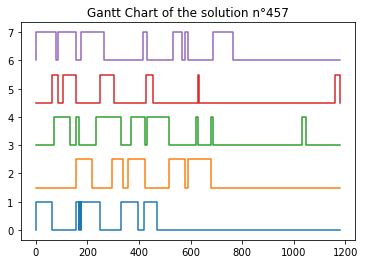

Makespan of the solution n°457 : 1180
Regularity of the solution n°457 : 7208
Objective function of the solution n°457 : 8505440


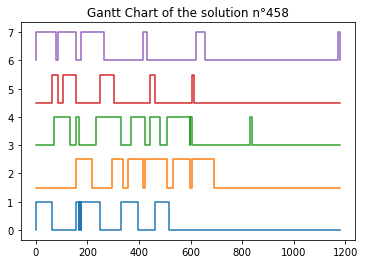

Makespan of the solution n°458 : 1180
Regularity of the solution n°458 : 7210
Objective function of the solution n°458 : 8507800


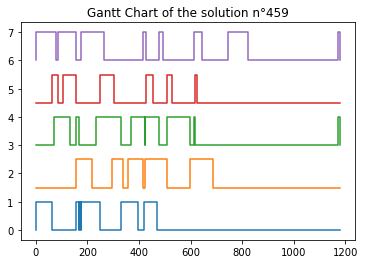

Makespan of the solution n°459 : 1180
Regularity of the solution n°459 : 7232
Objective function of the solution n°459 : 8533760


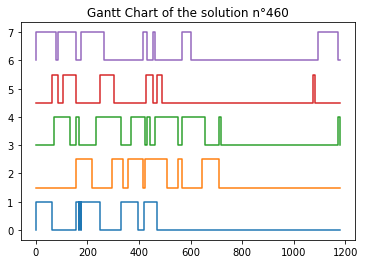

Makespan of the solution n°460 : 1180
Regularity of the solution n°460 : 7268
Objective function of the solution n°460 : 8576240


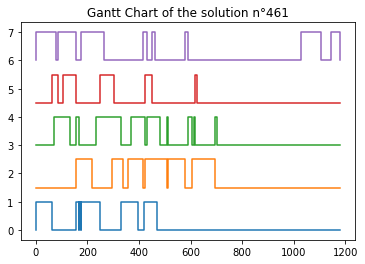

Makespan of the solution n°461 : 1180
Regularity of the solution n°461 : 7322
Objective function of the solution n°461 : 8639960


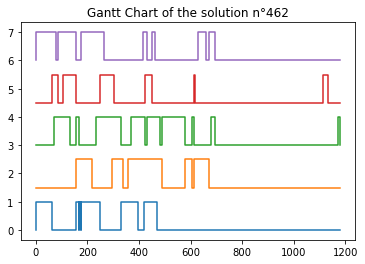

Makespan of the solution n°462 : 1180
Regularity of the solution n°462 : 7394
Objective function of the solution n°462 : 8724920


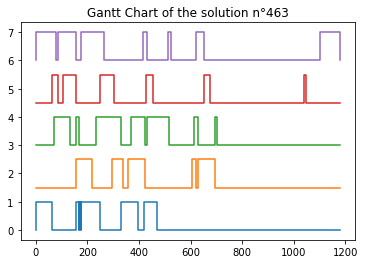

Makespan of the solution n°463 : 1180
Regularity of the solution n°463 : 7430
Objective function of the solution n°463 : 8767400


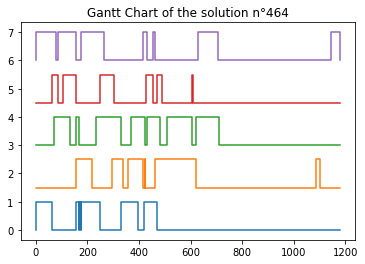

Makespan of the solution n°464 : 1180
Regularity of the solution n°464 : 7458
Objective function of the solution n°464 : 8800440


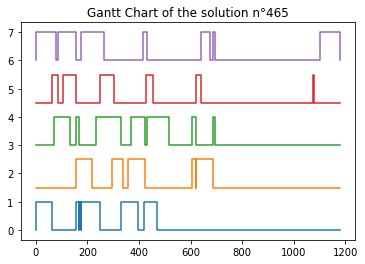

Makespan of the solution n°465 : 1180
Regularity of the solution n°465 : 7526
Objective function of the solution n°465 : 8880680


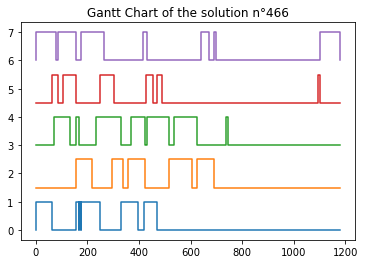

Makespan of the solution n°466 : 1180
Regularity of the solution n°466 : 7748
Objective function of the solution n°466 : 9142640


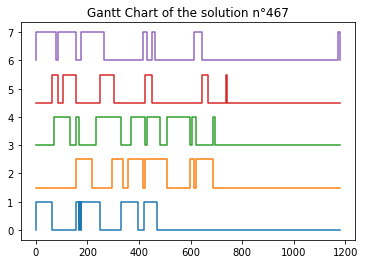

Makespan of the solution n°467 : 1180
Regularity of the solution n°467 : 7900
Objective function of the solution n°467 : 9322000


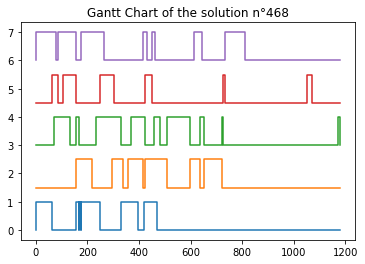

Makespan of the solution n°468 : 1180
Regularity of the solution n°468 : 7924
Objective function of the solution n°468 : 9350320


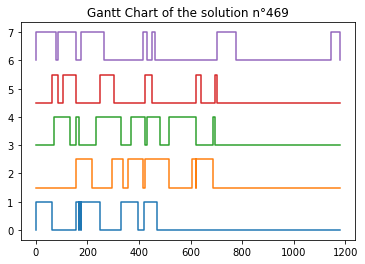

Makespan of the solution n°469 : 1180
Regularity of the solution n°469 : 8028
Objective function of the solution n°469 : 9473040


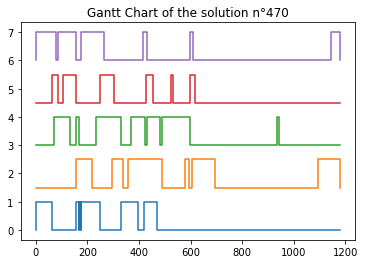

Makespan of the solution n°470 : 1180
Regularity of the solution n°470 : 8182
Objective function of the solution n°470 : 9654760


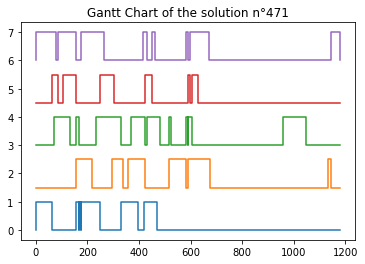

Makespan of the solution n°471 : 1180
Regularity of the solution n°471 : 8426
Objective function of the solution n°471 : 9942680


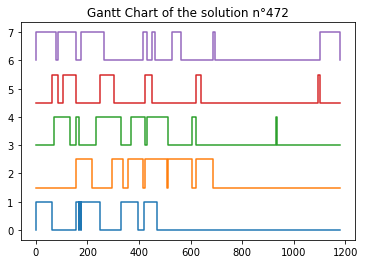

Makespan of the solution n°472 : 1180
Regularity of the solution n°472 : 8452
Objective function of the solution n°472 : 9973360


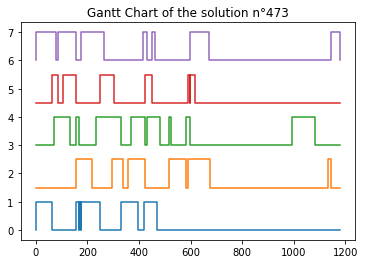

Makespan of the solution n°473 : 1180
Regularity of the solution n°473 : 8562
Objective function of the solution n°473 : 10103160


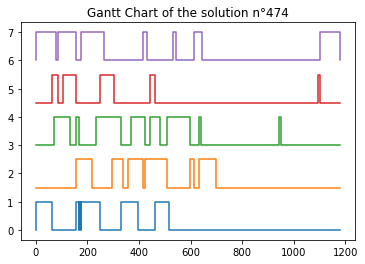

Makespan of the solution n°474 : 1180
Regularity of the solution n°474 : 8568
Objective function of the solution n°474 : 10110240


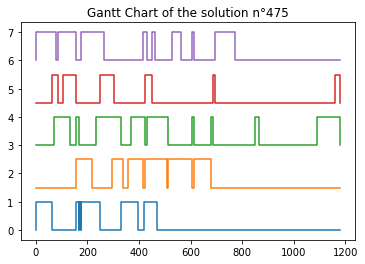

Makespan of the solution n°475 : 1180
Regularity of the solution n°475 : 8618
Objective function of the solution n°475 : 10169240


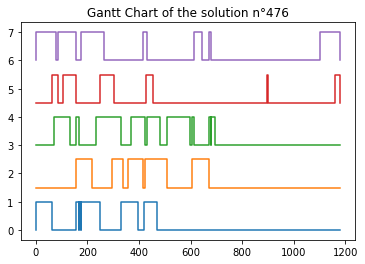

Makespan of the solution n°476 : 1180
Regularity of the solution n°476 : 8802
Objective function of the solution n°476 : 10386360


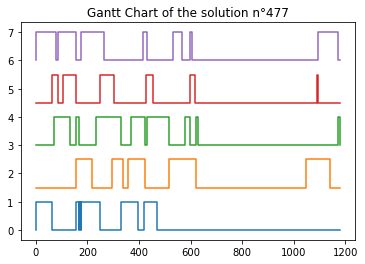

Makespan of the solution n°477 : 1180
Regularity of the solution n°477 : 8832
Objective function of the solution n°477 : 10421760


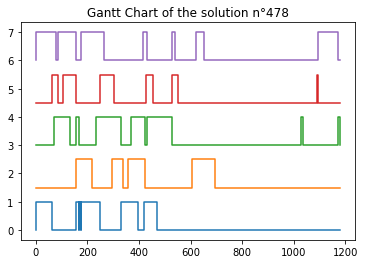

Makespan of the solution n°478 : 1180
Regularity of the solution n°478 : 8878
Objective function of the solution n°478 : 10476040


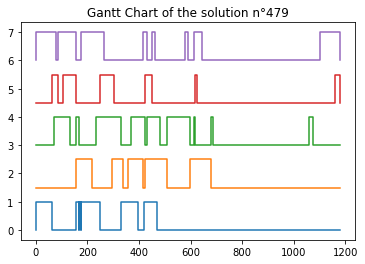

Makespan of the solution n°479 : 1180
Regularity of the solution n°479 : 8938
Objective function of the solution n°479 : 10546840


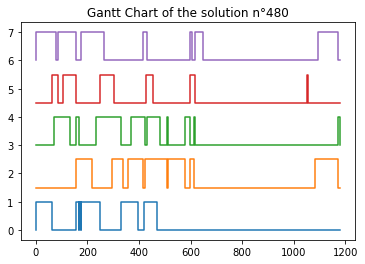

Makespan of the solution n°480 : 1180
Regularity of the solution n°480 : 8944
Objective function of the solution n°480 : 10553920


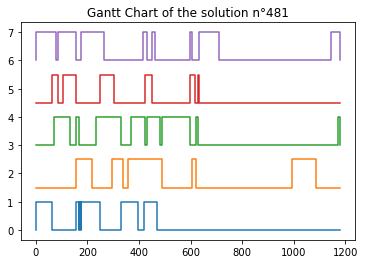

Makespan of the solution n°481 : 1180
Regularity of the solution n°481 : 9010
Objective function of the solution n°481 : 10631800


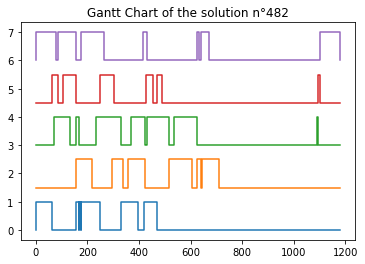

Makespan of the solution n°482 : 1180
Regularity of the solution n°482 : 9172
Objective function of the solution n°482 : 10822960


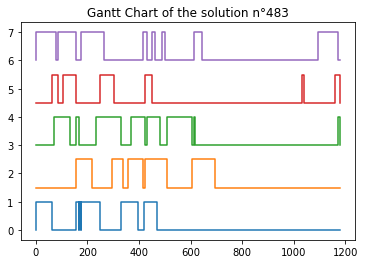

Makespan of the solution n°483 : 1180
Regularity of the solution n°483 : 9262
Objective function of the solution n°483 : 10929160


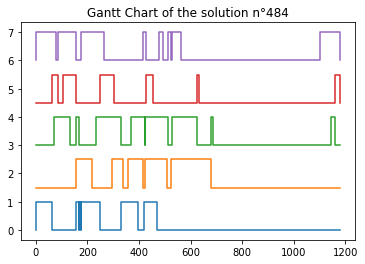

Makespan of the solution n°484 : 1180
Regularity of the solution n°484 : 9304
Objective function of the solution n°484 : 10978720


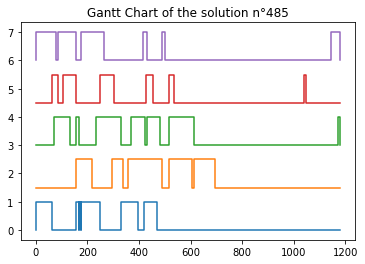

Makespan of the solution n°485 : 1180
Regularity of the solution n°485 : 9308
Objective function of the solution n°485 : 10983440


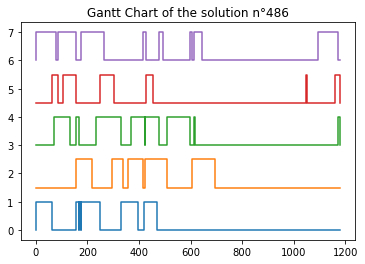

Makespan of the solution n°486 : 1180
Regularity of the solution n°486 : 9336
Objective function of the solution n°486 : 11016480


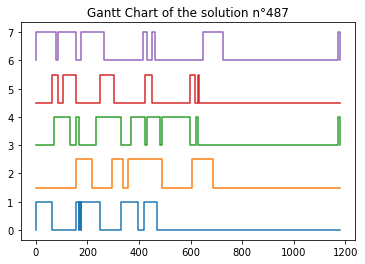

Makespan of the solution n°487 : 1180
Regularity of the solution n°487 : 9386
Objective function of the solution n°487 : 11075480


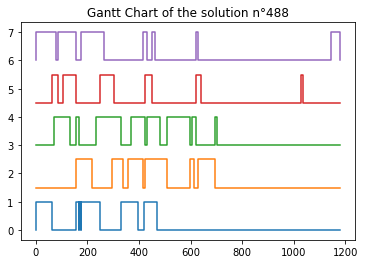

Makespan of the solution n°488 : 1180
Regularity of the solution n°488 : 9424
Objective function of the solution n°488 : 11120320


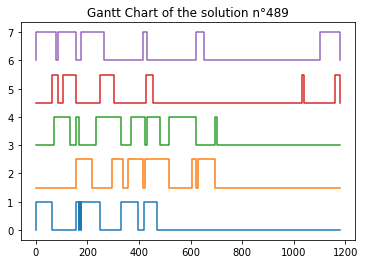

Makespan of the solution n°489 : 1180
Regularity of the solution n°489 : 9426
Objective function of the solution n°489 : 11122680


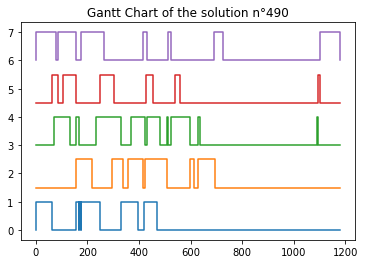

Makespan of the solution n°490 : 1180
Regularity of the solution n°490 : 9458
Objective function of the solution n°490 : 11160440


In [8]:
pref = user.getPreferences()
print(len(pref))

# ------------ Generate Gantt Chart
start_times = []
end_times = []
task_lengths = []

n_sol = 0
for sol in pref:
    n_sol = n_sol + 1
    sol_list = sol.get_all_var_solutions()
    
    mkspan=max([sol_list[i].get_end() for i in range(len(sol_list))] )
    x = [ [] for i in range(m)]
    y = [ [] for i in range(m)]
    mp = [ {} for i in range(m)]
    sz=len(sol_list)
    for i in range(sz) : 
        ind=T_machine[i]
        x[ind].append(sol_list[i].get_start())
        mp[ind][sol_list[i].get_start()]=ind
        x[ind].append(sol_list[i].get_end())
        mp[ind][sol_list[i].get_end()]=ind+1
    eps=0.5
    for i in range(m):
        x[i]=sorted(x[i])
        y[i]=[mp[i][x[i][j]]+i*eps for j in range(len(x[i]))]
        x[i]=[0]+x[i]
        y[i]=[i+i*eps]+y[i]
        x[i]=x[i]+[mkspan]
        y[i].append(i+i*eps)
        plt.step(x[i],y[i])
    plt.title("Gantt Chart of the solution n°" + str(n_sol))
    plt.show()
    print("Makespan of the solution n°" + str(n_sol) + " : " + str(mkspan))
    print("Regularity of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunctionRegularity(sol, n, m)))
    print("Objective function of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunction(sol)*user.objectiveFunctionRegularity(sol, n, m)))